## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.price = torch.from_numpy(df["price"].to_numpy())
        self.data = torch.from_numpy(df.drop(columns="price").to_numpy())
        self.purpose = purpose
        
    def __len__(self):
        return len(self.price)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = self.data[index]
        label = self.price[index]
        return {"sample": sample, "label": label}
#print(train_df)
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=1)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', None)
train_df.head(5)

host_is_superhost  latitude  longitude  property_type  room_type  \
0                  0 -0.396491   0.215068      -0.444532  -0.686927   
1                  0 -0.841516   0.095963       1.182045  -0.686927   
2                  0 -0.725178  -0.909397      -0.444532   1.329375   
3                  0 -0.048882   0.086232      -0.444532  -0.686927   
4                  0 -0.635052   0.094278      -0.444532  -0.686927   

   accommodates  bathrooms  bedrooms      beds     price  instant_bookable  \
0     -0.597957  -0.436242 -0.353343 -0.650700  0.438466                 0   
1     -0.597957  -0.436242 -0.353343 -0.650700  2.623250                 0   
2     -0.597957  -0.436242 -0.353343 -0.650700 -1.027833                 1   
3     -0.597957  -0.436242 -1.660357 -0.650700  1.171615                 0   
4     -0.030463  -0.436242  0.953672  0.389812  1.010322                 0   

   cancellation_policy  amenities_Kitchen  amenities_Heating  \
0             1.160642                  1                  1   
1            -1.125796                  1                  1   
2            -1.125796                  1                  1   
3            -0.422277                  1                  1   
4             1.160642                  1                  1   

   amenities_Washer  amenities_Wifi  amenities_Indoor fireplace  \
0                 1               1                           0   
1                 1               1                           0   
2                 1               1                           0   
3                 1               1                           0   
4                 1               1                           0   

   amenities_Iron  amenities_Laptop friendly workspace  amenities_Crib  \
0               1                                    1               0   
1               1                                    1               0   
2               0                                    0               0   
3               0                                    0               0   
4               1                                    1               0   

   amenities_Self check-in  amenities_Carbon monoxide detector  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   1   

   amenities_Shampoo  amenities_Air conditioning  amenities_Dryer  \
0                  1                           1                1   
1                  1                           1                1   
2                  1                           1                1   
3                  0                           1                1   
4                  0                           1                1   

   amenities_Breakfast  amenities_Hangers  amenities_Hair dryer  amenities_TV  \
0                    1                  0                     1             1   
1                    0                  1                     1             1   
2                    0                  0                     0             1   
3                    0                  1                     0             1   
4                    0                  1                     1             1   

   amenities_High chair  amenities_Smoke detector  amenities_Private bathroom  \
0                     0                         1                           0   
1                     0                         1                           0   
2                     0                         1                           0   
3                     0                         1                           0   
4                     0                         1                           0   

   amenities_count  facilities_Free parking on premises  facilities_Gym  \
0         0.2

#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

mean        std
price                120.097102  68.198942
latitude              43.677492   0.046110
longitude            -79.398326   0.059359
property_type          2.819879   1.844364
room_type              0.340686   0.495957
accommodates           3.053679   1.762132
bathrooms              1.200374   0.459320
bedrooms               1.270343   0.765102
beds                   1.625366   0.961066
cancellation_policy    7.400940   5.685699
amenities_count       12.185917   2.775618
facilities_count       1.065138   1.181071
house_rules_count      0.184610   0.449641

## Define Model

In [6]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*2)
        self.layer2 = nn.Linear(41*2, 41*3)
        self.layer3 = nn.Linear(41*3, 41*2)
        self.layer4 = nn.Linear(41*2, 41*1)
        self.layer5 = nn.Linear(41*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        return self.layer5(x)

## Training Function

In [7]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        #print("hello")
        for i, data in enumerate(train_loader):
            #print(i)
            #print((data))
            sample = data["sample"].float()
            label = data["label"].float().view(-1)
            output = net(sample).view(-1)
            #print(output.shape)
            #print(label.shape)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float().view(-1)
        output = net(sample).view(-1)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 0.419518  time: 4.361
---[ITER 20] loss: 0.413550  time: 4.696
---[ITER 30] loss: 0.402661  time: 4.102
---[ITER 40] loss: 0.396175  time: 3.736
---[ITER 50] loss: 0.400987  time: 4.177
---[ITER 60] loss: 0.387026  time: 3.557
---[ITER 70] loss: 0.384359  time: 3.519
---[ITER 80] loss: 0.363181  time: 3.348
---[ITER 90] loss: 0.355781  time: 3.164
---[ITER 100] loss: 0.344234  time: 3.455
---[ITER 110] loss: 0.326441  time: 4.057
---[ITER 120] loss: 0.308113  time: 4.706
---[ITER 130] loss: 0.293550  time: 3.963
---[ITER 140] loss: 0.280453  time: 3.953
---[ITER 150] loss: 0.268836  time: 3.419
---[ITER 160] loss: 0.269155  time: 4.048
[EPOCH 1] loss: 0.346414  time: 65.638
---[ITER 10] loss: 0.259508  time: 3.686
---[ITER 20] loss: 0.242659  time: 3.505
---[ITER 30] loss: 0.250636  time: 3.872
---[ITER 40] loss: 0.253373  time: 3.151
---[ITER 50] loss: 0.241937  time: 3.518
---[ITER 60] loss: 0.238504  time: 3.221
---[ITER 70] loss: 0.237823  ti

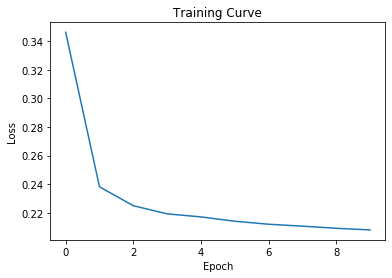

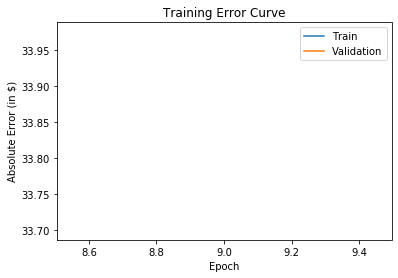

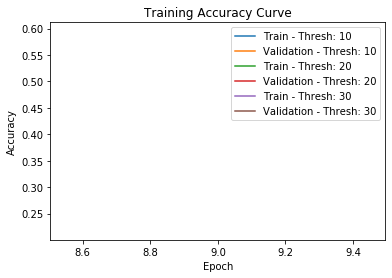

---[ITER 10] loss: 0.206694  time: 3.473
---[ITER 20] loss: 0.208830  time: 4.717
---[ITER 30] loss: 0.213578  time: 3.755
---[ITER 40] loss: 0.206660  time: 3.298
---[ITER 50] loss: 0.210156  time: 3.324
---[ITER 60] loss: 0.203113  time: 3.426
---[ITER 70] loss: 0.205434  time: 3.491
---[ITER 80] loss: 0.211769  time: 3.990
---[ITER 90] loss: 0.205565  time: 4.045
---[ITER 100] loss: 0.213481  time: 3.827
---[ITER 110] loss: 0.204442  time: 4.485
---[ITER 120] loss: 0.201894  time: 4.254
---[ITER 130] loss: 0.202737  time: 3.334
---[ITER 140] loss: 0.203109  time: 3.655
---[ITER 150] loss: 0.205288  time: 3.423
---[ITER 160] loss: 0.204532  time: 3.491
[EPOCH 11] loss: 0.206688  time: 62.622
---[ITER 10] loss: 0.204797  time: 3.415
---[ITER 20] loss: 0.204692  time: 3.308
---[ITER 30] loss: 0.205689  time: 3.279
---[ITER 40] loss: 0.206506  time: 3.257
---[ITER 50] loss: 0.209396  time: 3.385
---[ITER 60] loss: 0.206640  time: 3.333
---[ITER 70] loss: 0.198893  time: 3.423
---[ITER 8

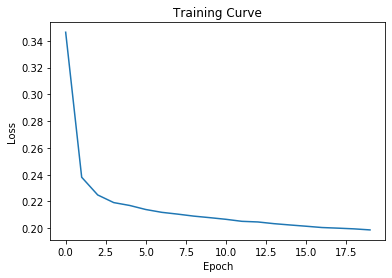

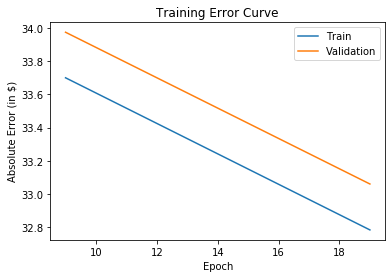

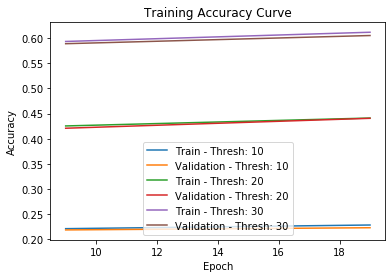

---[ITER 10] loss: 0.197772  time: 3.123
---[ITER 20] loss: 0.196747  time: 3.132
---[ITER 30] loss: 0.201480  time: 3.255
---[ITER 40] loss: 0.192087  time: 3.219
---[ITER 50] loss: 0.189945  time: 3.083
---[ITER 60] loss: 0.197308  time: 3.141
---[ITER 70] loss: 0.196929  time: 3.126
---[ITER 80] loss: 0.204860  time: 3.100
---[ITER 90] loss: 0.196755  time: 3.091
---[ITER 100] loss: 0.200928  time: 3.289
---[ITER 110] loss: 0.199854  time: 3.213
---[ITER 120] loss: 0.201055  time: 3.042
---[ITER 130] loss: 0.194646  time: 3.029
---[ITER 140] loss: 0.202067  time: 3.231
---[ITER 150] loss: 0.199481  time: 3.177
---[ITER 160] loss: 0.196161  time: 3.188
[EPOCH 21] loss: 0.197953  time: 52.974
---[ITER 10] loss: 0.196367  time: 3.225
---[ITER 20] loss: 0.199113  time: 3.210
---[ITER 30] loss: 0.200374  time: 3.136
---[ITER 40] loss: 0.199197  time: 3.070
---[ITER 50] loss: 0.192868  time: 3.062
---[ITER 60] loss: 0.199276  time: 3.097
---[ITER 70] loss: 0.196423  time: 3.042
---[ITER 8

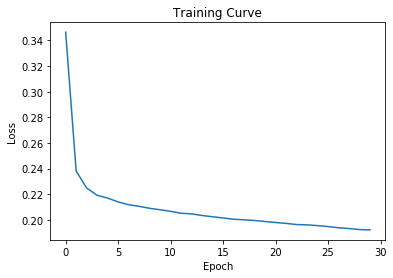

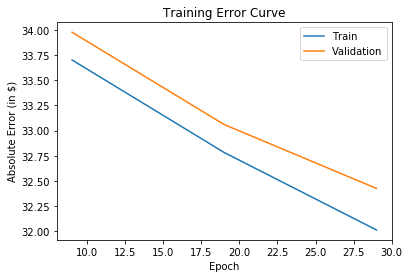

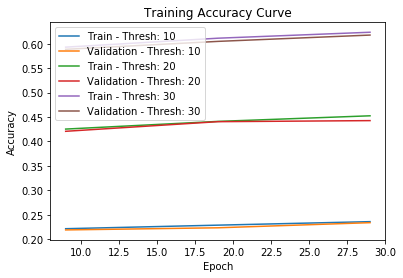

---[ITER 10] loss: 0.191259  time: 3.467
---[ITER 20] loss: 0.195394  time: 3.443
---[ITER 30] loss: 0.187342  time: 3.502
---[ITER 40] loss: 0.191063  time: 3.426
---[ITER 50] loss: 0.191906  time: 3.474
---[ITER 60] loss: 0.189791  time: 3.500
---[ITER 70] loss: 0.191700  time: 3.449
---[ITER 80] loss: 0.193279  time: 3.647
---[ITER 90] loss: 0.192825  time: 3.352
---[ITER 100] loss: 0.185920  time: 3.374
---[ITER 110] loss: 0.193125  time: 3.375
---[ITER 120] loss: 0.190331  time: 3.459
---[ITER 130] loss: 0.197387  time: 3.499
---[ITER 140] loss: 0.187112  time: 3.349
---[ITER 150] loss: 0.193180  time: 3.270
---[ITER 160] loss: 0.191369  time: 3.269
[EPOCH 31] loss: 0.191502  time: 57.421
---[ITER 10] loss: 0.191381  time: 3.275
---[ITER 20] loss: 0.186886  time: 3.374
---[ITER 30] loss: 0.191501  time: 3.338
---[ITER 40] loss: 0.190019  time: 3.300
---[ITER 50] loss: 0.196569  time: 3.414
---[ITER 60] loss: 0.185342  time: 3.353
---[ITER 70] loss: 0.187116  time: 3.401
---[ITER 8

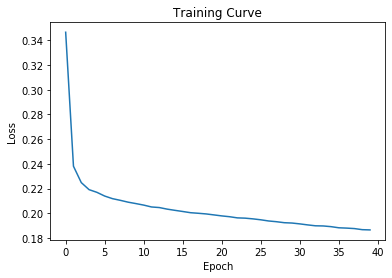

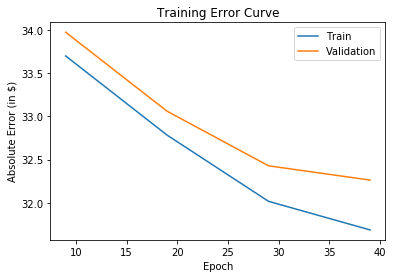

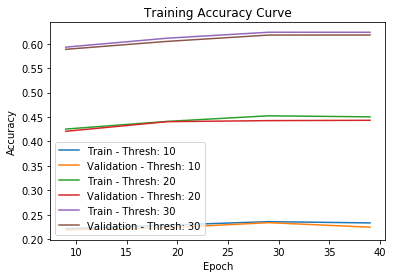

---[ITER 10] loss: 0.189674  time: 3.089
---[ITER 20] loss: 0.183491  time: 3.132
---[ITER 30] loss: 0.187896  time: 3.105
---[ITER 40] loss: 0.176641  time: 3.036
---[ITER 50] loss: 0.181457  time: 3.100
---[ITER 60] loss: 0.187112  time: 3.087
---[ITER 70] loss: 0.182638  time: 3.070
---[ITER 80] loss: 0.185381  time: 2.984
---[ITER 90] loss: 0.185898  time: 3.091
---[ITER 100] loss: 0.182897  time: 3.110
---[ITER 110] loss: 0.190292  time: 2.986
---[ITER 120] loss: 0.181062  time: 2.912
---[ITER 130] loss: 0.189252  time: 3.320
---[ITER 140] loss: 0.191502  time: 3.088
---[ITER 150] loss: 0.185971  time: 3.102
---[ITER 160] loss: 0.187439  time: 3.087
[EPOCH 41] loss: 0.185630  time: 51.713
---[ITER 10] loss: 0.184699  time: 3.086
---[ITER 20] loss: 0.181402  time: 3.103
---[ITER 30] loss: 0.184570  time: 3.140
---[ITER 40] loss: 0.181836  time: 3.091
---[ITER 50] loss: 0.191527  time: 3.123
---[ITER 60] loss: 0.180638  time: 3.117
---[ITER 70] loss: 0.189366  time: 3.081
---[ITER 8

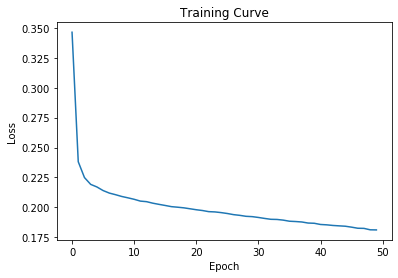

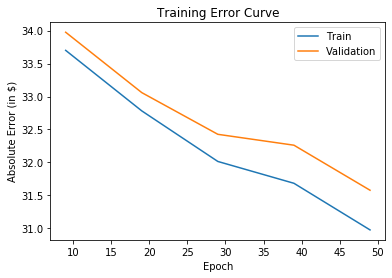

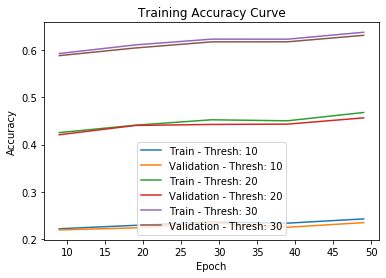

---[ITER 10] loss: 0.173999  time: 3.003
---[ITER 20] loss: 0.180289  time: 3.166
---[ITER 30] loss: 0.177743  time: 3.349
---[ITER 40] loss: 0.187203  time: 3.268
---[ITER 50] loss: 0.180561  time: 3.034
---[ITER 60] loss: 0.182016  time: 3.043
---[ITER 70] loss: 0.183942  time: 3.015
---[ITER 80] loss: 0.181022  time: 2.941
---[ITER 90] loss: 0.185884  time: 2.972
---[ITER 100] loss: 0.181617  time: 3.049
---[ITER 110] loss: 0.182418  time: 3.034
---[ITER 120] loss: 0.177742  time: 3.092
---[ITER 130] loss: 0.176137  time: 3.154
---[ITER 140] loss: 0.182139  time: 3.074
---[ITER 150] loss: 0.181881  time: 3.009
---[ITER 160] loss: 0.176569  time: 2.977
[EPOCH 51] loss: 0.180643  time: 51.465
---[ITER 10] loss: 0.181130  time: 3.054
---[ITER 20] loss: 0.178267  time: 3.014
---[ITER 30] loss: 0.177935  time: 3.033
---[ITER 40] loss: 0.176896  time: 3.054
---[ITER 50] loss: 0.183763  time: 3.119
---[ITER 60] loss: 0.181407  time: 3.342
---[ITER 70] loss: 0.185238  time: 3.059
---[ITER 8

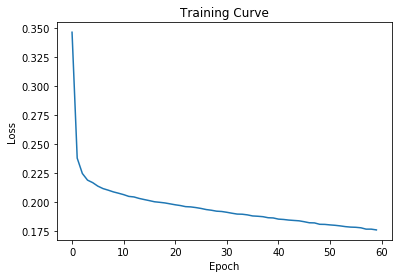

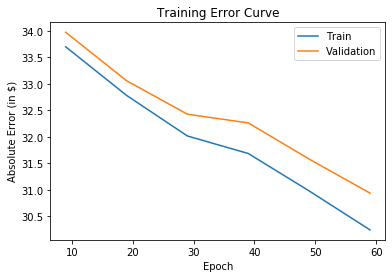

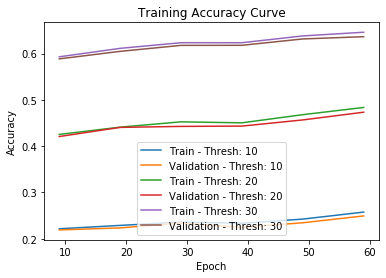

---[ITER 10] loss: 0.173563  time: 2.904
---[ITER 20] loss: 0.177569  time: 2.977
---[ITER 30] loss: 0.171661  time: 3.071
---[ITER 40] loss: 0.175280  time: 3.129
---[ITER 50] loss: 0.176488  time: 3.174
---[ITER 60] loss: 0.174931  time: 3.119
---[ITER 70] loss: 0.175109  time: 3.140
---[ITER 80] loss: 0.173763  time: 3.077
---[ITER 90] loss: 0.175393  time: 3.054
---[ITER 100] loss: 0.177426  time: 3.038
---[ITER 110] loss: 0.178622  time: 3.318
---[ITER 120] loss: 0.178788  time: 3.112
---[ITER 130] loss: 0.178063  time: 3.000
---[ITER 140] loss: 0.176660  time: 3.166
---[ITER 150] loss: 0.177311  time: 3.099
---[ITER 160] loss: 0.176932  time: 3.133
[EPOCH 61] loss: 0.176229  time: 51.878
---[ITER 10] loss: 0.173547  time: 3.167
---[ITER 20] loss: 0.175165  time: 3.095
---[ITER 30] loss: 0.177655  time: 3.027
---[ITER 40] loss: 0.175803  time: 2.953
---[ITER 50] loss: 0.170906  time: 2.986
---[ITER 60] loss: 0.171449  time: 3.097
---[ITER 70] loss: 0.177508  time: 3.064
---[ITER 8

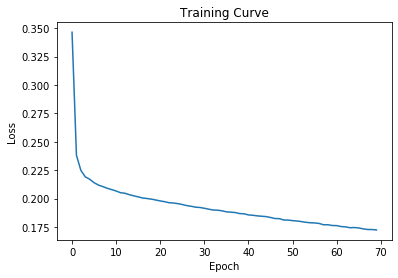

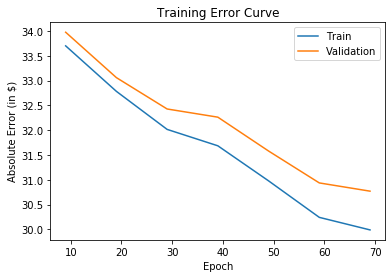

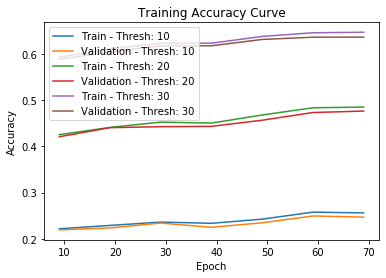

---[ITER 10] loss: 0.167567  time: 3.055
---[ITER 20] loss: 0.168442  time: 3.305
---[ITER 30] loss: 0.177166  time: 2.996
---[ITER 40] loss: 0.167618  time: 2.926
---[ITER 50] loss: 0.166772  time: 2.948
---[ITER 60] loss: 0.170415  time: 2.979
---[ITER 70] loss: 0.177111  time: 3.071
---[ITER 80] loss: 0.173785  time: 3.126
---[ITER 90] loss: 0.174954  time: 3.100
---[ITER 100] loss: 0.171471  time: 3.010
---[ITER 110] loss: 0.169778  time: 3.013
---[ITER 120] loss: 0.175225  time: 2.960
---[ITER 130] loss: 0.174012  time: 2.977
---[ITER 140] loss: 0.175945  time: 3.051
---[ITER 150] loss: 0.170709  time: 3.062
---[ITER 160] loss: 0.168222  time: 3.082
[EPOCH 71] loss: 0.171758  time: 51.029
---[ITER 10] loss: 0.170082  time: 3.091
---[ITER 20] loss: 0.167358  time: 3.213
---[ITER 30] loss: 0.174412  time: 3.339
---[ITER 40] loss: 0.168012  time: 3.106
---[ITER 50] loss: 0.172269  time: 3.359
---[ITER 60] loss: 0.178384  time: 3.120
---[ITER 70] loss: 0.166810  time: 3.107
---[ITER 8

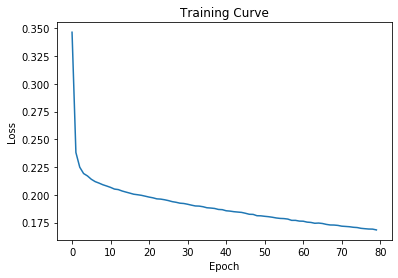

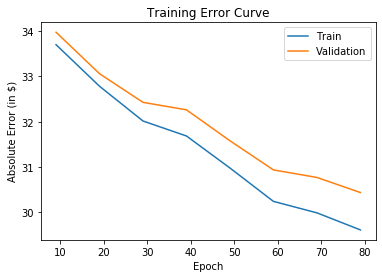

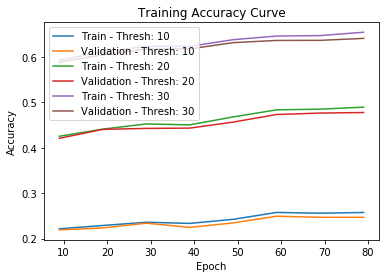

---[ITER 10] loss: 0.166539  time: 3.118
---[ITER 20] loss: 0.167063  time: 3.138
---[ITER 30] loss: 0.173279  time: 3.070
---[ITER 40] loss: 0.164558  time: 3.089
---[ITER 50] loss: 0.171261  time: 3.107
---[ITER 60] loss: 0.166985  time: 3.042
---[ITER 70] loss: 0.170361  time: 3.000
---[ITER 80] loss: 0.170810  time: 2.995
---[ITER 90] loss: 0.172053  time: 3.017
---[ITER 100] loss: 0.169089  time: 2.993
---[ITER 110] loss: 0.168957  time: 3.011
---[ITER 120] loss: 0.163781  time: 3.277
---[ITER 130] loss: 0.168480  time: 3.055
---[ITER 140] loss: 0.168387  time: 3.217
---[ITER 150] loss: 0.169657  time: 3.134
---[ITER 160] loss: 0.167491  time: 3.072
[EPOCH 81] loss: 0.168339  time: 51.688
---[ITER 10] loss: 0.170815  time: 3.135
---[ITER 20] loss: 0.171127  time: 3.046
---[ITER 30] loss: 0.164895  time: 3.017
---[ITER 40] loss: 0.171872  time: 3.089
---[ITER 50] loss: 0.164716  time: 3.035
---[ITER 60] loss: 0.163508  time: 2.970
---[ITER 70] loss: 0.167555  time: 2.938
---[ITER 8

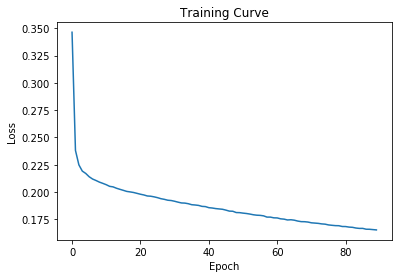

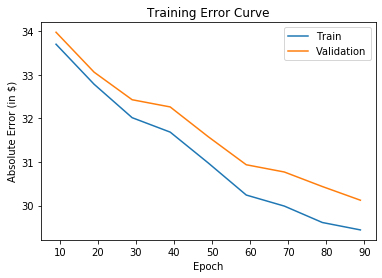

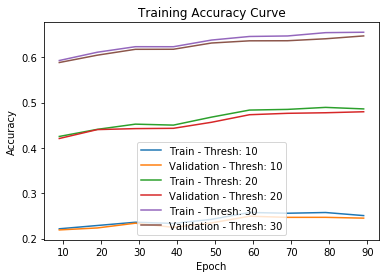

---[ITER 10] loss: 0.164358  time: 3.073
---[ITER 20] loss: 0.165419  time: 3.390
---[ITER 30] loss: 0.162845  time: 3.213
---[ITER 40] loss: 0.166112  time: 3.117
---[ITER 50] loss: 0.169932  time: 3.111
---[ITER 60] loss: 0.161156  time: 3.105
---[ITER 70] loss: 0.166202  time: 2.939
---[ITER 80] loss: 0.163892  time: 2.941
---[ITER 90] loss: 0.164011  time: 3.051
---[ITER 100] loss: 0.163046  time: 3.013
---[ITER 110] loss: 0.164052  time: 3.007
---[ITER 120] loss: 0.162271  time: 3.077
---[ITER 130] loss: 0.162352  time: 3.114
---[ITER 140] loss: 0.167034  time: 3.112
---[ITER 150] loss: 0.162796  time: 3.110
---[ITER 160] loss: 0.166576  time: 3.101
[EPOCH 91] loss: 0.164747  time: 51.872
---[ITER 10] loss: 0.157450  time: 3.156
---[ITER 20] loss: 0.165406  time: 3.181
---[ITER 30] loss: 0.170948  time: 3.111
---[ITER 40] loss: 0.162328  time: 3.123
---[ITER 50] loss: 0.163563  time: 3.366
---[ITER 60] loss: 0.158682  time: 3.083
---[ITER 70] loss: 0.168800  time: 2.968
---[ITER 8

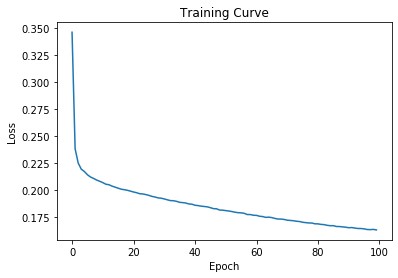

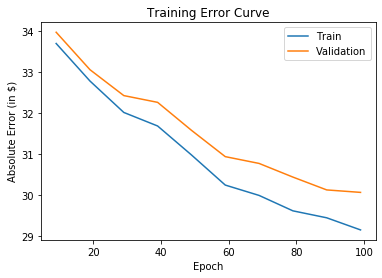

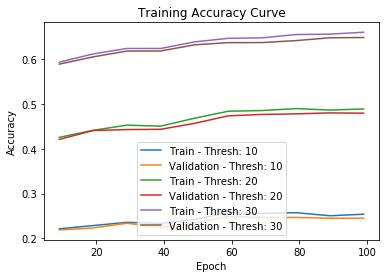

---[ITER 10] loss: 0.162635  time: 2.959
---[ITER 20] loss: 0.166014  time: 2.956
---[ITER 30] loss: 0.166903  time: 3.048
---[ITER 40] loss: 0.160281  time: 3.230
---[ITER 50] loss: 0.164865  time: 3.037
---[ITER 60] loss: 0.162902  time: 3.096
---[ITER 70] loss: 0.159737  time: 3.487
---[ITER 80] loss: 0.159198  time: 3.105
---[ITER 90] loss: 0.162844  time: 3.077
---[ITER 100] loss: 0.158767  time: 3.128
---[ITER 110] loss: 0.161272  time: 3.080
---[ITER 120] loss: 0.162866  time: 3.093
---[ITER 130] loss: 0.163198  time: 3.077
---[ITER 140] loss: 0.163221  time: 3.090
---[ITER 150] loss: 0.163598  time: 3.031
---[ITER 160] loss: 0.165185  time: 2.965
[EPOCH 101] loss: 0.162720  time: 51.799
---[ITER 10] loss: 0.158147  time: 3.080
---[ITER 20] loss: 0.164998  time: 3.111
---[ITER 30] loss: 0.162160  time: 3.012
---[ITER 40] loss: 0.164990  time: 3.031
---[ITER 50] loss: 0.166094  time: 3.024
---[ITER 60] loss: 0.160464  time: 3.112
---[ITER 70] loss: 0.163819  time: 3.024
---[ITER 

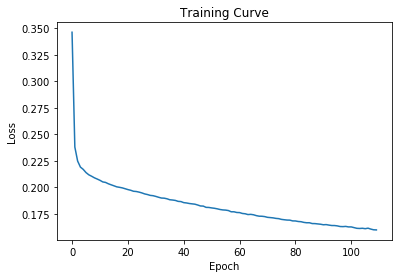

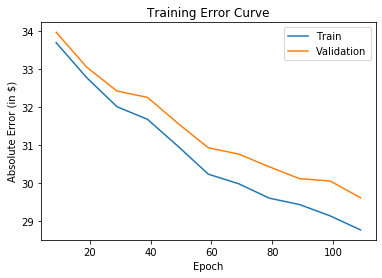

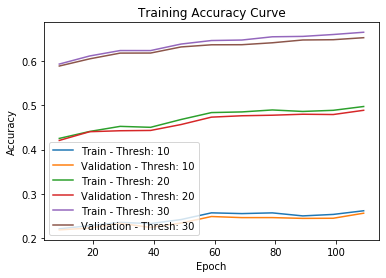

---[ITER 10] loss: 0.159988  time: 3.006
---[ITER 20] loss: 0.166332  time: 3.086
---[ITER 30] loss: 0.164385  time: 3.164
---[ITER 40] loss: 0.157250  time: 3.083
---[ITER 50] loss: 0.155658  time: 2.952
---[ITER 60] loss: 0.160465  time: 2.992
---[ITER 70] loss: 0.159633  time: 2.931
---[ITER 80] loss: 0.161415  time: 2.937
---[ITER 90] loss: 0.162660  time: 3.001
---[ITER 100] loss: 0.164973  time: 3.041
---[ITER 110] loss: 0.161174  time: 3.158
---[ITER 120] loss: 0.158225  time: 3.118
---[ITER 130] loss: 0.155962  time: 3.413
---[ITER 140] loss: 0.155712  time: 3.141
---[ITER 150] loss: 0.154652  time: 2.986
---[ITER 160] loss: 0.157891  time: 2.981
[EPOCH 111] loss: 0.159758  time: 51.586
---[ITER 10] loss: 0.159928  time: 3.072
---[ITER 20] loss: 0.159319  time: 2.995
---[ITER 30] loss: 0.156032  time: 2.969
---[ITER 40] loss: 0.161513  time: 3.039
---[ITER 50] loss: 0.163332  time: 3.119
---[ITER 60] loss: 0.157041  time: 3.096
---[ITER 70] loss: 0.163471  time: 3.077
---[ITER 

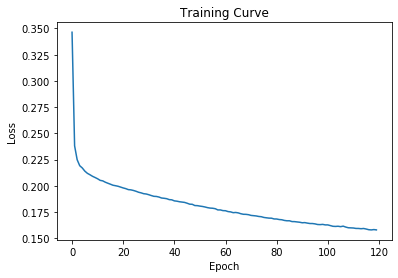

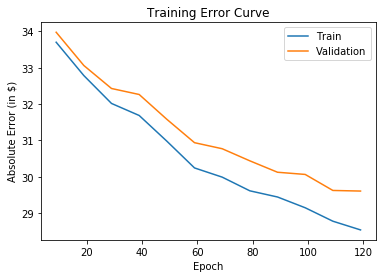

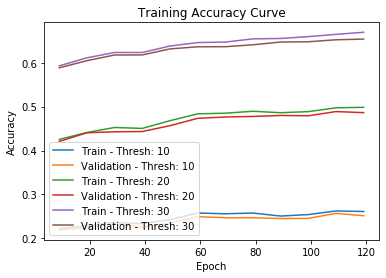

---[ITER 10] loss: 0.159446  time: 3.131
---[ITER 20] loss: 0.164117  time: 3.088
---[ITER 30] loss: 0.157811  time: 3.843
---[ITER 40] loss: 0.152876  time: 3.376
---[ITER 50] loss: 0.155152  time: 3.046
---[ITER 60] loss: 0.162727  time: 3.103
---[ITER 70] loss: 0.156705  time: 3.396
---[ITER 80] loss: 0.156556  time: 3.117
---[ITER 90] loss: 0.154134  time: 3.116
---[ITER 100] loss: 0.154516  time: 3.143
---[ITER 110] loss: 0.156843  time: 3.038
---[ITER 120] loss: 0.160087  time: 3.013
---[ITER 130] loss: 0.154795  time: 2.960
---[ITER 140] loss: 0.153559  time: 3.104
---[ITER 150] loss: 0.158040  time: 3.077
---[ITER 160] loss: 0.155311  time: 3.063
[EPOCH 121] loss: 0.157071  time: 53.033
---[ITER 10] loss: 0.165145  time: 3.022
---[ITER 20] loss: 0.156966  time: 3.110
---[ITER 30] loss: 0.153681  time: 3.212
---[ITER 40] loss: 0.154143  time: 3.076
---[ITER 50] loss: 0.160947  time: 3.016
---[ITER 60] loss: 0.157014  time: 3.060
---[ITER 70] loss: 0.159381  time: 3.035
---[ITER 

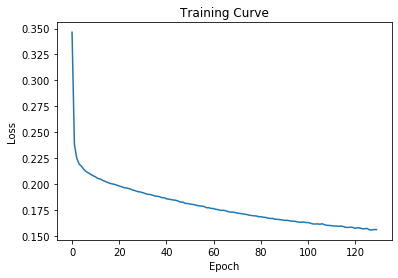

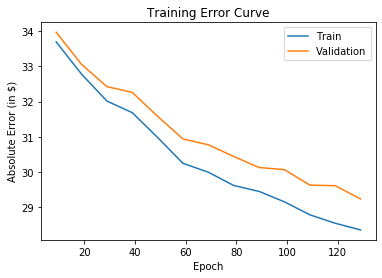

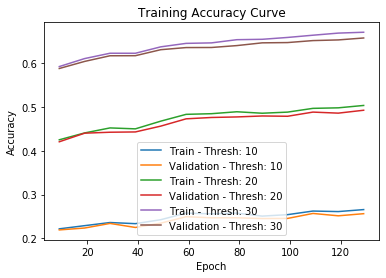

---[ITER 10] loss: 0.156135  time: 3.010
---[ITER 20] loss: 0.157860  time: 3.160
---[ITER 30] loss: 0.152004  time: 3.129
---[ITER 40] loss: 0.151462  time: 3.108
---[ITER 50] loss: 0.154511  time: 3.041
---[ITER 60] loss: 0.155670  time: 3.014
---[ITER 70] loss: 0.152404  time: 2.969
---[ITER 80] loss: 0.156171  time: 2.979
---[ITER 90] loss: 0.150997  time: 2.934
---[ITER 100] loss: 0.152719  time: 2.961
---[ITER 110] loss: 0.158393  time: 2.915
---[ITER 120] loss: 0.151968  time: 2.904
---[ITER 130] loss: 0.159895  time: 2.946
---[ITER 140] loss: 0.153264  time: 3.023
---[ITER 150] loss: 0.152888  time: 2.994
---[ITER 160] loss: 0.162721  time: 3.114
[EPOCH 131] loss: 0.155114  time: 50.752
---[ITER 10] loss: 0.159002  time: 3.113
---[ITER 20] loss: 0.150899  time: 3.135
---[ITER 30] loss: 0.155394  time: 3.070
---[ITER 40] loss: 0.155002  time: 3.045
---[ITER 50] loss: 0.151184  time: 2.999
---[ITER 60] loss: 0.152941  time: 2.978
---[ITER 70] loss: 0.158783  time: 3.040
---[ITER 

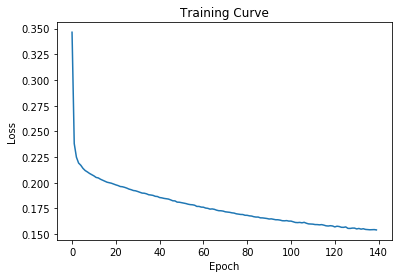

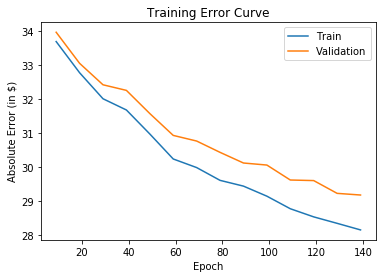

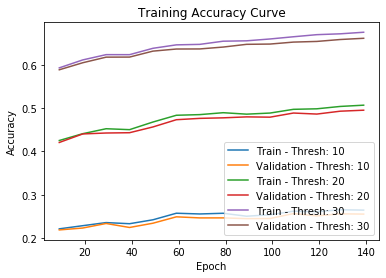

---[ITER 10] loss: 0.153401  time: 3.031
---[ITER 20] loss: 0.151616  time: 2.973
---[ITER 30] loss: 0.152850  time: 3.139
---[ITER 40] loss: 0.154075  time: 3.187
---[ITER 50] loss: 0.150797  time: 3.230
---[ITER 60] loss: 0.152562  time: 3.110
---[ITER 70] loss: 0.155333  time: 3.294
---[ITER 80] loss: 0.153982  time: 3.022
---[ITER 90] loss: 0.154835  time: 2.942
---[ITER 100] loss: 0.150482  time: 2.925
---[ITER 110] loss: 0.152634  time: 2.927
---[ITER 120] loss: 0.157851  time: 2.939
---[ITER 130] loss: 0.151703  time: 2.949
---[ITER 140] loss: 0.159704  time: 3.067
---[ITER 150] loss: 0.150030  time: 3.099
---[ITER 160] loss: 0.151581  time: 3.086
[EPOCH 141] loss: 0.153338  time: 51.265
---[ITER 10] loss: 0.147034  time: 3.102
---[ITER 20] loss: 0.152712  time: 3.081
---[ITER 30] loss: 0.156610  time: 2.958
---[ITER 40] loss: 0.151320  time: 2.937
---[ITER 50] loss: 0.152348  time: 2.939
---[ITER 60] loss: 0.149065  time: 3.030
---[ITER 70] loss: 0.155538  time: 3.111
---[ITER 

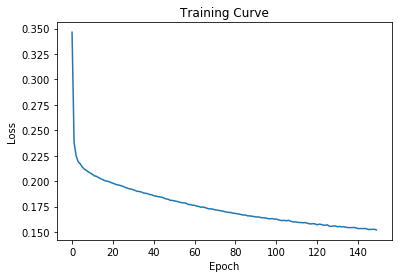

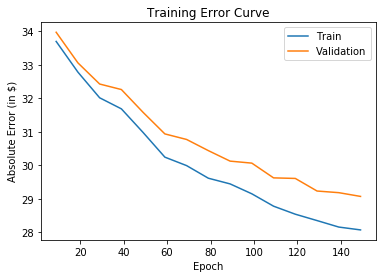

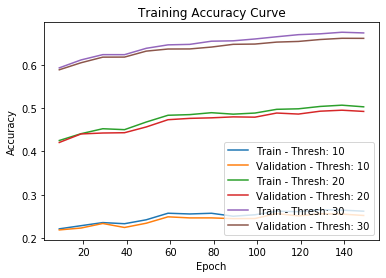

---[ITER 10] loss: 0.150847  time: 3.108
---[ITER 20] loss: 0.154918  time: 3.110
---[ITER 30] loss: 0.149066  time: 3.044
---[ITER 40] loss: 0.151785  time: 2.958
---[ITER 50] loss: 0.151726  time: 2.899
---[ITER 60] loss: 0.149087  time: 3.175
---[ITER 70] loss: 0.150767  time: 3.007
---[ITER 80] loss: 0.154030  time: 3.111
---[ITER 90] loss: 0.151216  time: 3.188
---[ITER 100] loss: 0.154228  time: 3.116
---[ITER 110] loss: 0.153715  time: 3.070
---[ITER 120] loss: 0.156255  time: 3.119
---[ITER 130] loss: 0.152479  time: 3.090
---[ITER 140] loss: 0.155318  time: 3.099
---[ITER 150] loss: 0.154217  time: 3.120
---[ITER 160] loss: 0.147398  time: 3.128
[EPOCH 151] loss: 0.152222  time: 51.802
---[ITER 10] loss: 0.154484  time: 3.331
---[ITER 20] loss: 0.153235  time: 3.118
---[ITER 30] loss: 0.156165  time: 3.038
---[ITER 40] loss: 0.157584  time: 2.967
---[ITER 50] loss: 0.153758  time: 2.958
---[ITER 60] loss: 0.153894  time: 2.952
---[ITER 70] loss: 0.153342  time: 3.041
---[ITER 

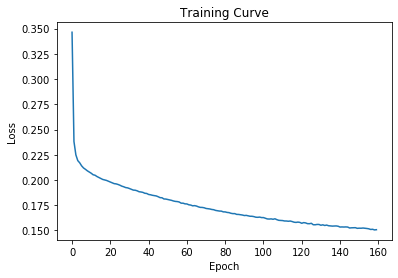

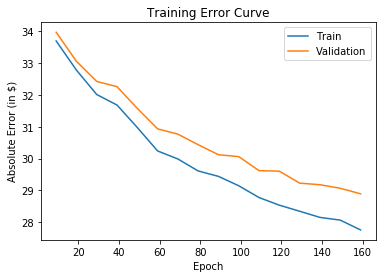

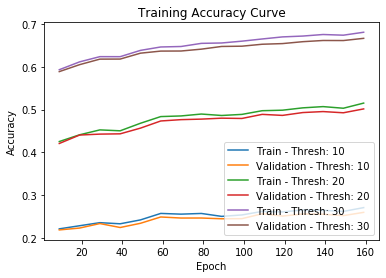

---[ITER 10] loss: 0.153093  time: 2.982
---[ITER 20] loss: 0.159309  time: 2.992
---[ITER 30] loss: 0.152982  time: 3.061
---[ITER 40] loss: 0.148836  time: 3.103
---[ITER 50] loss: 0.146644  time: 3.215
---[ITER 60] loss: 0.148479  time: 3.151
---[ITER 70] loss: 0.149856  time: 3.139
---[ITER 80] loss: 0.154369  time: 3.491
---[ITER 90] loss: 0.148135  time: 3.198
---[ITER 100] loss: 0.151800  time: 3.092
---[ITER 110] loss: 0.152525  time: 3.112
---[ITER 120] loss: 0.149562  time: 3.136
---[ITER 130] loss: 0.150845  time: 3.323
---[ITER 140] loss: 0.149018  time: 3.317
---[ITER 150] loss: 0.153529  time: 3.080
---[ITER 160] loss: 0.150570  time: 3.144
[EPOCH 161] loss: 0.151170  time: 52.920
---[ITER 10] loss: 0.149606  time: 3.100
---[ITER 20] loss: 0.152019  time: 3.143
---[ITER 30] loss: 0.146366  time: 3.093
---[ITER 40] loss: 0.146235  time: 3.134
---[ITER 50] loss: 0.150621  time: 3.060
---[ITER 60] loss: 0.147458  time: 2.968
---[ITER 70] loss: 0.152288  time: 3.053
---[ITER 

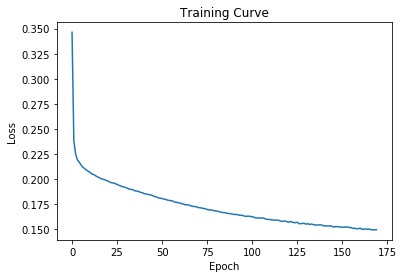

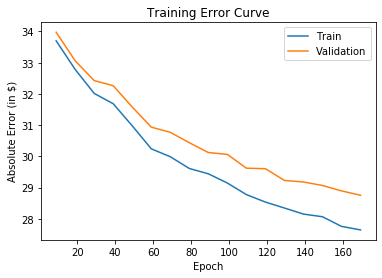

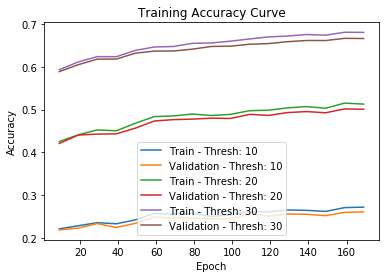

---[ITER 10] loss: 0.147556  time: 3.103
---[ITER 20] loss: 0.150874  time: 3.102
---[ITER 30] loss: 0.148623  time: 2.885
---[ITER 40] loss: 0.155782  time: 2.933
---[ITER 50] loss: 0.150123  time: 2.910
---[ITER 60] loss: 0.143189  time: 2.921
---[ITER 70] loss: 0.151832  time: 2.902
---[ITER 80] loss: 0.140976  time: 2.948
---[ITER 90] loss: 0.145292  time: 3.007
---[ITER 100] loss: 0.149593  time: 3.082
---[ITER 110] loss: 0.148963  time: 3.056
---[ITER 120] loss: 0.150934  time: 3.083
---[ITER 130] loss: 0.148571  time: 3.061
---[ITER 140] loss: 0.150386  time: 3.136
---[ITER 150] loss: 0.151544  time: 3.107
---[ITER 160] loss: 0.152994  time: 3.118
[EPOCH 171] loss: 0.149156  time: 50.707
---[ITER 10] loss: 0.148666  time: 3.067
---[ITER 20] loss: 0.146767  time: 3.303
---[ITER 30] loss: 0.148030  time: 2.948
---[ITER 40] loss: 0.140900  time: 3.063
---[ITER 50] loss: 0.144118  time: 3.157
---[ITER 60] loss: 0.147908  time: 3.354
---[ITER 70] loss: 0.152182  time: 3.074
---[ITER 

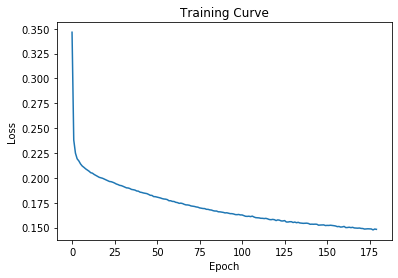

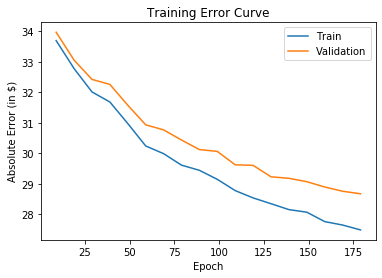

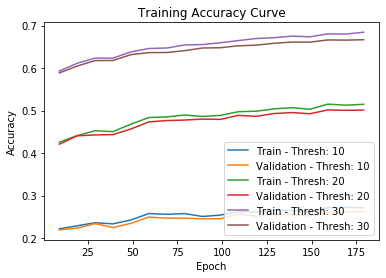

---[ITER 10] loss: 0.149189  time: 3.014
---[ITER 20] loss: 0.151420  time: 3.115
---[ITER 30] loss: 0.151234  time: 3.155
---[ITER 40] loss: 0.149314  time: 3.127
---[ITER 50] loss: 0.142582  time: 3.026
---[ITER 60] loss: 0.149021  time: 2.981
---[ITER 70] loss: 0.148928  time: 3.115
---[ITER 80] loss: 0.150062  time: 3.114
---[ITER 90] loss: 0.151491  time: 3.004
---[ITER 100] loss: 0.145202  time: 2.985
---[ITER 110] loss: 0.146325  time: 3.033
---[ITER 120] loss: 0.145413  time: 2.997
---[ITER 130] loss: 0.147898  time: 3.087
---[ITER 140] loss: 0.145165  time: 3.162
---[ITER 150] loss: 0.149584  time: 3.085
---[ITER 160] loss: 0.148797  time: 3.059
[EPOCH 181] loss: 0.148232  time: 51.393
---[ITER 10] loss: 0.148223  time: 3.059
---[ITER 20] loss: 0.143357  time: 2.969
---[ITER 30] loss: 0.146480  time: 2.944
---[ITER 40] loss: 0.145371  time: 2.978
---[ITER 50] loss: 0.147221  time: 3.030
---[ITER 60] loss: 0.148600  time: 3.076
---[ITER 70] loss: 0.147974  time: 3.090
---[ITER 

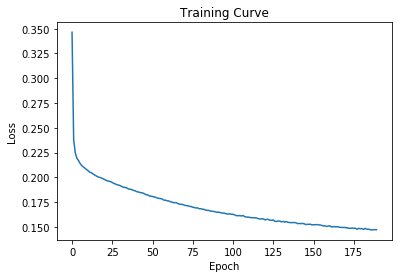

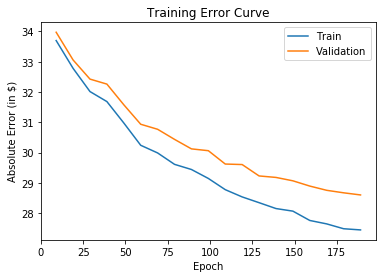

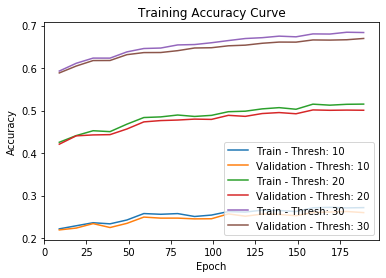

---[ITER 10] loss: 0.147677  time: 3.000
---[ITER 20] loss: 0.144222  time: 3.005
---[ITER 30] loss: 0.147413  time: 3.143
---[ITER 40] loss: 0.144841  time: 3.106
---[ITER 50] loss: 0.146525  time: 3.133
---[ITER 60] loss: 0.144926  time: 3.109
---[ITER 70] loss: 0.145711  time: 3.135
---[ITER 80] loss: 0.146907  time: 3.097
---[ITER 90] loss: 0.143647  time: 2.909
---[ITER 100] loss: 0.149319  time: 2.957
---[ITER 110] loss: 0.152587  time: 2.938
---[ITER 120] loss: 0.149958  time: 2.978
---[ITER 130] loss: 0.140917  time: 3.067
---[ITER 140] loss: 0.149657  time: 3.159
---[ITER 150] loss: 0.147389  time: 3.155
---[ITER 160] loss: 0.147916  time: 3.121
[EPOCH 191] loss: 0.146791  time: 51.629
---[ITER 10] loss: 0.142775  time: 3.123
---[ITER 20] loss: 0.147229  time: 3.161
---[ITER 30] loss: 0.142974  time: 3.131
---[ITER 40] loss: 0.147029  time: 3.097
---[ITER 50] loss: 0.151047  time: 3.148
---[ITER 60] loss: 0.146845  time: 3.082
---[ITER 70] loss: 0.142202  time: 3.044
---[ITER 

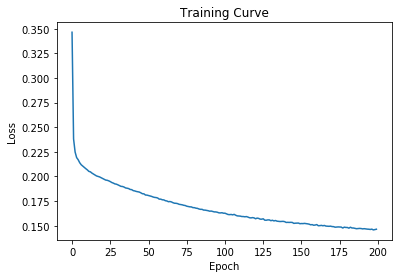

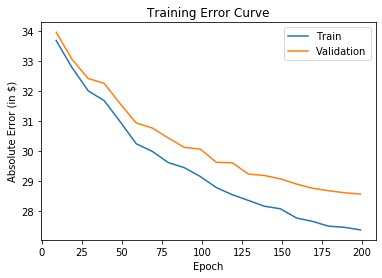

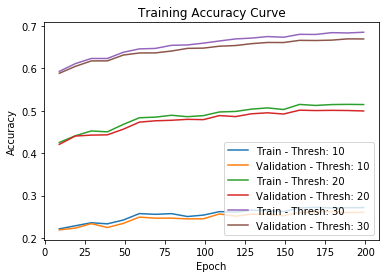

---[ITER 10] loss: 0.144020  time: 3.088
---[ITER 20] loss: 0.144941  time: 2.980
---[ITER 30] loss: 0.146603  time: 2.905
---[ITER 40] loss: 0.143805  time: 2.891
---[ITER 50] loss: 0.148444  time: 3.075
---[ITER 60] loss: 0.144786  time: 3.228
---[ITER 70] loss: 0.141960  time: 3.014
---[ITER 80] loss: 0.145534  time: 3.290
---[ITER 90] loss: 0.144535  time: 3.090
---[ITER 100] loss: 0.148865  time: 2.994
---[ITER 110] loss: 0.147049  time: 2.975
---[ITER 120] loss: 0.144687  time: 3.045
---[ITER 130] loss: 0.147437  time: 3.054
---[ITER 140] loss: 0.148078  time: 3.002
---[ITER 150] loss: 0.145553  time: 2.971
---[ITER 160] loss: 0.147358  time: 2.919
[EPOCH 201] loss: 0.146000  time: 50.749
---[ITER 10] loss: 0.142275  time: 2.990
---[ITER 20] loss: 0.145301  time: 2.905
---[ITER 30] loss: 0.142951  time: 2.888
---[ITER 40] loss: 0.145169  time: 2.944
---[ITER 50] loss: 0.144873  time: 2.912
---[ITER 60] loss: 0.139080  time: 2.868
---[ITER 70] loss: 0.145872  time: 2.976
---[ITER 

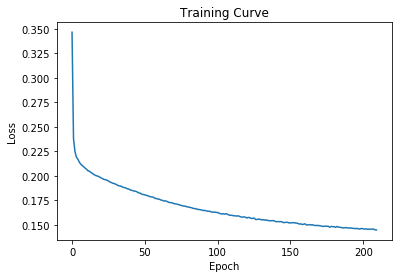

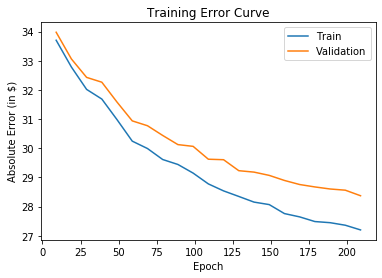

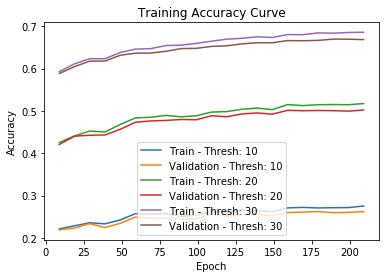

---[ITER 10] loss: 0.148633  time: 2.931
---[ITER 20] loss: 0.148532  time: 3.284
---[ITER 30] loss: 0.146388  time: 3.080
---[ITER 40] loss: 0.143363  time: 3.025
---[ITER 50] loss: 0.145574  time: 3.025
---[ITER 60] loss: 0.141431  time: 2.956
---[ITER 70] loss: 0.148482  time: 3.018
---[ITER 80] loss: 0.141607  time: 3.046
---[ITER 90] loss: 0.144646  time: 3.047
---[ITER 100] loss: 0.141955  time: 2.997
---[ITER 110] loss: 0.144749  time: 2.881
---[ITER 120] loss: 0.147057  time: 2.974
---[ITER 130] loss: 0.143522  time: 2.981
---[ITER 140] loss: 0.142931  time: 3.003
---[ITER 150] loss: 0.149417  time: 3.046
---[ITER 160] loss: 0.141208  time: 2.942
[EPOCH 211] loss: 0.144997  time: 50.524
---[ITER 10] loss: 0.145945  time: 3.045
---[ITER 20] loss: 0.145196  time: 3.348
---[ITER 30] loss: 0.147087  time: 3.030
---[ITER 40] loss: 0.146885  time: 2.980
---[ITER 50] loss: 0.142421  time: 3.148
---[ITER 60] loss: 0.142046  time: 2.923
---[ITER 70] loss: 0.146684  time: 2.904
---[ITER 

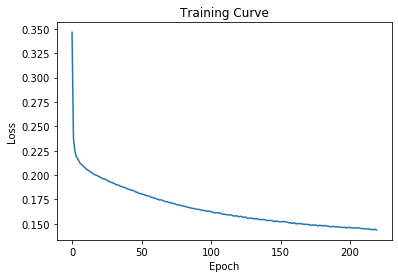

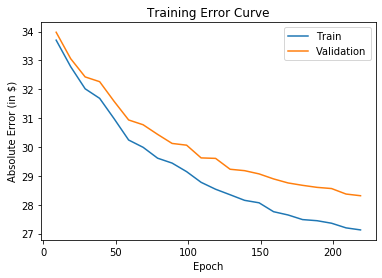

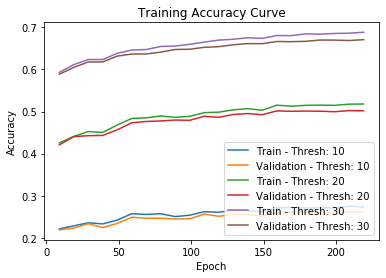

---[ITER 10] loss: 0.141640  time: 3.070
---[ITER 20] loss: 0.145529  time: 2.995
---[ITER 30] loss: 0.140374  time: 2.956
---[ITER 40] loss: 0.140893  time: 2.981
---[ITER 50] loss: 0.145455  time: 3.045
---[ITER 60] loss: 0.141791  time: 2.971
---[ITER 70] loss: 0.140970  time: 3.042
---[ITER 80] loss: 0.145911  time: 2.996
---[ITER 90] loss: 0.146888  time: 3.022
---[ITER 100] loss: 0.142479  time: 3.020
---[ITER 110] loss: 0.145449  time: 3.012
---[ITER 120] loss: 0.143830  time: 3.000
---[ITER 130] loss: 0.142184  time: 3.032
---[ITER 140] loss: 0.146582  time: 2.974
---[ITER 150] loss: 0.148274  time: 2.918
---[ITER 160] loss: 0.145937  time: 3.209
[EPOCH 221] loss: 0.143897  time: 50.466
---[ITER 10] loss: 0.143368  time: 2.920
---[ITER 20] loss: 0.141587  time: 2.942
---[ITER 30] loss: 0.145890  time: 2.927
---[ITER 40] loss: 0.141723  time: 3.036
---[ITER 50] loss: 0.142288  time: 3.014
---[ITER 60] loss: 0.146144  time: 3.000
---[ITER 70] loss: 0.140148  time: 3.095
---[ITER 

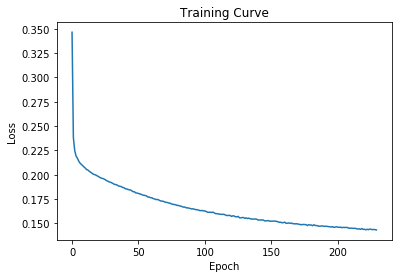

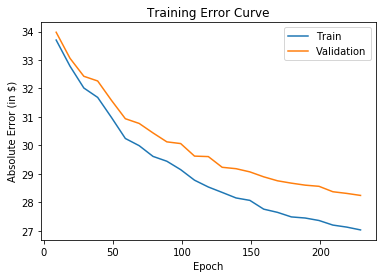

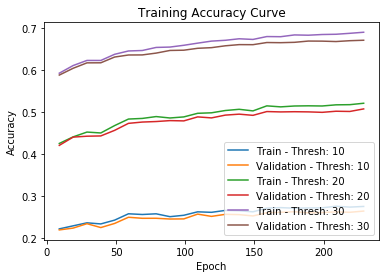

---[ITER 10] loss: 0.143150  time: 3.008
---[ITER 20] loss: 0.137946  time: 3.000
---[ITER 30] loss: 0.148356  time: 3.231
---[ITER 40] loss: 0.144745  time: 3.002
---[ITER 50] loss: 0.140681  time: 3.028
---[ITER 60] loss: 0.145094  time: 3.141
---[ITER 70] loss: 0.146936  time: 3.027
---[ITER 80] loss: 0.143680  time: 3.002
---[ITER 90] loss: 0.140693  time: 2.932
---[ITER 100] loss: 0.144290  time: 2.951
---[ITER 110] loss: 0.143273  time: 3.212
---[ITER 120] loss: 0.141953  time: 3.048
---[ITER 130] loss: 0.142732  time: 3.022
---[ITER 140] loss: 0.140022  time: 3.089
---[ITER 150] loss: 0.139373  time: 2.953
---[ITER 160] loss: 0.142073  time: 2.927
[EPOCH 231] loss: 0.142741  time: 50.811
---[ITER 10] loss: 0.142358  time: 2.966
---[ITER 20] loss: 0.148494  time: 3.013
---[ITER 30] loss: 0.146862  time: 3.002
---[ITER 40] loss: 0.143431  time: 3.047
---[ITER 50] loss: 0.139177  time: 3.085
---[ITER 60] loss: 0.138203  time: 2.973
---[ITER 70] loss: 0.143477  time: 2.903
---[ITER 

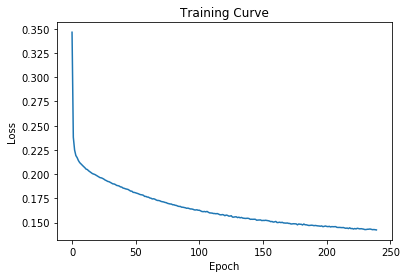

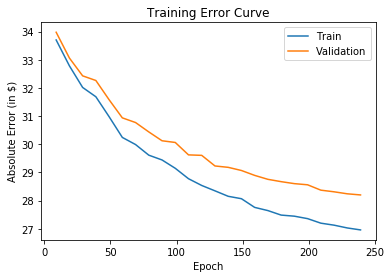

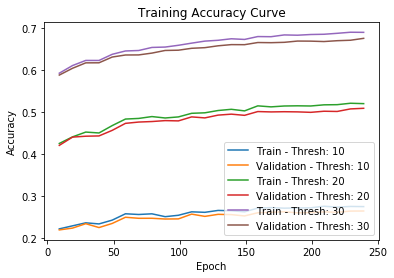

---[ITER 10] loss: 0.144673  time: 2.969
---[ITER 20] loss: 0.143969  time: 2.993
---[ITER 30] loss: 0.140756  time: 3.040
---[ITER 40] loss: 0.141103  time: 3.016
---[ITER 50] loss: 0.138881  time: 3.303
---[ITER 60] loss: 0.142864  time: 2.984
---[ITER 70] loss: 0.142283  time: 2.987
---[ITER 80] loss: 0.142436  time: 2.962
---[ITER 90] loss: 0.143188  time: 2.985
---[ITER 100] loss: 0.138894  time: 2.864
---[ITER 110] loss: 0.141079  time: 2.909
---[ITER 120] loss: 0.142804  time: 2.926
---[ITER 130] loss: 0.141560  time: 2.974
---[ITER 140] loss: 0.145265  time: 3.055
---[ITER 150] loss: 0.144030  time: 3.038
---[ITER 160] loss: 0.142252  time: 3.204
[EPOCH 241] loss: 0.142488  time: 50.597
---[ITER 10] loss: 0.147877  time: 2.944
---[ITER 20] loss: 0.141988  time: 3.074
---[ITER 30] loss: 0.140474  time: 2.949
---[ITER 40] loss: 0.146739  time: 3.006
---[ITER 50] loss: 0.139111  time: 3.126
---[ITER 60] loss: 0.145931  time: 3.087
---[ITER 70] loss: 0.136701  time: 3.034
---[ITER 

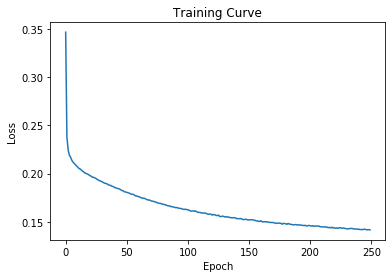

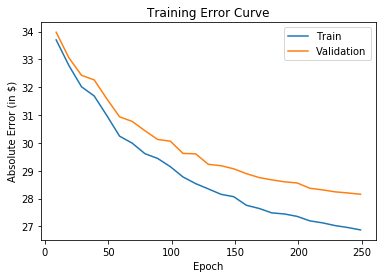

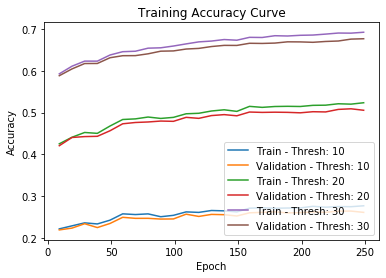

---[ITER 10] loss: 0.141365  time: 3.031
---[ITER 20] loss: 0.136069  time: 3.044
---[ITER 30] loss: 0.146338  time: 2.991
---[ITER 40] loss: 0.143711  time: 2.942
---[ITER 50] loss: 0.140982  time: 2.928
---[ITER 60] loss: 0.143705  time: 2.904
---[ITER 70] loss: 0.143257  time: 2.906
---[ITER 80] loss: 0.145623  time: 2.888
---[ITER 90] loss: 0.146043  time: 2.900
---[ITER 100] loss: 0.134542  time: 2.925
---[ITER 110] loss: 0.144571  time: 2.948
---[ITER 120] loss: 0.136401  time: 2.964
---[ITER 130] loss: 0.139708  time: 2.960
---[ITER 140] loss: 0.143154  time: 2.988
---[ITER 150] loss: 0.144155  time: 2.937
---[ITER 160] loss: 0.141996  time: 2.960
[EPOCH 251] loss: 0.141905  time: 49.557
---[ITER 10] loss: 0.137885  time: 2.980
---[ITER 20] loss: 0.140056  time: 2.929
---[ITER 30] loss: 0.144397  time: 3.129
---[ITER 40] loss: 0.143293  time: 2.883
---[ITER 50] loss: 0.142715  time: 2.947
---[ITER 60] loss: 0.140848  time: 2.891
---[ITER 70] loss: 0.139578  time: 2.901
---[ITER 

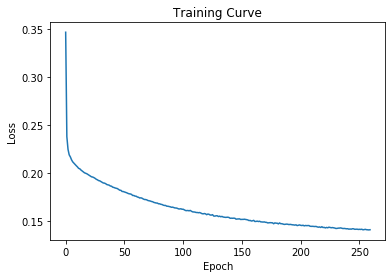

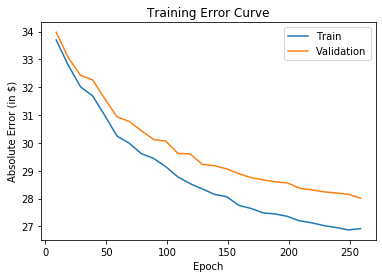

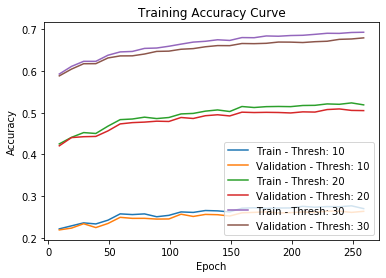

---[ITER 10] loss: 0.141875  time: 2.993
---[ITER 20] loss: 0.139860  time: 3.158
---[ITER 30] loss: 0.144966  time: 2.976
---[ITER 40] loss: 0.144082  time: 2.942
---[ITER 50] loss: 0.142258  time: 2.951
---[ITER 60] loss: 0.139243  time: 2.936
---[ITER 70] loss: 0.139813  time: 2.909
---[ITER 80] loss: 0.141001  time: 2.934
---[ITER 90] loss: 0.136571  time: 2.959
---[ITER 100] loss: 0.141474  time: 3.043
---[ITER 110] loss: 0.137371  time: 3.011
---[ITER 120] loss: 0.138727  time: 3.074
---[ITER 130] loss: 0.139866  time: 3.024
---[ITER 140] loss: 0.145525  time: 3.058
---[ITER 150] loss: 0.143354  time: 3.120
---[ITER 160] loss: 0.144886  time: 3.072
[EPOCH 261] loss: 0.141131  time: 50.417
---[ITER 10] loss: 0.143049  time: 2.923
---[ITER 20] loss: 0.138266  time: 2.908
---[ITER 30] loss: 0.141475  time: 2.908
---[ITER 40] loss: 0.143254  time: 2.896
---[ITER 50] loss: 0.143040  time: 2.883
---[ITER 60] loss: 0.143532  time: 2.915
---[ITER 70] loss: 0.138026  time: 2.885
---[ITER 

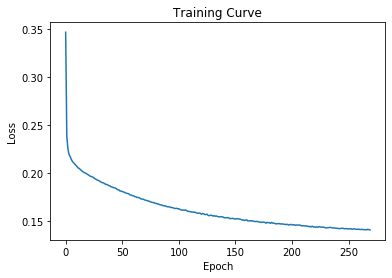

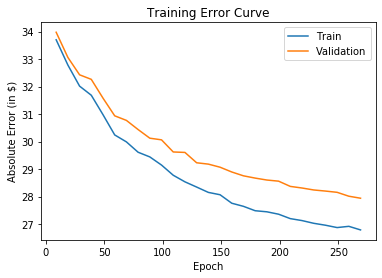

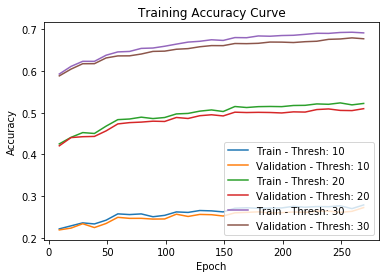

---[ITER 10] loss: 0.137820  time: 2.995
---[ITER 20] loss: 0.144047  time: 3.033
---[ITER 30] loss: 0.140191  time: 3.047
---[ITER 40] loss: 0.144253  time: 2.999
---[ITER 50] loss: 0.141387  time: 2.967
---[ITER 60] loss: 0.140785  time: 2.956
---[ITER 70] loss: 0.141183  time: 2.959
---[ITER 80] loss: 0.137788  time: 2.925
---[ITER 90] loss: 0.139252  time: 2.873
---[ITER 100] loss: 0.141939  time: 3.156
---[ITER 110] loss: 0.140897  time: 2.899
---[ITER 120] loss: 0.142261  time: 2.903
---[ITER 130] loss: 0.133486  time: 2.994
---[ITER 140] loss: 0.137111  time: 3.024
---[ITER 150] loss: 0.145286  time: 3.290
---[ITER 160] loss: 0.142499  time: 3.028
[EPOCH 271] loss: 0.140712  time: 50.363
---[ITER 10] loss: 0.139717  time: 3.133
---[ITER 20] loss: 0.141427  time: 3.026
---[ITER 30] loss: 0.144884  time: 2.892
---[ITER 40] loss: 0.139282  time: 2.886
---[ITER 50] loss: 0.140797  time: 3.021
---[ITER 60] loss: 0.138715  time: 2.988
---[ITER 70] loss: 0.140208  time: 3.016
---[ITER 

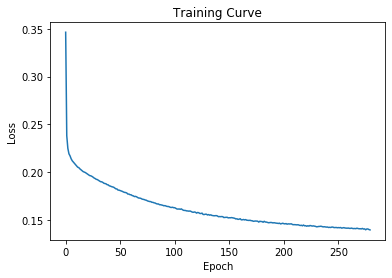

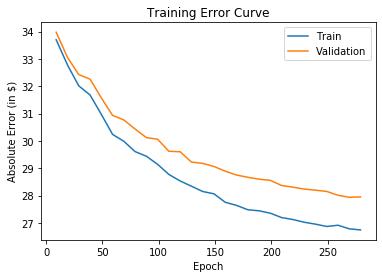

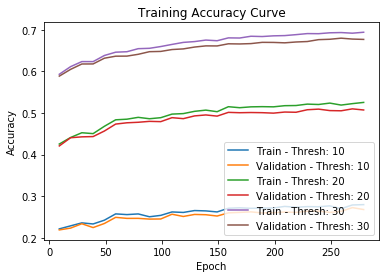

---[ITER 10] loss: 0.136486  time: 2.979
---[ITER 20] loss: 0.139989  time: 2.969
---[ITER 30] loss: 0.142142  time: 3.183
---[ITER 40] loss: 0.140867  time: 3.160
---[ITER 50] loss: 0.139174  time: 3.003
---[ITER 60] loss: 0.141085  time: 3.022
---[ITER 70] loss: 0.139673  time: 2.995
---[ITER 80] loss: 0.140962  time: 3.014
---[ITER 90] loss: 0.138301  time: 2.974
---[ITER 100] loss: 0.140329  time: 2.972
---[ITER 110] loss: 0.140264  time: 2.856
---[ITER 120] loss: 0.141380  time: 2.941
---[ITER 130] loss: 0.140308  time: 3.037
---[ITER 140] loss: 0.143960  time: 3.034
---[ITER 150] loss: 0.135494  time: 3.004
---[ITER 160] loss: 0.140995  time: 3.020
[EPOCH 281] loss: 0.140000  time: 50.514
---[ITER 10] loss: 0.141742  time: 3.027
---[ITER 20] loss: 0.142528  time: 3.102
---[ITER 30] loss: 0.138620  time: 3.182
---[ITER 40] loss: 0.142344  time: 3.148
---[ITER 50] loss: 0.137729  time: 3.062
---[ITER 60] loss: 0.141396  time: 3.014
---[ITER 70] loss: 0.142623  time: 3.254
---[ITER 

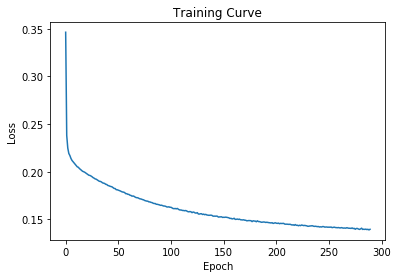

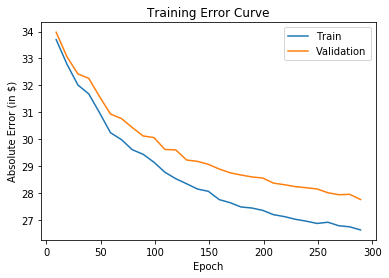

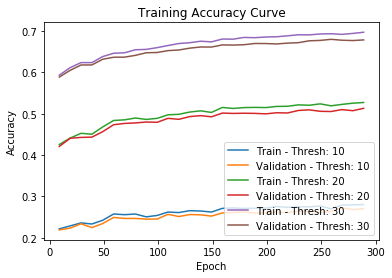

---[ITER 10] loss: 0.139948  time: 3.038
---[ITER 20] loss: 0.143964  time: 3.000
---[ITER 30] loss: 0.136768  time: 3.069
---[ITER 40] loss: 0.137451  time: 3.021
---[ITER 50] loss: 0.138654  time: 3.003
---[ITER 60] loss: 0.142305  time: 2.925
---[ITER 70] loss: 0.139546  time: 3.013
---[ITER 80] loss: 0.133116  time: 3.021
---[ITER 90] loss: 0.139548  time: 2.965
---[ITER 100] loss: 0.138044  time: 3.005
---[ITER 110] loss: 0.143853  time: 2.969
---[ITER 120] loss: 0.139085  time: 2.887
---[ITER 130] loss: 0.137416  time: 2.875
---[ITER 140] loss: 0.135992  time: 3.025
---[ITER 150] loss: 0.144074  time: 3.056
---[ITER 160] loss: 0.139737  time: 3.031
[EPOCH 291] loss: 0.139189  time: 50.379
---[ITER 10] loss: 0.138912  time: 3.194
---[ITER 20] loss: 0.141582  time: 3.044
---[ITER 30] loss: 0.135998  time: 2.984
---[ITER 40] loss: 0.145582  time: 2.915
---[ITER 50] loss: 0.141604  time: 2.891
---[ITER 60] loss: 0.137259  time: 2.852
---[ITER 70] loss: 0.139821  time: 2.918
---[ITER 

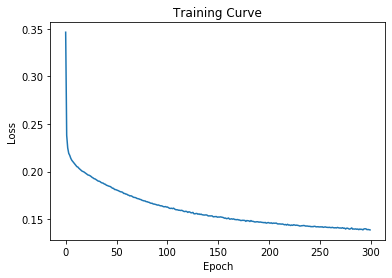

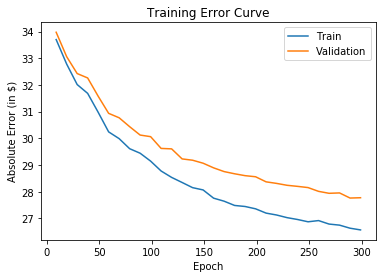

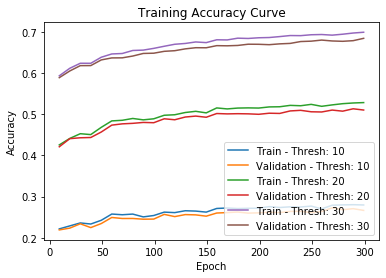

---[ITER 10] loss: 0.145587  time: 2.959
---[ITER 20] loss: 0.137266  time: 3.165
---[ITER 30] loss: 0.139744  time: 3.049
---[ITER 40] loss: 0.141557  time: 3.043
---[ITER 50] loss: 0.137090  time: 2.941
---[ITER 60] loss: 0.139197  time: 2.942
---[ITER 70] loss: 0.143652  time: 3.031
---[ITER 80] loss: 0.134935  time: 3.043
---[ITER 90] loss: 0.132053  time: 3.005
---[ITER 100] loss: 0.140605  time: 3.235
---[ITER 110] loss: 0.140915  time: 3.129
---[ITER 120] loss: 0.143259  time: 2.949
---[ITER 130] loss: 0.141959  time: 2.982
---[ITER 140] loss: 0.137015  time: 3.002
---[ITER 150] loss: 0.134720  time: 3.052
---[ITER 160] loss: 0.140033  time: 2.995
[EPOCH 301] loss: 0.139340  time: 50.872
---[ITER 10] loss: 0.149295  time: 2.996
---[ITER 20] loss: 0.137953  time: 3.043
---[ITER 30] loss: 0.138493  time: 3.035
---[ITER 40] loss: 0.138349  time: 3.036
---[ITER 50] loss: 0.142604  time: 3.063
---[ITER 60] loss: 0.140839  time: 3.058
---[ITER 70] loss: 0.134360  time: 3.015
---[ITER 

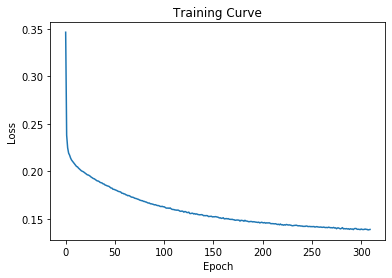

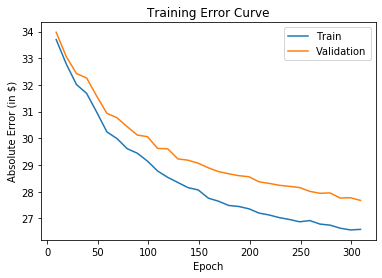

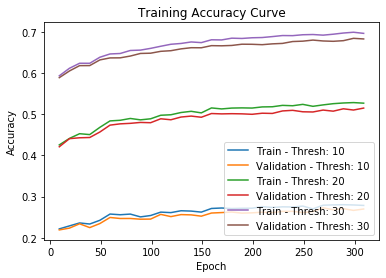

---[ITER 10] loss: 0.142874  time: 3.074
---[ITER 20] loss: 0.138104  time: 3.149
---[ITER 30] loss: 0.135475  time: 3.277
---[ITER 40] loss: 0.138350  time: 4.100
---[ITER 50] loss: 0.138443  time: 2.922
---[ITER 60] loss: 0.137756  time: 2.871
---[ITER 70] loss: 0.140448  time: 2.969
---[ITER 80] loss: 0.136680  time: 2.923
---[ITER 90] loss: 0.138253  time: 2.973
---[ITER 100] loss: 0.138293  time: 2.989
---[ITER 110] loss: 0.133808  time: 3.053
---[ITER 120] loss: 0.138239  time: 3.041
---[ITER 130] loss: 0.141885  time: 2.995
---[ITER 140] loss: 0.143816  time: 2.963
---[ITER 150] loss: 0.142298  time: 3.065
---[ITER 160] loss: 0.131168  time: 3.045
[EPOCH 311] loss: 0.138414  time: 51.732
---[ITER 10] loss: 0.132357  time: 3.027
---[ITER 20] loss: 0.138290  time: 3.064
---[ITER 30] loss: 0.140678  time: 3.034
---[ITER 40] loss: 0.137331  time: 3.074
---[ITER 50] loss: 0.136101  time: 3.243
---[ITER 60] loss: 0.138460  time: 2.939
---[ITER 70] loss: 0.136228  time: 3.157
---[ITER 

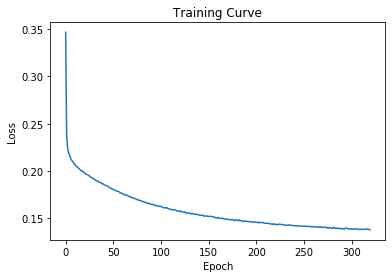

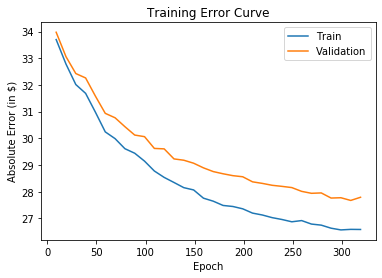

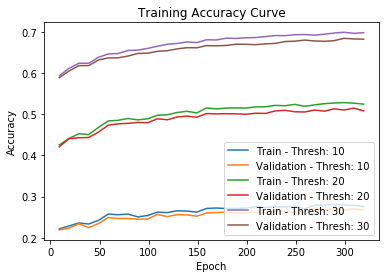

---[ITER 10] loss: 0.135979  time: 2.918
---[ITER 20] loss: 0.135709  time: 2.937
---[ITER 30] loss: 0.137138  time: 2.987
---[ITER 40] loss: 0.140635  time: 2.948
---[ITER 50] loss: 0.136884  time: 2.984
---[ITER 60] loss: 0.134981  time: 3.005
---[ITER 70] loss: 0.137262  time: 3.022
---[ITER 80] loss: 0.136061  time: 3.036
---[ITER 90] loss: 0.143065  time: 2.977
---[ITER 100] loss: 0.137379  time: 2.995
---[ITER 110] loss: 0.135525  time: 2.877
---[ITER 120] loss: 0.140172  time: 2.923
---[ITER 130] loss: 0.143750  time: 2.985
---[ITER 140] loss: 0.138462  time: 3.152
---[ITER 150] loss: 0.140230  time: 3.114
---[ITER 160] loss: 0.138861  time: 3.055
[EPOCH 321] loss: 0.138565  time: 50.421
---[ITER 10] loss: 0.137047  time: 3.217
---[ITER 20] loss: 0.141929  time: 3.072
---[ITER 30] loss: 0.140198  time: 3.035
---[ITER 40] loss: 0.135326  time: 3.014
---[ITER 50] loss: 0.138310  time: 3.040
---[ITER 60] loss: 0.141985  time: 2.939
---[ITER 70] loss: 0.137982  time: 2.932
---[ITER 

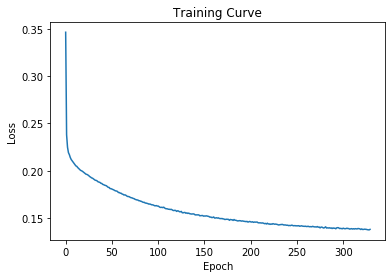

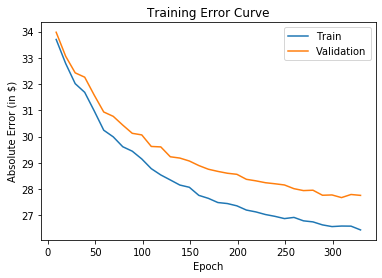

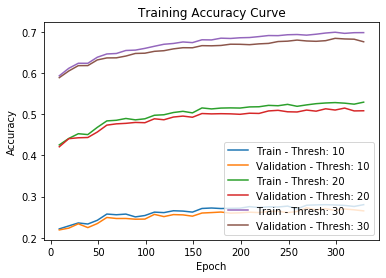

---[ITER 10] loss: 0.139477  time: 3.039
---[ITER 20] loss: 0.139200  time: 3.058
---[ITER 30] loss: 0.139514  time: 2.996
---[ITER 40] loss: 0.135067  time: 3.224
---[ITER 50] loss: 0.138758  time: 3.002
---[ITER 60] loss: 0.137054  time: 3.007
---[ITER 70] loss: 0.141970  time: 3.151
---[ITER 80] loss: 0.142409  time: 3.060
---[ITER 90] loss: 0.136417  time: 3.029
---[ITER 100] loss: 0.135905  time: 3.240
---[ITER 110] loss: 0.137356  time: 2.862
---[ITER 120] loss: 0.131170  time: 2.901
---[ITER 130] loss: 0.136486  time: 2.893
---[ITER 140] loss: 0.137056  time: 2.971
---[ITER 150] loss: 0.138929  time: 3.042
---[ITER 160] loss: 0.138732  time: 3.016
[EPOCH 331] loss: 0.137867  time: 50.844
---[ITER 10] loss: 0.142492  time: 3.037
---[ITER 20] loss: 0.137831  time: 3.098
---[ITER 30] loss: 0.133754  time: 3.039
---[ITER 40] loss: 0.140853  time: 3.012
---[ITER 50] loss: 0.139854  time: 3.016
---[ITER 60] loss: 0.135686  time: 3.018
---[ITER 70] loss: 0.139119  time: 3.007
---[ITER 

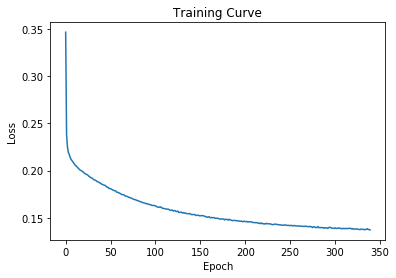

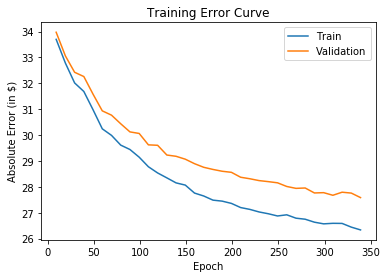

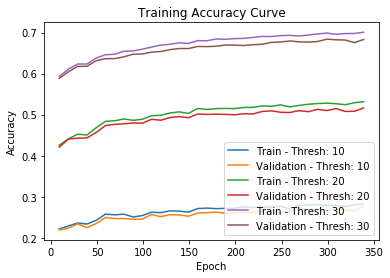

---[ITER 10] loss: 0.138969  time: 3.094
---[ITER 20] loss: 0.137084  time: 3.059
---[ITER 30] loss: 0.139817  time: 3.083
---[ITER 40] loss: 0.135018  time: 3.257
---[ITER 50] loss: 0.135091  time: 2.976
---[ITER 60] loss: 0.138332  time: 2.937
---[ITER 70] loss: 0.133962  time: 2.974
---[ITER 80] loss: 0.141372  time: 2.979
---[ITER 90] loss: 0.131999  time: 3.103
---[ITER 100] loss: 0.138454  time: 3.143
---[ITER 110] loss: 0.136789  time: 3.066
---[ITER 120] loss: 0.139688  time: 3.007
---[ITER 130] loss: 0.135104  time: 2.960
---[ITER 140] loss: 0.136843  time: 2.907
---[ITER 150] loss: 0.140118  time: 2.966
---[ITER 160] loss: 0.138718  time: 3.215
[EPOCH 341] loss: 0.137442  time: 51.072
---[ITER 10] loss: 0.134789  time: 2.881
---[ITER 20] loss: 0.140212  time: 3.015
---[ITER 30] loss: 0.134348  time: 2.898
---[ITER 40] loss: 0.132603  time: 2.913
---[ITER 50] loss: 0.139500  time: 2.986
---[ITER 60] loss: 0.139140  time: 2.937
---[ITER 70] loss: 0.136822  time: 3.284
---[ITER 

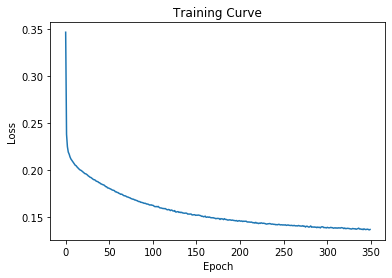

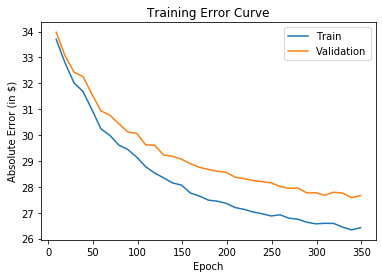

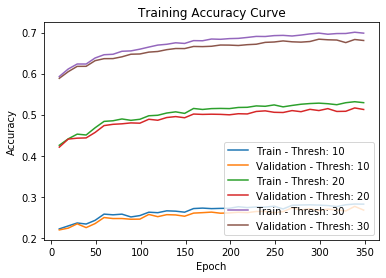

---[ITER 10] loss: 0.136425  time: 2.955
---[ITER 20] loss: 0.141429  time: 2.947
---[ITER 30] loss: 0.140404  time: 2.983
---[ITER 40] loss: 0.131828  time: 2.989
---[ITER 50] loss: 0.137116  time: 3.007
---[ITER 60] loss: 0.131045  time: 3.010
---[ITER 70] loss: 0.132275  time: 2.939
---[ITER 80] loss: 0.135202  time: 2.875
---[ITER 90] loss: 0.144476  time: 2.941
---[ITER 100] loss: 0.134368  time: 3.012
---[ITER 110] loss: 0.140691  time: 3.013
---[ITER 120] loss: 0.136103  time: 3.059
---[ITER 130] loss: 0.133343  time: 3.025
---[ITER 140] loss: 0.138010  time: 2.944
---[ITER 150] loss: 0.140968  time: 3.064
---[ITER 160] loss: 0.140088  time: 3.072
[EPOCH 351] loss: 0.137029  time: 50.183
---[ITER 10] loss: 0.135885  time: 3.079
---[ITER 20] loss: 0.139879  time: 3.201
---[ITER 30] loss: 0.136333  time: 3.054
---[ITER 40] loss: 0.144664  time: 3.048
---[ITER 50] loss: 0.130007  time: 2.952
---[ITER 60] loss: 0.138765  time: 2.933
---[ITER 70] loss: 0.141614  time: 2.921
---[ITER 

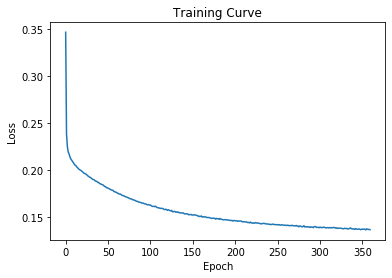

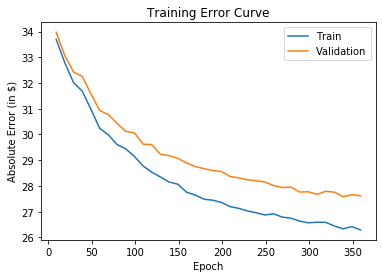

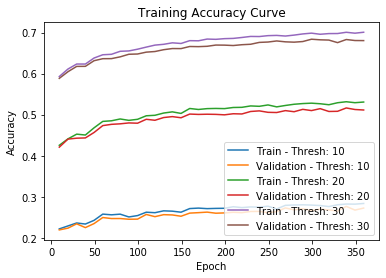

---[ITER 10] loss: 0.132944  time: 2.980
---[ITER 20] loss: 0.134702  time: 2.985
---[ITER 30] loss: 0.139860  time: 3.090
---[ITER 40] loss: 0.138839  time: 3.018
---[ITER 50] loss: 0.138094  time: 3.031
---[ITER 60] loss: 0.135655  time: 3.017
---[ITER 70] loss: 0.137518  time: 2.954
---[ITER 80] loss: 0.135366  time: 3.006
---[ITER 90] loss: 0.138465  time: 3.017
---[ITER 100] loss: 0.139339  time: 2.961
---[ITER 110] loss: 0.135652  time: 3.098
---[ITER 120] loss: 0.133759  time: 3.231
---[ITER 130] loss: 0.132944  time: 3.023
---[ITER 140] loss: 0.132460  time: 3.117
---[ITER 150] loss: 0.140209  time: 3.032
---[ITER 160] loss: 0.139190  time: 2.975
[EPOCH 361] loss: 0.136494  time: 50.855
---[ITER 10] loss: 0.137527  time: 3.030
---[ITER 20] loss: 0.134891  time: 2.978
---[ITER 30] loss: 0.133233  time: 2.955
---[ITER 40] loss: 0.136153  time: 2.952
---[ITER 50] loss: 0.141944  time: 2.977
---[ITER 60] loss: 0.135100  time: 2.958
---[ITER 70] loss: 0.135564  time: 2.996
---[ITER 

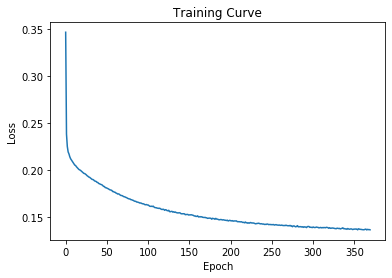

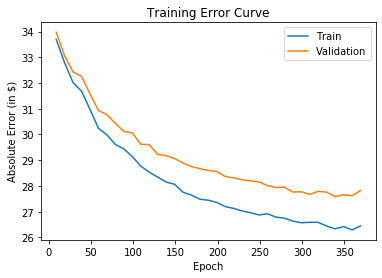

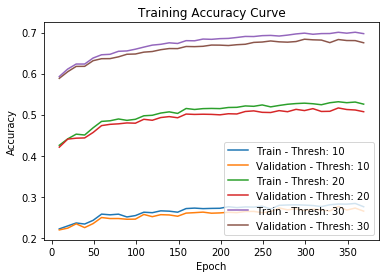

---[ITER 10] loss: 0.136427  time: 3.066
---[ITER 20] loss: 0.137976  time: 3.068
---[ITER 30] loss: 0.135501  time: 3.099
---[ITER 40] loss: 0.137366  time: 3.380
---[ITER 50] loss: 0.139878  time: 3.065
---[ITER 60] loss: 0.139487  time: 2.934
---[ITER 70] loss: 0.136486  time: 2.885
---[ITER 80] loss: 0.136133  time: 2.975
---[ITER 90] loss: 0.137645  time: 3.048
---[ITER 100] loss: 0.133881  time: 3.351
---[ITER 110] loss: 0.131219  time: 3.097
---[ITER 120] loss: 0.134083  time: 3.040
---[ITER 130] loss: 0.137571  time: 3.050
---[ITER 140] loss: 0.140812  time: 3.032
---[ITER 150] loss: 0.133031  time: 2.939
---[ITER 160] loss: 0.139288  time: 2.943
[EPOCH 371] loss: 0.136553  time: 51.222
---[ITER 10] loss: 0.131809  time: 2.963
---[ITER 20] loss: 0.135655  time: 2.998
---[ITER 30] loss: 0.141206  time: 3.034
---[ITER 40] loss: 0.141529  time: 3.098
---[ITER 50] loss: 0.138603  time: 3.127
---[ITER 60] loss: 0.137932  time: 3.047
---[ITER 70] loss: 0.137457  time: 3.168
---[ITER 

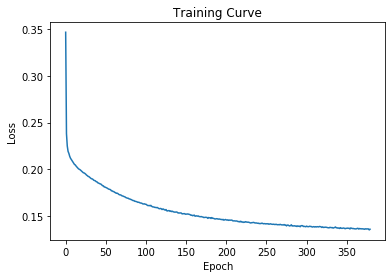

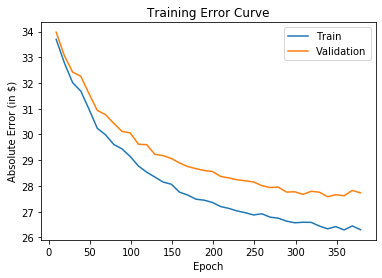

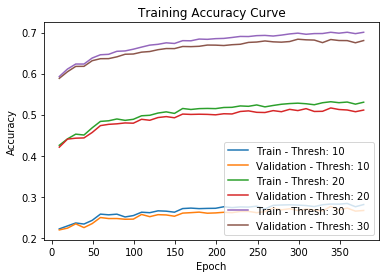

---[ITER 10] loss: 0.131531  time: 3.056
---[ITER 20] loss: 0.132951  time: 3.018
---[ITER 30] loss: 0.138967  time: 2.936
---[ITER 40] loss: 0.133219  time: 2.915
---[ITER 50] loss: 0.134496  time: 2.968
---[ITER 60] loss: 0.137172  time: 3.029
---[ITER 70] loss: 0.136941  time: 3.031
---[ITER 80] loss: 0.133280  time: 3.065
---[ITER 90] loss: 0.135859  time: 3.013
---[ITER 100] loss: 0.137622  time: 3.029
---[ITER 110] loss: 0.131911  time: 2.996
---[ITER 120] loss: 0.136798  time: 3.003
---[ITER 130] loss: 0.134802  time: 3.036
---[ITER 140] loss: 0.134362  time: 3.097
---[ITER 150] loss: 0.134237  time: 3.025
---[ITER 160] loss: 0.138768  time: 3.173
[EPOCH 381] loss: 0.135312  time: 50.801
---[ITER 10] loss: 0.136950  time: 3.061
---[ITER 20] loss: 0.140610  time: 3.027
---[ITER 30] loss: 0.137253  time: 3.073
---[ITER 40] loss: 0.135942  time: 3.012
---[ITER 50] loss: 0.132546  time: 2.886
---[ITER 60] loss: 0.136499  time: 3.000
---[ITER 70] loss: 0.133097  time: 3.046
---[ITER 

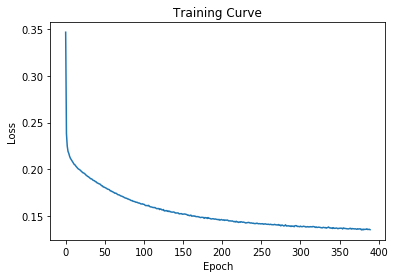

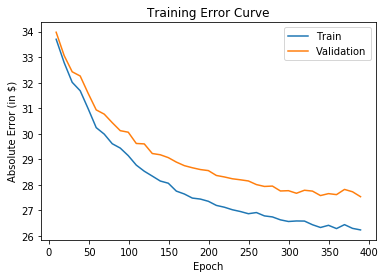

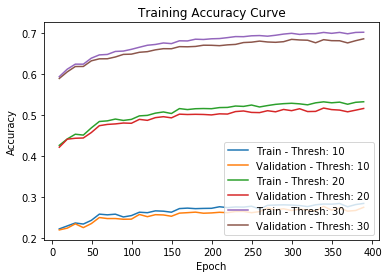

---[ITER 10] loss: 0.136091  time: 2.932
---[ITER 20] loss: 0.137391  time: 2.932
---[ITER 30] loss: 0.138755  time: 2.977
---[ITER 40] loss: 0.134177  time: 3.012
---[ITER 50] loss: 0.134335  time: 3.023
---[ITER 60] loss: 0.134528  time: 3.065
---[ITER 70] loss: 0.129885  time: 3.090
---[ITER 80] loss: 0.138049  time: 3.081
---[ITER 90] loss: 0.135400  time: 3.025
---[ITER 100] loss: 0.138729  time: 3.128
---[ITER 110] loss: 0.136064  time: 3.193
---[ITER 120] loss: 0.140033  time: 3.082
---[ITER 130] loss: 0.133793  time: 3.037
---[ITER 140] loss: 0.133932  time: 2.996
---[ITER 150] loss: 0.131091  time: 2.984
---[ITER 160] loss: 0.134675  time: 2.962
[EPOCH 391] loss: 0.135523  time: 50.840
---[ITER 10] loss: 0.138328  time: 2.936
---[ITER 20] loss: 0.137623  time: 3.044
---[ITER 30] loss: 0.130103  time: 2.996
---[ITER 40] loss: 0.131212  time: 3.073
---[ITER 50] loss: 0.136776  time: 3.051
---[ITER 60] loss: 0.135098  time: 3.069
---[ITER 70] loss: 0.136640  time: 3.035
---[ITER 

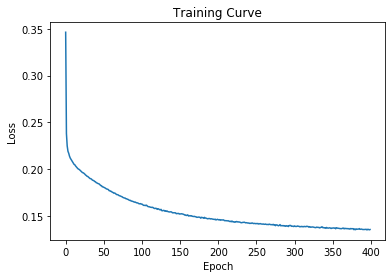

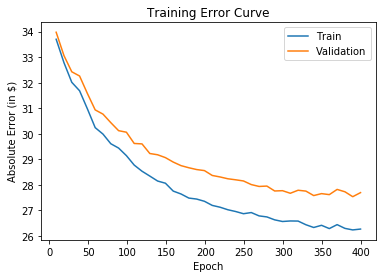

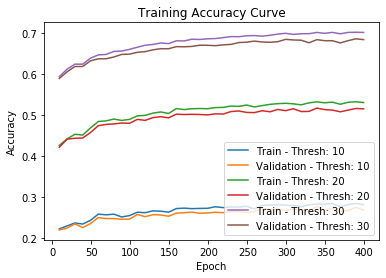

---[ITER 10] loss: 0.133351  time: 2.484
---[ITER 20] loss: 0.133882  time: 2.562
---[ITER 30] loss: 0.137258  time: 2.822
---[ITER 40] loss: 0.139877  time: 2.511
---[ITER 50] loss: 0.135553  time: 2.753
---[ITER 60] loss: 0.136399  time: 2.768
---[ITER 70] loss: 0.142119  time: 2.663
---[ITER 80] loss: 0.134357  time: 2.639
---[ITER 90] loss: 0.136338  time: 2.585
---[ITER 100] loss: 0.137822  time: 2.517
---[ITER 110] loss: 0.132505  time: 2.570
---[ITER 120] loss: 0.136779  time: 2.652
---[ITER 130] loss: 0.134431  time: 2.571
---[ITER 140] loss: 0.136994  time: 2.623
---[ITER 150] loss: 0.135696  time: 2.732
---[ITER 160] loss: 0.132856  time: 2.612
[EPOCH 401] loss: 0.136019  time: 44.100
---[ITER 10] loss: 0.137097  time: 2.728
---[ITER 20] loss: 0.131613  time: 2.557
---[ITER 30] loss: 0.133791  time: 2.595
---[ITER 40] loss: 0.138671  time: 2.570
---[ITER 50] loss: 0.134127  time: 2.688
---[ITER 60] loss: 0.128684  time: 2.632
---[ITER 70] loss: 0.133562  time: 2.596
---[ITER 

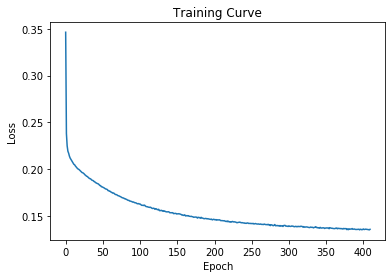

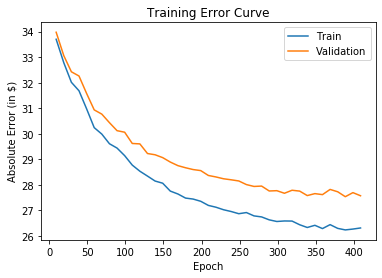

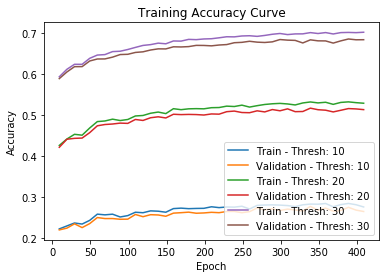

---[ITER 10] loss: 0.133261  time: 2.562
---[ITER 20] loss: 0.136855  time: 2.567
---[ITER 30] loss: 0.139017  time: 2.485
---[ITER 40] loss: 0.133436  time: 2.526
---[ITER 50] loss: 0.135191  time: 2.544
---[ITER 60] loss: 0.136918  time: 2.540
---[ITER 70] loss: 0.135273  time: 2.523
---[ITER 80] loss: 0.137378  time: 2.511
---[ITER 90] loss: 0.134734  time: 2.578
---[ITER 100] loss: 0.135967  time: 2.595
---[ITER 110] loss: 0.132902  time: 2.536
---[ITER 120] loss: 0.130643  time: 2.535
---[ITER 130] loss: 0.134071  time: 2.513
---[ITER 140] loss: 0.134138  time: 2.500
---[ITER 150] loss: 0.136251  time: 2.500
---[ITER 160] loss: 0.135570  time: 2.477
[EPOCH 411] loss: 0.135029  time: 42.437
---[ITER 10] loss: 0.129837  time: 2.539
---[ITER 20] loss: 0.134460  time: 2.490
---[ITER 30] loss: 0.139516  time: 2.491
---[ITER 40] loss: 0.131433  time: 2.509
---[ITER 50] loss: 0.137162  time: 2.474
---[ITER 60] loss: 0.132902  time: 2.518
---[ITER 70] loss: 0.134108  time: 2.543
---[ITER 

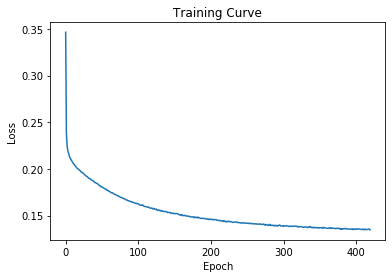

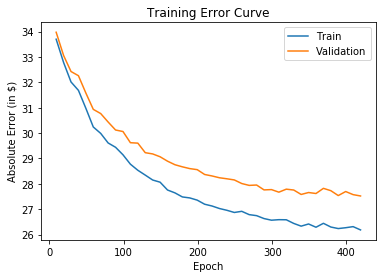

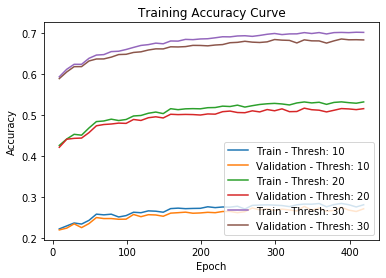

---[ITER 10] loss: 0.137276  time: 2.536
---[ITER 20] loss: 0.137230  time: 2.528
---[ITER 30] loss: 0.135289  time: 2.559
---[ITER 40] loss: 0.133928  time: 2.515
---[ITER 50] loss: 0.139285  time: 2.482
---[ITER 60] loss: 0.130541  time: 2.505
---[ITER 70] loss: 0.137506  time: 2.514
---[ITER 80] loss: 0.134748  time: 2.482
---[ITER 90] loss: 0.135406  time: 2.500
---[ITER 100] loss: 0.138439  time: 2.499
---[ITER 110] loss: 0.135066  time: 2.493
---[ITER 120] loss: 0.129950  time: 2.525
---[ITER 130] loss: 0.133392  time: 2.544
---[ITER 140] loss: 0.136765  time: 2.554
---[ITER 150] loss: 0.138174  time: 2.490
---[ITER 160] loss: 0.132818  time: 2.451
[EPOCH 421] loss: 0.135274  time: 42.092
---[ITER 10] loss: 0.133601  time: 2.653
---[ITER 20] loss: 0.137281  time: 2.511
---[ITER 30] loss: 0.136010  time: 2.459
---[ITER 40] loss: 0.140188  time: 2.489
---[ITER 50] loss: 0.128498  time: 2.491
---[ITER 60] loss: 0.133840  time: 2.498
---[ITER 70] loss: 0.135623  time: 2.498
---[ITER 

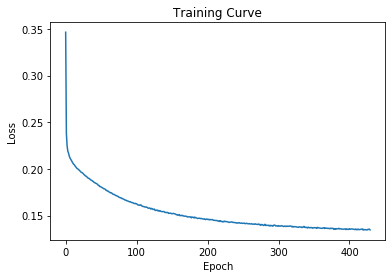

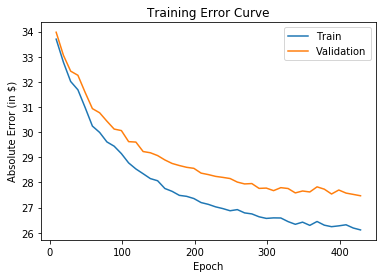

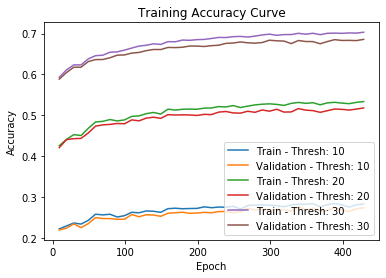

---[ITER 10] loss: 0.133422  time: 2.521
---[ITER 20] loss: 0.135522  time: 2.681
---[ITER 30] loss: 0.140003  time: 2.561
---[ITER 40] loss: 0.135103  time: 2.515
---[ITER 50] loss: 0.137181  time: 2.502
---[ITER 60] loss: 0.134082  time: 2.536
---[ITER 70] loss: 0.138031  time: 2.510
---[ITER 80] loss: 0.133512  time: 2.538
---[ITER 90] loss: 0.135036  time: 2.474
---[ITER 100] loss: 0.137277  time: 2.505
---[ITER 110] loss: 0.131767  time: 2.515
---[ITER 120] loss: 0.132139  time: 2.522
---[ITER 130] loss: 0.131729  time: 2.545
---[ITER 140] loss: 0.137293  time: 2.542
---[ITER 150] loss: 0.134209  time: 2.504
---[ITER 160] loss: 0.134919  time: 2.458
[EPOCH 431] loss: 0.134980  time: 42.402
---[ITER 10] loss: 0.136836  time: 2.528
---[ITER 20] loss: 0.130857  time: 2.574
---[ITER 30] loss: 0.135192  time: 2.508
---[ITER 40] loss: 0.133412  time: 2.475
---[ITER 50] loss: 0.131943  time: 2.524
---[ITER 60] loss: 0.138589  time: 2.530
---[ITER 70] loss: 0.139088  time: 2.532
---[ITER 

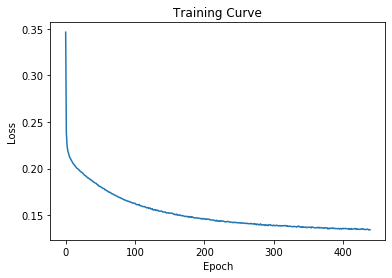

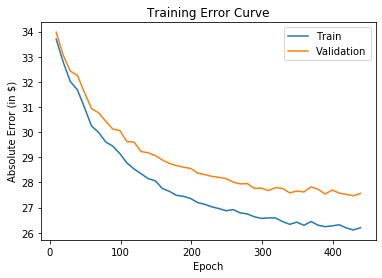

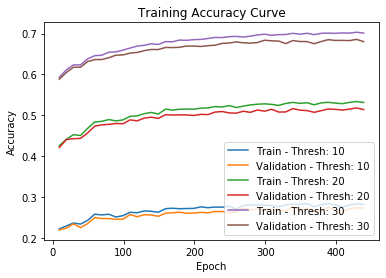

---[ITER 10] loss: 0.135361  time: 2.595
---[ITER 20] loss: 0.130389  time: 2.518
---[ITER 30] loss: 0.136325  time: 2.522
---[ITER 40] loss: 0.133528  time: 2.568
---[ITER 50] loss: 0.132932  time: 2.527
---[ITER 60] loss: 0.137601  time: 2.507
---[ITER 70] loss: 0.137191  time: 2.505
---[ITER 80] loss: 0.136624  time: 2.619
---[ITER 90] loss: 0.138183  time: 2.490
---[ITER 100] loss: 0.141128  time: 2.477
---[ITER 110] loss: 0.132079  time: 2.498
---[ITER 120] loss: 0.129742  time: 2.530
---[ITER 130] loss: 0.133649  time: 2.466
---[ITER 140] loss: 0.133737  time: 2.505
---[ITER 150] loss: 0.139055  time: 2.540
---[ITER 160] loss: 0.135707  time: 2.526
[EPOCH 441] loss: 0.135029  time: 42.323
---[ITER 10] loss: 0.133096  time: 2.529
---[ITER 20] loss: 0.135250  time: 2.520
---[ITER 30] loss: 0.137877  time: 2.500
---[ITER 40] loss: 0.131710  time: 2.519
---[ITER 50] loss: 0.134318  time: 2.496
---[ITER 60] loss: 0.132813  time: 2.480
---[ITER 70] loss: 0.133894  time: 2.477
---[ITER 

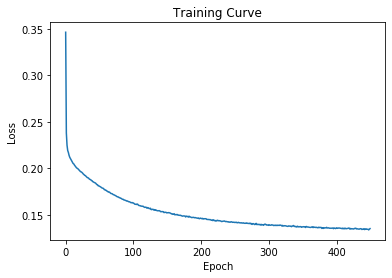

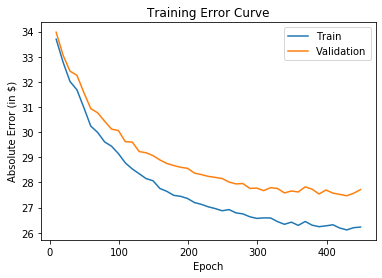

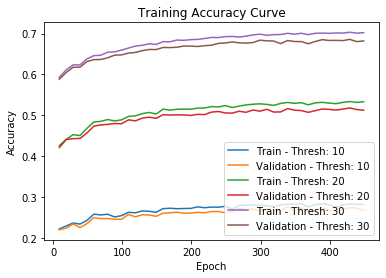

---[ITER 10] loss: 0.133399  time: 2.527
---[ITER 20] loss: 0.132394  time: 2.555
---[ITER 30] loss: 0.133407  time: 2.529
---[ITER 40] loss: 0.136260  time: 2.519
---[ITER 50] loss: 0.134157  time: 2.493
---[ITER 60] loss: 0.136827  time: 2.523
---[ITER 70] loss: 0.135139  time: 2.556
---[ITER 80] loss: 0.132001  time: 2.511
---[ITER 90] loss: 0.134198  time: 2.530
---[ITER 100] loss: 0.135567  time: 2.511
---[ITER 110] loss: 0.131095  time: 2.548
---[ITER 120] loss: 0.137989  time: 2.555
---[ITER 130] loss: 0.133358  time: 2.560
---[ITER 140] loss: 0.132691  time: 2.568
---[ITER 150] loss: 0.134802  time: 2.532
---[ITER 160] loss: 0.135720  time: 2.614
[EPOCH 451] loss: 0.134117  time: 42.570
---[ITER 10] loss: 0.129479  time: 2.483
---[ITER 20] loss: 0.136506  time: 2.534
---[ITER 30] loss: 0.133386  time: 2.505
---[ITER 40] loss: 0.139142  time: 2.506
---[ITER 50] loss: 0.136002  time: 2.506
---[ITER 60] loss: 0.139486  time: 2.494
---[ITER 70] loss: 0.131889  time: 2.488
---[ITER 

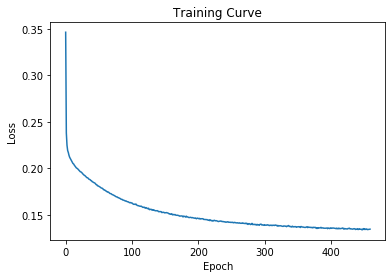

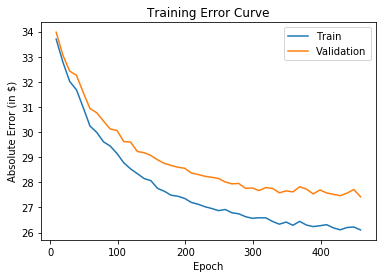

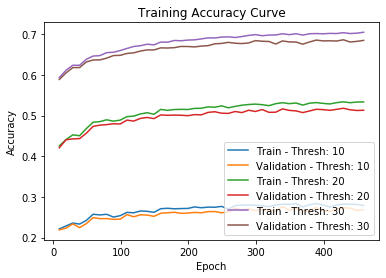

---[ITER 10] loss: 0.130452  time: 2.472
---[ITER 20] loss: 0.125769  time: 2.540
---[ITER 30] loss: 0.135083  time: 2.517
---[ITER 40] loss: 0.130329  time: 2.470
---[ITER 50] loss: 0.135437  time: 2.552
---[ITER 60] loss: 0.133440  time: 2.519
---[ITER 70] loss: 0.134528  time: 2.531
---[ITER 80] loss: 0.136133  time: 2.501
---[ITER 90] loss: 0.138305  time: 2.505
---[ITER 100] loss: 0.139058  time: 2.517
---[ITER 110] loss: 0.135050  time: 2.548
---[ITER 120] loss: 0.133860  time: 2.475
---[ITER 130] loss: 0.131776  time: 2.525
---[ITER 140] loss: 0.137771  time: 2.532
---[ITER 150] loss: 0.135427  time: 2.498
---[ITER 160] loss: 0.126538  time: 2.496
[EPOCH 461] loss: 0.133774  time: 42.167
---[ITER 10] loss: 0.132047  time: 2.501
---[ITER 20] loss: 0.140062  time: 2.520
---[ITER 30] loss: 0.134201  time: 2.555
---[ITER 40] loss: 0.132869  time: 2.546
---[ITER 50] loss: 0.133993  time: 2.553
---[ITER 60] loss: 0.133713  time: 2.497
---[ITER 70] loss: 0.137726  time: 2.608
---[ITER 

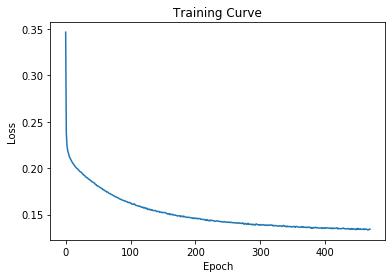

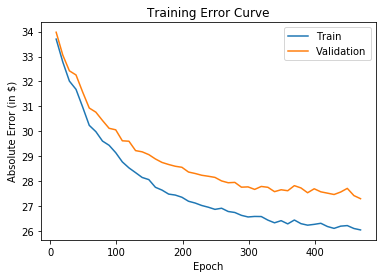

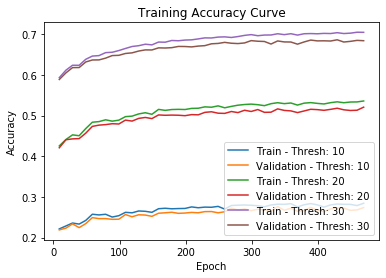

---[ITER 10] loss: 0.131923  time: 2.511
---[ITER 20] loss: 0.135692  time: 2.517
---[ITER 30] loss: 0.135486  time: 2.520
---[ITER 40] loss: 0.134991  time: 2.552
---[ITER 50] loss: 0.134982  time: 2.529
---[ITER 60] loss: 0.135641  time: 2.480
---[ITER 70] loss: 0.133419  time: 2.509
---[ITER 80] loss: 0.133651  time: 2.674
---[ITER 90] loss: 0.136273  time: 2.541
---[ITER 100] loss: 0.130078  time: 2.515
---[ITER 110] loss: 0.134077  time: 2.514
---[ITER 120] loss: 0.131194  time: 2.549
---[ITER 130] loss: 0.135232  time: 2.507
---[ITER 140] loss: 0.134748  time: 2.521
---[ITER 150] loss: 0.138137  time: 2.502
---[ITER 160] loss: 0.136397  time: 2.524
[EPOCH 471] loss: 0.134542  time: 42.403
---[ITER 10] loss: 0.136478  time: 2.506
---[ITER 20] loss: 0.135342  time: 2.510
---[ITER 30] loss: 0.130971  time: 2.504
---[ITER 40] loss: 0.136329  time: 2.506
---[ITER 50] loss: 0.135538  time: 2.481
---[ITER 60] loss: 0.135228  time: 2.501
---[ITER 70] loss: 0.132569  time: 2.519
---[ITER 

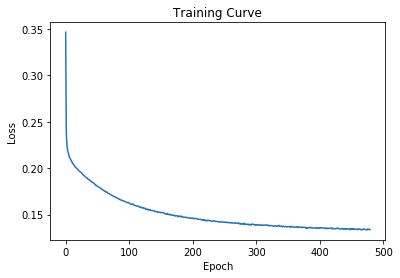

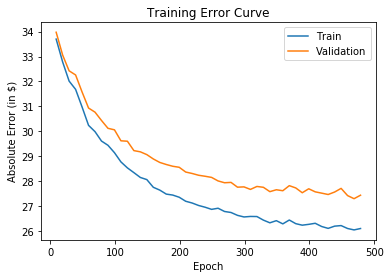

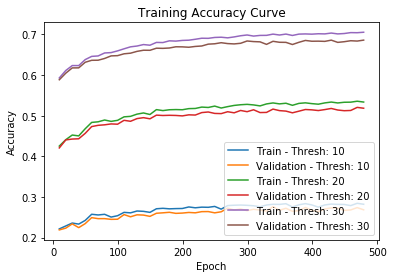

---[ITER 10] loss: 0.132294  time: 2.562
---[ITER 20] loss: 0.131892  time: 2.522
---[ITER 30] loss: 0.131382  time: 2.552
---[ITER 40] loss: 0.137508  time: 2.531
---[ITER 50] loss: 0.130896  time: 2.506
---[ITER 60] loss: 0.134403  time: 2.488
---[ITER 70] loss: 0.135188  time: 2.493
---[ITER 80] loss: 0.137335  time: 2.523
---[ITER 90] loss: 0.131264  time: 2.515
---[ITER 100] loss: 0.130636  time: 2.482
---[ITER 110] loss: 0.131573  time: 2.581
---[ITER 120] loss: 0.136178  time: 2.552
---[ITER 130] loss: 0.136551  time: 2.538
---[ITER 140] loss: 0.135356  time: 2.520
---[ITER 150] loss: 0.136953  time: 2.693
---[ITER 160] loss: 0.131187  time: 2.604
[EPOCH 481] loss: 0.133754  time: 42.618
---[ITER 10] loss: 0.140568  time: 2.508
---[ITER 20] loss: 0.136784  time: 2.567
---[ITER 30] loss: 0.128241  time: 2.523
---[ITER 40] loss: 0.132176  time: 2.500
---[ITER 50] loss: 0.133745  time: 2.482
---[ITER 60] loss: 0.133205  time: 2.496
---[ITER 70] loss: 0.137589  time: 2.511
---[ITER 

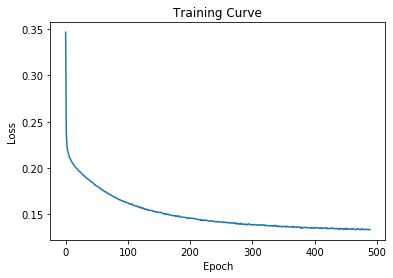

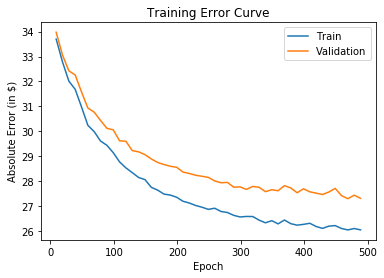

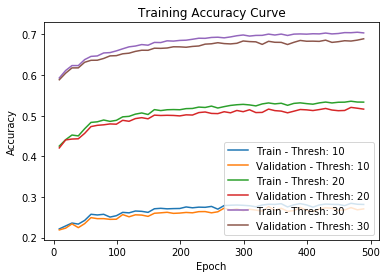

---[ITER 10] loss: 0.130233  time: 2.479
---[ITER 20] loss: 0.135094  time: 2.529
---[ITER 30] loss: 0.134759  time: 2.514
---[ITER 40] loss: 0.132586  time: 2.493
---[ITER 50] loss: 0.134208  time: 2.520
---[ITER 60] loss: 0.133823  time: 2.518
---[ITER 70] loss: 0.131650  time: 2.472
---[ITER 80] loss: 0.131239  time: 2.496
---[ITER 90] loss: 0.131756  time: 2.503
---[ITER 100] loss: 0.133943  time: 2.503
---[ITER 110] loss: 0.136385  time: 2.524
---[ITER 120] loss: 0.134585  time: 2.503
---[ITER 130] loss: 0.131099  time: 2.519
---[ITER 140] loss: 0.134713  time: 2.520
---[ITER 150] loss: 0.131318  time: 2.482
---[ITER 160] loss: 0.133032  time: 2.490
[EPOCH 491] loss: 0.133055  time: 42.010
---[ITER 10] loss: 0.135528  time: 2.559
---[ITER 20] loss: 0.138205  time: 2.537
---[ITER 30] loss: 0.134255  time: 2.526
---[ITER 40] loss: 0.126752  time: 2.523
---[ITER 50] loss: 0.132339  time: 2.620
---[ITER 60] loss: 0.132251  time: 2.576
---[ITER 70] loss: 0.130112  time: 2.510
---[ITER 

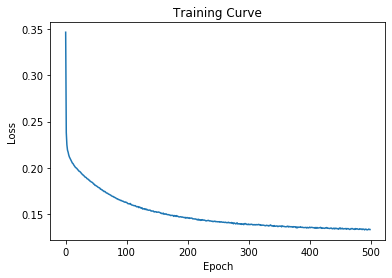

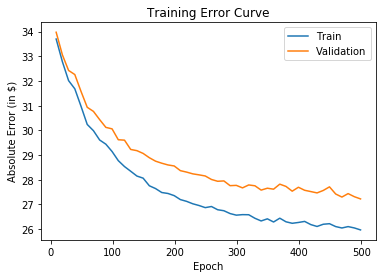

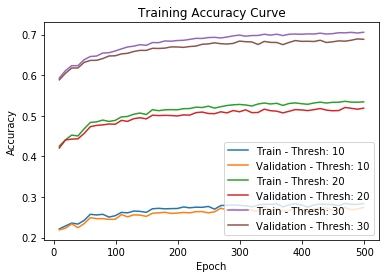

---[ITER 10] loss: 0.133564  time: 2.485
---[ITER 20] loss: 0.136567  time: 2.532
---[ITER 30] loss: 0.131338  time: 2.559
---[ITER 40] loss: 0.132838  time: 2.495
---[ITER 50] loss: 0.131084  time: 2.569
---[ITER 60] loss: 0.129921  time: 2.516
---[ITER 70] loss: 0.135422  time: 2.520
---[ITER 80] loss: 0.135108  time: 2.486
---[ITER 90] loss: 0.136124  time: 2.604
---[ITER 100] loss: 0.132192  time: 2.510
---[ITER 110] loss: 0.133458  time: 2.473
---[ITER 120] loss: 0.130046  time: 2.521
---[ITER 130] loss: 0.133822  time: 2.499
---[ITER 140] loss: 0.133201  time: 2.529
---[ITER 150] loss: 0.134111  time: 2.519
---[ITER 160] loss: 0.133911  time: 2.468
[EPOCH 501] loss: 0.133566  time: 42.217
---[ITER 10] loss: 0.130716  time: 2.511
---[ITER 20] loss: 0.135016  time: 2.551
---[ITER 30] loss: 0.130649  time: 2.499
---[ITER 40] loss: 0.132844  time: 2.496
---[ITER 50] loss: 0.135097  time: 2.480
---[ITER 60] loss: 0.135606  time: 2.483
---[ITER 70] loss: 0.131900  time: 2.529
---[ITER 

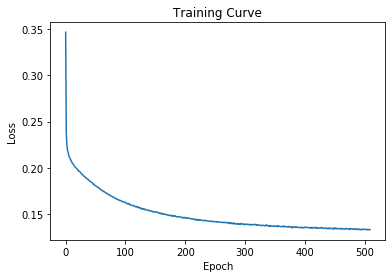

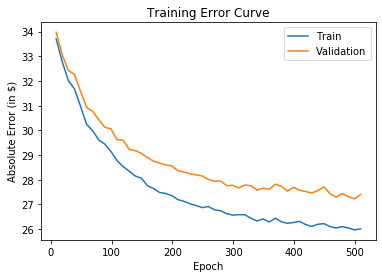

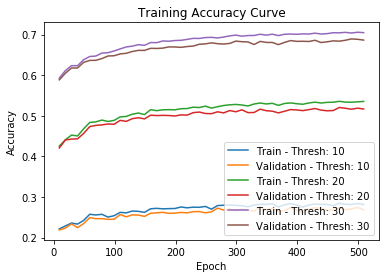

---[ITER 10] loss: 0.134451  time: 2.501
---[ITER 20] loss: 0.131990  time: 2.528
---[ITER 30] loss: 0.133261  time: 2.522
---[ITER 40] loss: 0.133347  time: 2.471
---[ITER 50] loss: 0.127054  time: 2.499
---[ITER 60] loss: 0.134590  time: 2.511
---[ITER 70] loss: 0.133216  time: 2.545
---[ITER 80] loss: 0.131354  time: 2.505
---[ITER 90] loss: 0.126195  time: 2.494
---[ITER 100] loss: 0.135689  time: 2.499
---[ITER 110] loss: 0.134089  time: 2.476
---[ITER 120] loss: 0.132832  time: 2.508
---[ITER 130] loss: 0.135784  time: 2.574
---[ITER 140] loss: 0.132439  time: 2.577
---[ITER 150] loss: 0.133996  time: 2.519
---[ITER 160] loss: 0.138780  time: 2.501
[EPOCH 511] loss: 0.132920  time: 42.304
---[ITER 10] loss: 0.137930  time: 2.529
---[ITER 20] loss: 0.130400  time: 2.538
---[ITER 30] loss: 0.132894  time: 2.499
---[ITER 40] loss: 0.132296  time: 2.508
---[ITER 50] loss: 0.133189  time: 2.492
---[ITER 60] loss: 0.128954  time: 2.521
---[ITER 70] loss: 0.135076  time: 2.475
---[ITER 

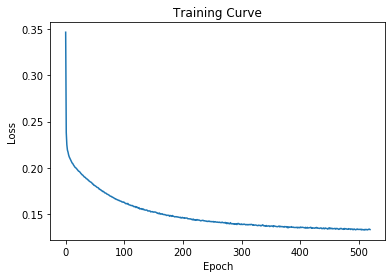

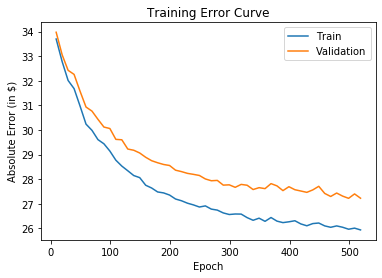

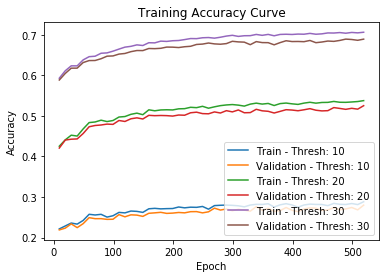

---[ITER 10] loss: 0.132201  time: 2.603
---[ITER 20] loss: 0.137897  time: 2.529
---[ITER 30] loss: 0.131193  time: 2.769
---[ITER 40] loss: 0.134965  time: 3.045
---[ITER 50] loss: 0.130870  time: 2.578
---[ITER 60] loss: 0.130493  time: 2.574
---[ITER 70] loss: 0.136831  time: 2.949
---[ITER 80] loss: 0.135049  time: 2.896
---[ITER 90] loss: 0.124903  time: 2.746
---[ITER 100] loss: 0.133751  time: 2.820
---[ITER 110] loss: 0.133390  time: 2.882
---[ITER 120] loss: 0.130277  time: 2.887
---[ITER 130] loss: 0.132997  time: 2.835
---[ITER 140] loss: 0.133652  time: 2.836
---[ITER 150] loss: 0.134374  time: 2.859
---[ITER 160] loss: 0.132610  time: 2.726
[EPOCH 521] loss: 0.133051  time: 46.505
---[ITER 10] loss: 0.135389  time: 2.677
---[ITER 20] loss: 0.132026  time: 2.636
---[ITER 30] loss: 0.129223  time: 2.574
---[ITER 40] loss: 0.133868  time: 2.548
---[ITER 50] loss: 0.132474  time: 2.515
---[ITER 60] loss: 0.132580  time: 2.657
---[ITER 70] loss: 0.138216  time: 2.522
---[ITER 

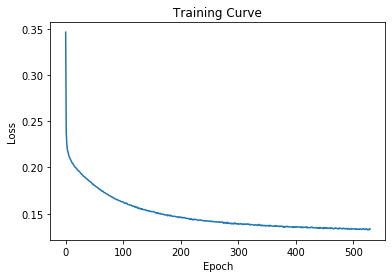

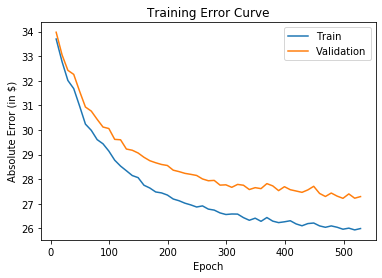

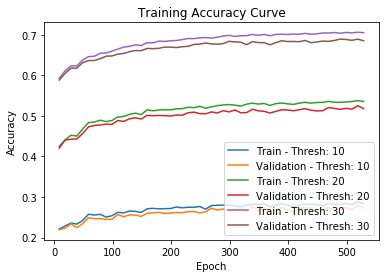

---[ITER 10] loss: 0.132696  time: 3.801
---[ITER 20] loss: 0.133659  time: 3.905
---[ITER 30] loss: 0.133715  time: 3.166
---[ITER 40] loss: 0.132211  time: 3.068
---[ITER 50] loss: 0.135830  time: 2.993
---[ITER 60] loss: 0.128398  time: 3.088
---[ITER 70] loss: 0.136496  time: 3.084
---[ITER 80] loss: 0.135005  time: 3.711
---[ITER 90] loss: 0.136086  time: 3.892
---[ITER 100] loss: 0.133145  time: 3.452
---[ITER 110] loss: 0.130421  time: 3.851
---[ITER 120] loss: 0.138611  time: 6.913
---[ITER 130] loss: 0.131107  time: 11.541
---[ITER 140] loss: 0.132892  time: 4.308
---[ITER 150] loss: 0.133459  time: 5.053
---[ITER 160] loss: 0.131824  time: 3.156
[EPOCH 531] loss: 0.133163  time: 71.341
---[ITER 10] loss: 0.134499  time: 3.005
---[ITER 20] loss: 0.129059  time: 3.088
---[ITER 30] loss: 0.132747  time: 3.216
---[ITER 40] loss: 0.134361  time: 3.186
---[ITER 50] loss: 0.138199  time: 3.102
---[ITER 60] loss: 0.132603  time: 3.379
---[ITER 70] loss: 0.131853  time: 2.970
---[ITER

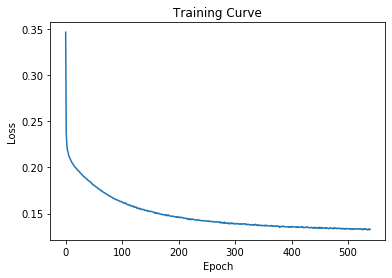

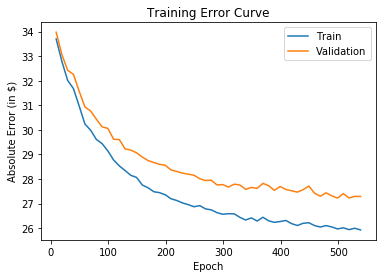

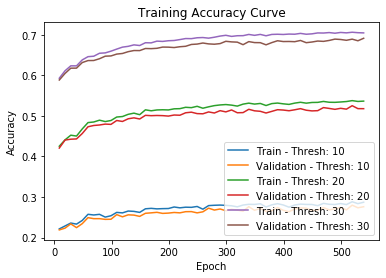

---[ITER 10] loss: 0.127633  time: 3.242
---[ITER 20] loss: 0.129432  time: 2.994
---[ITER 30] loss: 0.136224  time: 3.067
---[ITER 40] loss: 0.133774  time: 2.960
---[ITER 50] loss: 0.135405  time: 2.906
---[ITER 60] loss: 0.135494  time: 2.974
---[ITER 70] loss: 0.133428  time: 3.100
---[ITER 80] loss: 0.132523  time: 3.069
---[ITER 90] loss: 0.126288  time: 3.080
---[ITER 100] loss: 0.130297  time: 3.086
---[ITER 110] loss: 0.130912  time: 3.067
---[ITER 120] loss: 0.134449  time: 3.228
---[ITER 130] loss: 0.135356  time: 3.527
---[ITER 140] loss: 0.130632  time: 3.090
---[ITER 150] loss: 0.133835  time: 3.133
---[ITER 160] loss: 0.135060  time: 2.939
[EPOCH 541] loss: 0.132395  time: 51.753
---[ITER 10] loss: 0.137087  time: 2.906
---[ITER 20] loss: 0.128246  time: 2.907
---[ITER 30] loss: 0.134805  time: 2.999
---[ITER 40] loss: 0.131479  time: 3.020
---[ITER 50] loss: 0.131314  time: 3.099
---[ITER 60] loss: 0.136455  time: 2.915
---[ITER 70] loss: 0.129523  time: 2.768
---[ITER 

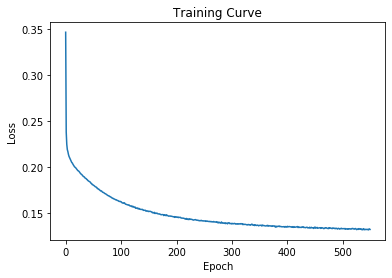

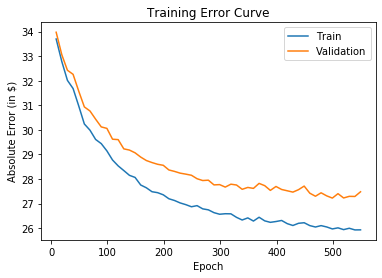

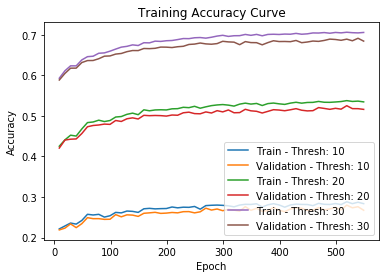

---[ITER 10] loss: 0.133484  time: 3.074
---[ITER 20] loss: 0.132748  time: 3.183
---[ITER 30] loss: 0.125792  time: 3.172
---[ITER 40] loss: 0.132895  time: 2.908
---[ITER 50] loss: 0.131515  time: 2.969
---[ITER 60] loss: 0.133000  time: 3.021
---[ITER 70] loss: 0.137345  time: 2.990
---[ITER 80] loss: 0.132759  time: 2.989
---[ITER 90] loss: 0.129330  time: 3.000
---[ITER 100] loss: 0.134010  time: 2.940
---[ITER 110] loss: 0.135987  time: 2.988
---[ITER 120] loss: 0.133265  time: 3.245
---[ITER 130] loss: 0.130361  time: 2.987
---[ITER 140] loss: 0.131416  time: 2.979
---[ITER 150] loss: 0.131472  time: 2.885
---[ITER 160] loss: 0.132659  time: 2.903
[EPOCH 551] loss: 0.132657  time: 50.435
---[ITER 10] loss: 0.130473  time: 2.865
---[ITER 20] loss: 0.134408  time: 2.962
---[ITER 30] loss: 0.134290  time: 3.132
---[ITER 40] loss: 0.132130  time: 3.248
---[ITER 50] loss: 0.132908  time: 3.115
---[ITER 60] loss: 0.136633  time: 3.330
---[ITER 70] loss: 0.131018  time: 3.031
---[ITER 

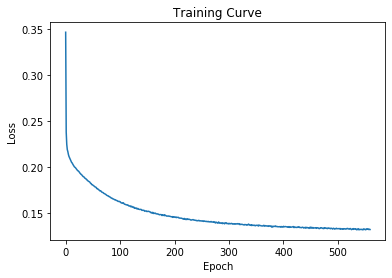

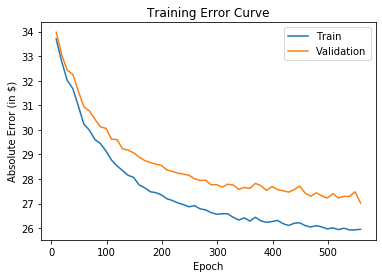

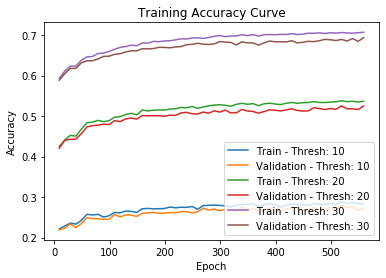

---[ITER 10] loss: 0.131104  time: 2.943
---[ITER 20] loss: 0.133789  time: 2.881
---[ITER 30] loss: 0.135428  time: 3.034
---[ITER 40] loss: 0.131772  time: 3.030
---[ITER 50] loss: 0.133661  time: 3.145
---[ITER 60] loss: 0.134567  time: 3.462
---[ITER 70] loss: 0.131379  time: 3.369
---[ITER 80] loss: 0.132364  time: 3.254
---[ITER 90] loss: 0.131877  time: 3.233
---[ITER 100] loss: 0.132826  time: 3.141
---[ITER 110] loss: 0.136125  time: 3.171
---[ITER 120] loss: 0.127522  time: 3.149
---[ITER 130] loss: 0.132054  time: 3.587
---[ITER 140] loss: 0.138287  time: 3.292
---[ITER 150] loss: 0.130555  time: 3.046
---[ITER 160] loss: 0.134347  time: 3.004
[EPOCH 561] loss: 0.132881  time: 53.211
---[ITER 10] loss: 0.128220  time: 3.474
---[ITER 20] loss: 0.137396  time: 3.340
---[ITER 30] loss: 0.130709  time: 3.252
---[ITER 40] loss: 0.131901  time: 3.211
---[ITER 50] loss: 0.137272  time: 3.084
---[ITER 60] loss: 0.130082  time: 3.135
---[ITER 70] loss: 0.135431  time: 3.189
---[ITER 

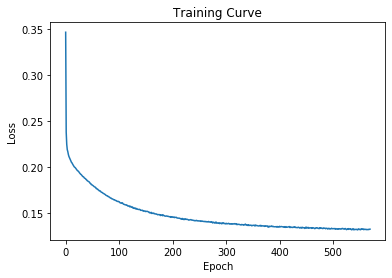

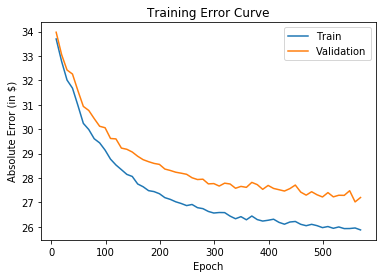

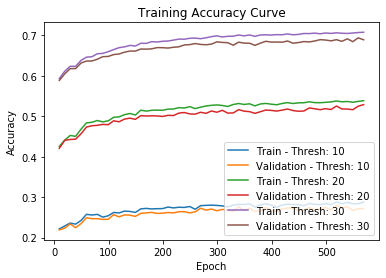

---[ITER 10] loss: 0.132361  time: 3.526
---[ITER 20] loss: 0.133082  time: 3.398
---[ITER 30] loss: 0.135517  time: 3.301
---[ITER 40] loss: 0.132717  time: 3.261
---[ITER 50] loss: 0.133364  time: 3.147
---[ITER 60] loss: 0.127596  time: 3.198
---[ITER 70] loss: 0.134690  time: 3.251
---[ITER 80] loss: 0.136001  time: 3.161
---[ITER 90] loss: 0.133582  time: 3.486
---[ITER 100] loss: 0.139155  time: 3.500
---[ITER 110] loss: 0.131956  time: 3.379
---[ITER 120] loss: 0.130111  time: 3.247
---[ITER 130] loss: 0.133113  time: 3.103
---[ITER 140] loss: 0.130779  time: 3.177
---[ITER 150] loss: 0.132973  time: 3.249
---[ITER 160] loss: 0.134174  time: 3.215
[EPOCH 571] loss: 0.133042  time: 55.066
---[ITER 10] loss: 0.138093  time: 3.140
---[ITER 20] loss: 0.129895  time: 3.354
---[ITER 30] loss: 0.133404  time: 3.154
---[ITER 40] loss: 0.131363  time: 3.358
---[ITER 50] loss: 0.131608  time: 3.645
---[ITER 60] loss: 0.126942  time: 3.111
---[ITER 70] loss: 0.135649  time: 3.112
---[ITER 

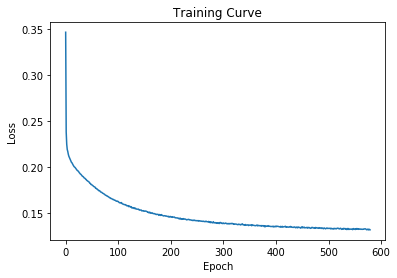

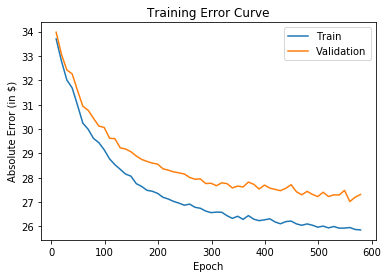

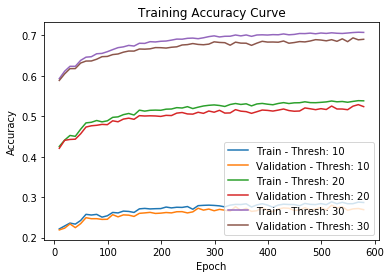

---[ITER 10] loss: 0.138669  time: 3.678
---[ITER 20] loss: 0.131028  time: 3.261
---[ITER 30] loss: 0.131865  time: 3.010
---[ITER 40] loss: 0.129070  time: 3.450
---[ITER 50] loss: 0.132057  time: 3.120
---[ITER 60] loss: 0.132244  time: 3.089
---[ITER 70] loss: 0.129990  time: 4.337
---[ITER 80] loss: 0.132349  time: 3.720
---[ITER 90] loss: 0.127269  time: 3.639
---[ITER 100] loss: 0.133971  time: 3.590
---[ITER 110] loss: 0.136228  time: 3.652
---[ITER 120] loss: 0.131693  time: 3.319
---[ITER 130] loss: 0.129120  time: 3.702
---[ITER 140] loss: 0.134221  time: 4.362
---[ITER 150] loss: 0.134990  time: 3.475
---[ITER 160] loss: 0.129136  time: 3.388
[EPOCH 581] loss: 0.132256  time: 59.526
---[ITER 10] loss: 0.134317  time: 3.741
---[ITER 20] loss: 0.131507  time: 4.163
---[ITER 30] loss: 0.134628  time: 2.960
---[ITER 40] loss: 0.133819  time: 3.016
---[ITER 50] loss: 0.133732  time: 3.032
---[ITER 60] loss: 0.129834  time: 3.151
---[ITER 70] loss: 0.134422  time: 3.438
---[ITER 

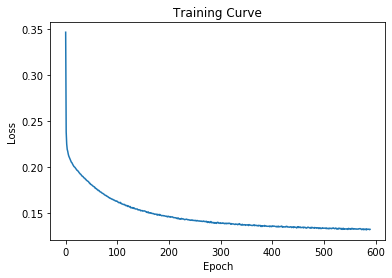

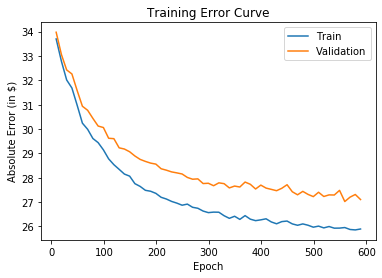

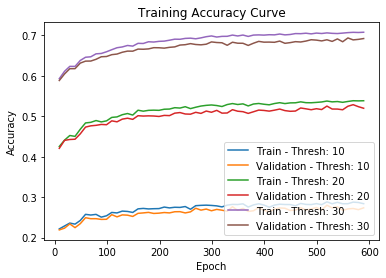

---[ITER 10] loss: 0.133422  time: 3.082
---[ITER 20] loss: 0.133100  time: 3.003
---[ITER 30] loss: 0.134577  time: 3.458
---[ITER 40] loss: 0.132746  time: 3.251
---[ITER 50] loss: 0.133322  time: 3.535
---[ITER 60] loss: 0.128400  time: 3.116
---[ITER 70] loss: 0.134907  time: 3.117
---[ITER 80] loss: 0.133251  time: 3.741
---[ITER 90] loss: 0.129877  time: 3.376
---[ITER 100] loss: 0.134260  time: 3.623
---[ITER 110] loss: 0.133148  time: 3.353
---[ITER 120] loss: 0.131120  time: 3.141
---[ITER 130] loss: 0.131944  time: 3.210
---[ITER 140] loss: 0.130234  time: 3.011
---[ITER 150] loss: 0.132181  time: 3.059
---[ITER 160] loss: 0.131737  time: 3.124
[EPOCH 591] loss: 0.132471  time: 54.583
---[ITER 10] loss: 0.131427  time: 3.134
---[ITER 20] loss: 0.135295  time: 3.093
---[ITER 30] loss: 0.130027  time: 2.943
---[ITER 40] loss: 0.128727  time: 2.898
---[ITER 50] loss: 0.132199  time: 3.035
---[ITER 60] loss: 0.128155  time: 3.072
---[ITER 70] loss: 0.130576  time: 3.121
---[ITER 

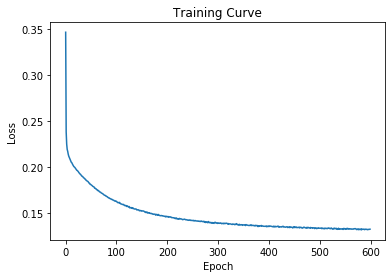

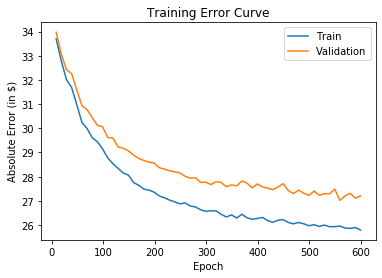

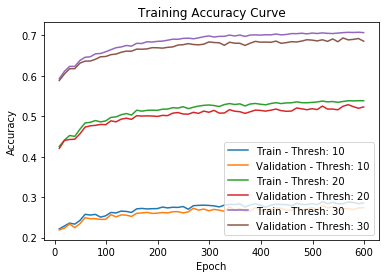

---[ITER 10] loss: 0.127056  time: 2.997
---[ITER 20] loss: 0.134885  time: 2.942
---[ITER 30] loss: 0.133658  time: 3.270
---[ITER 40] loss: 0.129546  time: 3.597
---[ITER 50] loss: 0.129766  time: 3.005
---[ITER 60] loss: 0.133137  time: 2.908
---[ITER 70] loss: 0.134508  time: 2.954
---[ITER 80] loss: 0.133651  time: 2.983
---[ITER 90] loss: 0.128087  time: 3.011
---[ITER 100] loss: 0.131350  time: 3.050
---[ITER 110] loss: 0.127628  time: 2.948
---[ITER 120] loss: 0.134349  time: 2.908
---[ITER 130] loss: 0.129777  time: 2.987
---[ITER 140] loss: 0.132957  time: 3.068
---[ITER 150] loss: 0.133281  time: 3.146
---[ITER 160] loss: 0.136477  time: 2.965
[EPOCH 601] loss: 0.131943  time: 50.988
---[ITER 10] loss: 0.130727  time: 3.197
---[ITER 20] loss: 0.131564  time: 2.976
---[ITER 30] loss: 0.134558  time: 3.024
---[ITER 40] loss: 0.130248  time: 3.187
---[ITER 50] loss: 0.131972  time: 3.015
---[ITER 60] loss: 0.132591  time: 3.027
---[ITER 70] loss: 0.135220  time: 3.065
---[ITER 

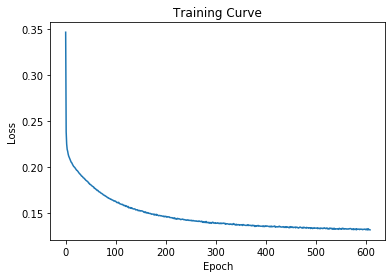

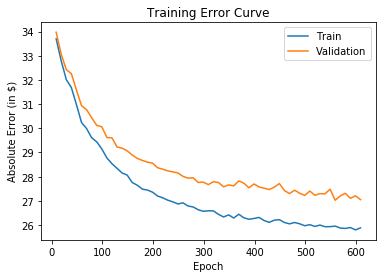

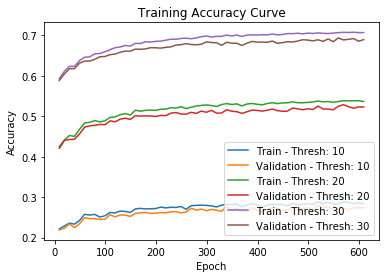

---[ITER 10] loss: 0.128505  time: 2.958
---[ITER 20] loss: 0.134950  time: 2.972
---[ITER 30] loss: 0.134464  time: 3.077
---[ITER 40] loss: 0.132686  time: 3.082
---[ITER 50] loss: 0.133906  time: 3.068
---[ITER 60] loss: 0.134032  time: 3.062
---[ITER 70] loss: 0.126642  time: 2.912
---[ITER 80] loss: 0.133992  time: 2.920
---[ITER 90] loss: 0.132611  time: 3.289
---[ITER 100] loss: 0.133966  time: 3.069
---[ITER 110] loss: 0.130124  time: 3.026
---[ITER 120] loss: 0.128185  time: 3.041
---[ITER 130] loss: 0.132144  time: 3.031
---[ITER 140] loss: 0.132687  time: 3.001
---[ITER 150] loss: 0.135362  time: 2.918
---[ITER 160] loss: 0.129795  time: 2.971
[EPOCH 611] loss: 0.132136  time: 50.758
---[ITER 10] loss: 0.131968  time: 3.089
---[ITER 20] loss: 0.134960  time: 3.046
---[ITER 30] loss: 0.133447  time: 3.079
---[ITER 40] loss: 0.135783  time: 3.013
---[ITER 50] loss: 0.134975  time: 2.977
---[ITER 60] loss: 0.126700  time: 2.933
---[ITER 70] loss: 0.129727  time: 2.888
---[ITER 

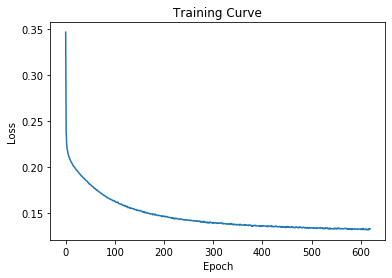

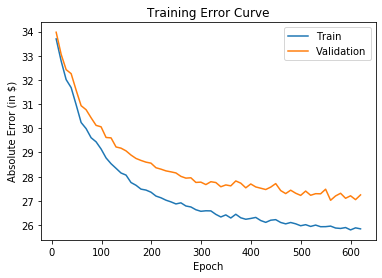

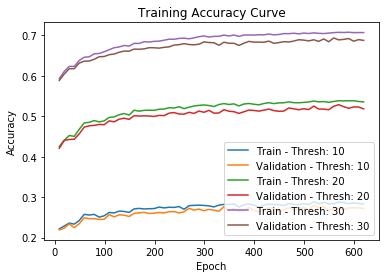

---[ITER 10] loss: 0.132677  time: 3.337
---[ITER 20] loss: 0.129377  time: 3.517
---[ITER 30] loss: 0.135264  time: 3.120
---[ITER 40] loss: 0.130717  time: 3.084
---[ITER 50] loss: 0.129147  time: 3.203
---[ITER 60] loss: 0.128406  time: 3.280
---[ITER 70] loss: 0.134114  time: 3.449
---[ITER 80] loss: 0.137103  time: 3.119
---[ITER 90] loss: 0.135108  time: 3.857
---[ITER 100] loss: 0.131186  time: 3.596
---[ITER 110] loss: 0.133870  time: 3.497
---[ITER 120] loss: 0.135171  time: 4.869
---[ITER 130] loss: 0.132402  time: 3.771
---[ITER 140] loss: 0.134388  time: 4.131
---[ITER 150] loss: 0.127523  time: 5.543
---[ITER 160] loss: 0.127243  time: 3.126
[EPOCH 621] loss: 0.132016  time: 60.875
---[ITER 10] loss: 0.134325  time: 3.021
---[ITER 20] loss: 0.129399  time: 3.205
---[ITER 30] loss: 0.128230  time: 3.117
---[ITER 40] loss: 0.130608  time: 3.085
---[ITER 50] loss: 0.131875  time: 4.577
---[ITER 60] loss: 0.133669  time: 3.285
---[ITER 70] loss: 0.133836  time: 3.038
---[ITER 

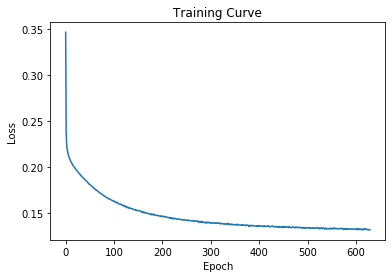

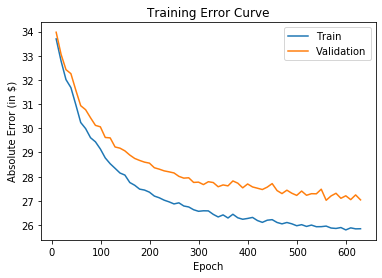

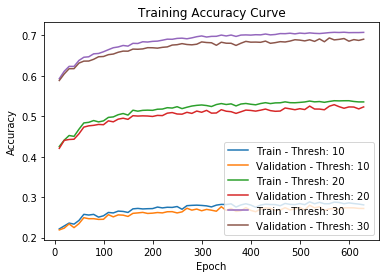

---[ITER 10] loss: 0.127056  time: 3.525
---[ITER 20] loss: 0.128589  time: 3.346
---[ITER 30] loss: 0.134230  time: 3.224
---[ITER 40] loss: 0.133226  time: 3.134
---[ITER 50] loss: 0.129938  time: 3.189
---[ITER 60] loss: 0.134201  time: 3.220
---[ITER 70] loss: 0.134561  time: 3.201
---[ITER 80] loss: 0.128907  time: 3.117
---[ITER 90] loss: 0.131417  time: 3.145
---[ITER 100] loss: 0.130783  time: 3.699
---[ITER 110] loss: 0.135116  time: 3.043
---[ITER 120] loss: 0.133651  time: 3.098
---[ITER 130] loss: 0.130503  time: 3.290
---[ITER 140] loss: 0.134672  time: 4.992
---[ITER 150] loss: 0.136558  time: 4.466
---[ITER 160] loss: 0.132686  time: 3.246
[EPOCH 631] loss: 0.132279  time: 57.565
---[ITER 10] loss: 0.130819  time: 3.171
---[ITER 20] loss: 0.132082  time: 3.163
---[ITER 30] loss: 0.135541  time: 3.266
---[ITER 40] loss: 0.132130  time: 3.228
---[ITER 50] loss: 0.128760  time: 3.144
---[ITER 60] loss: 0.131421  time: 3.040
---[ITER 70] loss: 0.129681  time: 3.349
---[ITER 

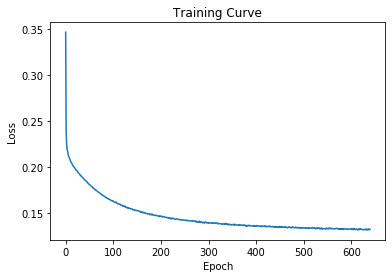

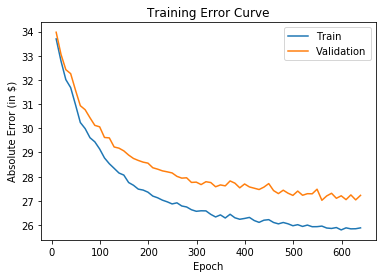

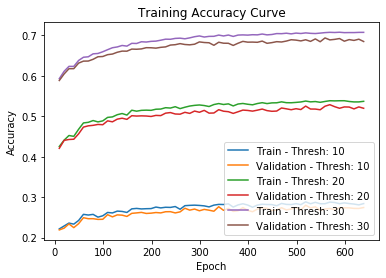

---[ITER 10] loss: 0.130092  time: 3.296
---[ITER 20] loss: 0.129565  time: 3.024
---[ITER 30] loss: 0.127345  time: 3.293
---[ITER 40] loss: 0.132456  time: 3.584
---[ITER 50] loss: 0.132937  time: 3.667
---[ITER 60] loss: 0.129319  time: 4.020
---[ITER 70] loss: 0.130515  time: 3.901
---[ITER 80] loss: 0.132184  time: 3.132
---[ITER 90] loss: 0.128368  time: 3.472
---[ITER 100] loss: 0.135272  time: 3.563
---[ITER 110] loss: 0.132677  time: 4.255
---[ITER 120] loss: 0.129120  time: 3.423
---[ITER 130] loss: 0.132194  time: 3.000
---[ITER 140] loss: 0.131269  time: 3.158
---[ITER 150] loss: 0.133893  time: 3.205
---[ITER 160] loss: 0.131283  time: 3.473
[EPOCH 641] loss: 0.131205  time: 57.895
---[ITER 10] loss: 0.132288  time: 3.217
---[ITER 20] loss: 0.134375  time: 3.225
---[ITER 30] loss: 0.128374  time: 3.013
---[ITER 40] loss: 0.129911  time: 3.134
---[ITER 50] loss: 0.132069  time: 3.241
---[ITER 60] loss: 0.127527  time: 3.196
---[ITER 70] loss: 0.126137  time: 3.436
---[ITER 

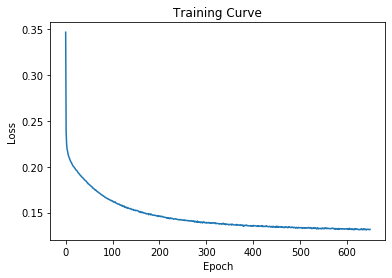

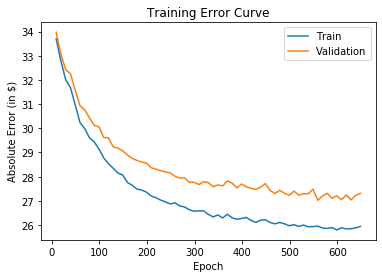

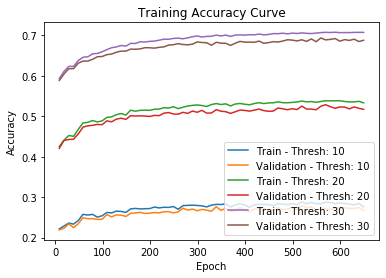

---[ITER 10] loss: 0.131805  time: 4.023
---[ITER 20] loss: 0.135917  time: 3.573
---[ITER 30] loss: 0.135196  time: 4.046
---[ITER 40] loss: 0.131661  time: 3.390
---[ITER 50] loss: 0.131388  time: 3.029
---[ITER 60] loss: 0.130205  time: 3.224
---[ITER 70] loss: 0.128706  time: 3.111
---[ITER 80] loss: 0.133576  time: 3.888
---[ITER 90] loss: 0.127213  time: 3.751
---[ITER 100] loss: 0.133939  time: 3.806
---[ITER 110] loss: 0.131206  time: 3.774
---[ITER 120] loss: 0.130167  time: 3.404
---[ITER 130] loss: 0.132465  time: 3.325
---[ITER 140] loss: 0.125576  time: 3.402
---[ITER 150] loss: 0.131206  time: 3.478
---[ITER 160] loss: 0.134385  time: 3.517
[EPOCH 651] loss: 0.131322  time: 59.421
---[ITER 10] loss: 0.129106  time: 3.251
---[ITER 20] loss: 0.136480  time: 3.378
---[ITER 30] loss: 0.131157  time: 3.206
---[ITER 40] loss: 0.130820  time: 3.214
---[ITER 50] loss: 0.128039  time: 3.372
---[ITER 60] loss: 0.133616  time: 3.354
---[ITER 70] loss: 0.128871  time: 3.034
---[ITER 

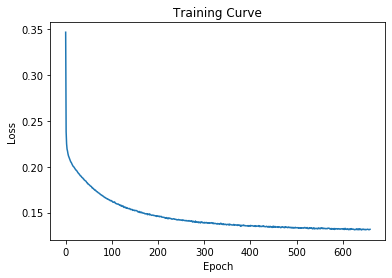

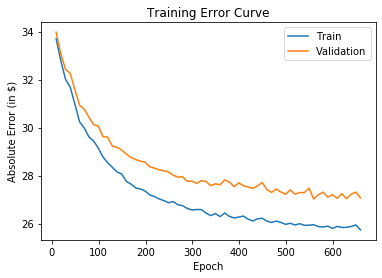

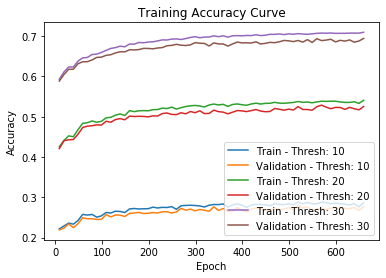

---[ITER 10] loss: 0.133005  time: 3.489
---[ITER 20] loss: 0.130602  time: 3.314
---[ITER 30] loss: 0.134444  time: 3.205
---[ITER 40] loss: 0.132702  time: 3.061
---[ITER 50] loss: 0.129055  time: 3.007
---[ITER 60] loss: 0.130691  time: 3.178
---[ITER 70] loss: 0.135307  time: 3.264
---[ITER 80] loss: 0.130731  time: 3.289
---[ITER 90] loss: 0.129764  time: 3.246
---[ITER 100] loss: 0.136678  time: 3.111
---[ITER 110] loss: 0.129011  time: 3.058
---[ITER 120] loss: 0.132454  time: 3.018
---[ITER 130] loss: 0.130168  time: 3.114
---[ITER 140] loss: 0.129471  time: 3.354
---[ITER 150] loss: 0.133632  time: 3.238
---[ITER 160] loss: 0.128231  time: 3.138
[EPOCH 661] loss: 0.131535  time: 53.500
---[ITER 10] loss: 0.136849  time: 3.314
---[ITER 20] loss: 0.135591  time: 3.176
---[ITER 30] loss: 0.131914  time: 3.094
---[ITER 40] loss: 0.130862  time: 5.277
---[ITER 50] loss: 0.131879  time: 3.278
---[ITER 60] loss: 0.127858  time: 3.087
---[ITER 70] loss: 0.130831  time: 3.394
---[ITER 

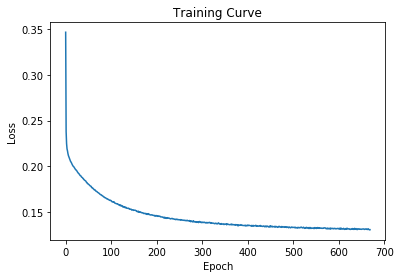

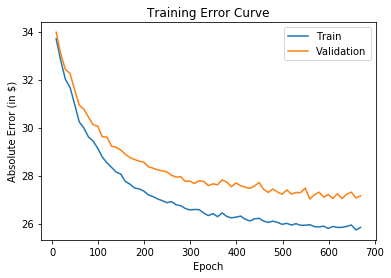

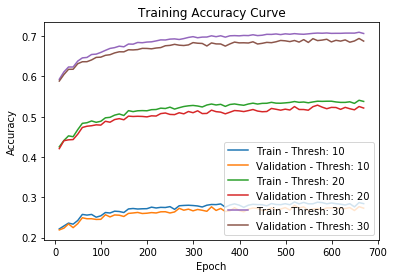

---[ITER 10] loss: 0.131869  time: 3.640
---[ITER 20] loss: 0.133776  time: 3.496
---[ITER 30] loss: 0.129962  time: 3.285
---[ITER 40] loss: 0.129403  time: 3.170
---[ITER 50] loss: 0.135431  time: 3.170
---[ITER 60] loss: 0.130882  time: 3.306
---[ITER 70] loss: 0.132549  time: 3.309
---[ITER 80] loss: 0.130796  time: 3.369
---[ITER 90] loss: 0.129447  time: 3.437
---[ITER 100] loss: 0.129893  time: 3.446
---[ITER 110] loss: 0.135443  time: 3.461
---[ITER 120] loss: 0.129535  time: 3.383
---[ITER 130] loss: 0.131565  time: 3.315
---[ITER 140] loss: 0.129172  time: 3.671
---[ITER 150] loss: 0.131017  time: 3.052
---[ITER 160] loss: 0.128711  time: 3.179
[EPOCH 671] loss: 0.131621  time: 56.152
---[ITER 10] loss: 0.127989  time: 3.005
---[ITER 20] loss: 0.128107  time: 3.306
---[ITER 30] loss: 0.130124  time: 3.134
---[ITER 40] loss: 0.131011  time: 3.170
---[ITER 50] loss: 0.128223  time: 3.449
---[ITER 60] loss: 0.130710  time: 3.434
---[ITER 70] loss: 0.136951  time: 3.351
---[ITER 

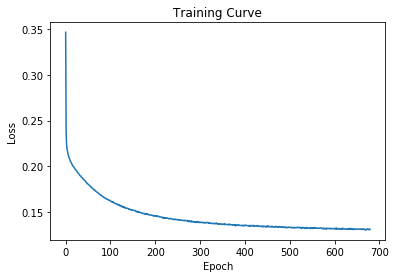

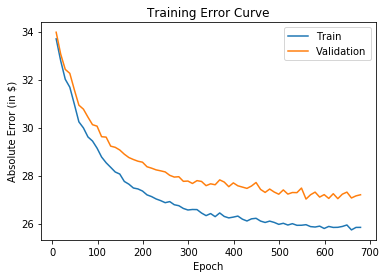

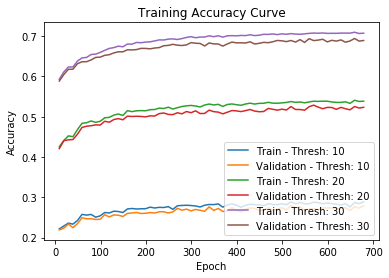

---[ITER 10] loss: 0.132679  time: 3.241
---[ITER 20] loss: 0.126721  time: 3.154
---[ITER 30] loss: 0.134262  time: 3.352
---[ITER 40] loss: 0.134867  time: 3.190
---[ITER 50] loss: 0.129620  time: 3.068
---[ITER 60] loss: 0.132687  time: 3.023
---[ITER 70] loss: 0.131086  time: 3.275
---[ITER 80] loss: 0.130296  time: 3.284
---[ITER 90] loss: 0.131000  time: 3.339
---[ITER 100] loss: 0.126839  time: 3.244
---[ITER 110] loss: 0.134501  time: 3.051
---[ITER 120] loss: 0.130315  time: 3.004
---[ITER 130] loss: 0.131706  time: 4.965
---[ITER 140] loss: 0.132347  time: 5.096
---[ITER 150] loss: 0.133492  time: 3.359
---[ITER 160] loss: 0.135216  time: 3.286
[EPOCH 681] loss: 0.131509  time: 57.543
---[ITER 10] loss: 0.130834  time: 3.233
---[ITER 20] loss: 0.128843  time: 3.554
---[ITER 30] loss: 0.131390  time: 3.349
---[ITER 40] loss: 0.123381  time: 3.213
---[ITER 50] loss: 0.133319  time: 3.181
---[ITER 60] loss: 0.130966  time: 3.097
---[ITER 70] loss: 0.128943  time: 3.222
---[ITER 

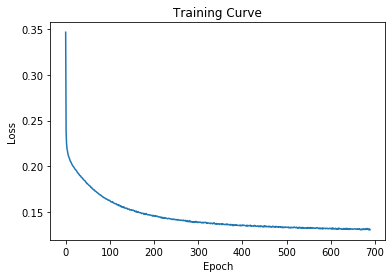

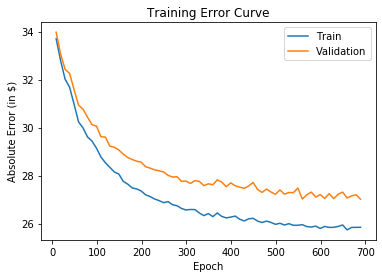

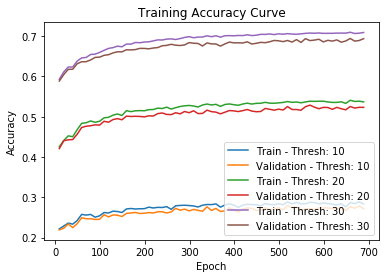

---[ITER 10] loss: 0.134943  time: 3.149
---[ITER 20] loss: 0.131827  time: 3.274
---[ITER 30] loss: 0.129870  time: 3.492
---[ITER 40] loss: 0.125796  time: 3.235
---[ITER 50] loss: 0.130822  time: 3.183
---[ITER 60] loss: 0.131264  time: 3.021
---[ITER 70] loss: 0.135535  time: 2.979
---[ITER 80] loss: 0.128713  time: 3.114
---[ITER 90] loss: 0.127763  time: 3.205
---[ITER 100] loss: 0.138263  time: 3.212
---[ITER 110] loss: 0.130945  time: 3.325
---[ITER 120] loss: 0.127310  time: 3.324
---[ITER 130] loss: 0.131466  time: 3.294
---[ITER 140] loss: 0.129647  time: 3.522
---[ITER 150] loss: 0.133603  time: 5.279
---[ITER 160] loss: 0.130417  time: 4.880
[EPOCH 691] loss: 0.131157  time: 58.844
---[ITER 10] loss: 0.133208  time: 3.605
---[ITER 20] loss: 0.136154  time: 3.764
---[ITER 30] loss: 0.127594  time: 3.856
---[ITER 40] loss: 0.132886  time: 3.855
---[ITER 50] loss: 0.135188  time: 3.647
---[ITER 60] loss: 0.134418  time: 3.565
---[ITER 70] loss: 0.133240  time: 3.517
---[ITER 

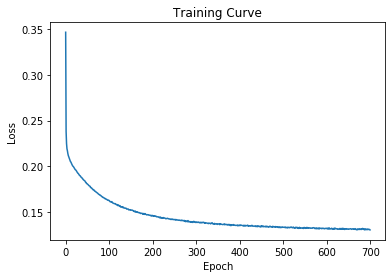

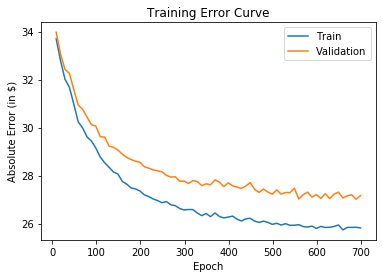

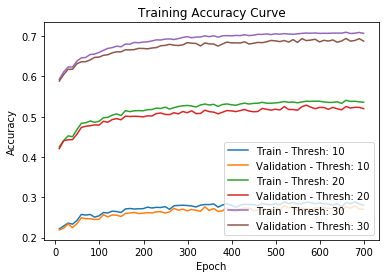

---[ITER 10] loss: 0.128998  time: 3.121
---[ITER 20] loss: 0.134443  time: 3.133
---[ITER 30] loss: 0.128864  time: 3.301
---[ITER 40] loss: 0.133898  time: 3.315
---[ITER 50] loss: 0.135573  time: 3.204
---[ITER 60] loss: 0.133498  time: 3.176
---[ITER 70] loss: 0.133287  time: 3.063
---[ITER 80] loss: 0.129060  time: 3.054
---[ITER 90] loss: 0.132265  time: 3.158
---[ITER 100] loss: 0.131061  time: 3.207
---[ITER 110] loss: 0.127094  time: 3.327
---[ITER 120] loss: 0.134286  time: 3.392
---[ITER 130] loss: 0.134409  time: 3.342
---[ITER 140] loss: 0.129311  time: 3.511
---[ITER 150] loss: 0.128208  time: 3.376
---[ITER 160] loss: 0.124779  time: 3.257
[EPOCH 701] loss: 0.130910  time: 54.533
---[ITER 10] loss: 0.131376  time: 3.046
---[ITER 20] loss: 0.135135  time: 3.152
---[ITER 30] loss: 0.129533  time: 3.329
---[ITER 40] loss: 0.129287  time: 3.351
---[ITER 50] loss: 0.129532  time: 3.267
---[ITER 60] loss: 0.136813  time: 3.173
---[ITER 70] loss: 0.130875  time: 3.066
---[ITER 

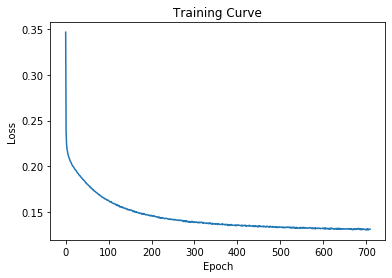

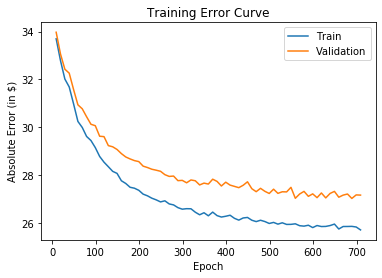

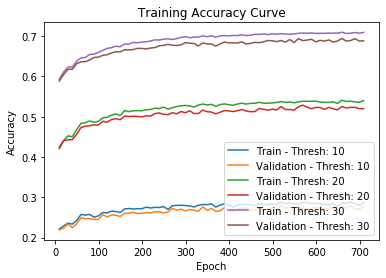

---[ITER 10] loss: 0.132447  time: 3.324
---[ITER 20] loss: 0.128856  time: 3.123
---[ITER 30] loss: 0.129706  time: 3.241
---[ITER 40] loss: 0.132365  time: 3.287
---[ITER 50] loss: 0.133047  time: 3.340
---[ITER 60] loss: 0.134428  time: 3.228
---[ITER 70] loss: 0.133478  time: 3.040
---[ITER 80] loss: 0.130435  time: 3.337
---[ITER 90] loss: 0.128514  time: 3.389
---[ITER 100] loss: 0.132499  time: 3.281
---[ITER 110] loss: 0.131273  time: 3.537
---[ITER 120] loss: 0.129081  time: 3.323
---[ITER 130] loss: 0.135758  time: 3.201
---[ITER 140] loss: 0.132108  time: 3.298
---[ITER 150] loss: 0.131467  time: 3.189
---[ITER 160] loss: 0.130284  time: 3.254
[EPOCH 711] loss: 0.131620  time: 54.979
---[ITER 10] loss: 0.128981  time: 4.670
---[ITER 20] loss: 0.133646  time: 4.117
---[ITER 30] loss: 0.127995  time: 3.397
---[ITER 40] loss: 0.130953  time: 4.005
---[ITER 50] loss: 0.127501  time: 3.716
---[ITER 60] loss: 0.134530  time: 3.902
---[ITER 70] loss: 0.124814  time: 3.358
---[ITER 

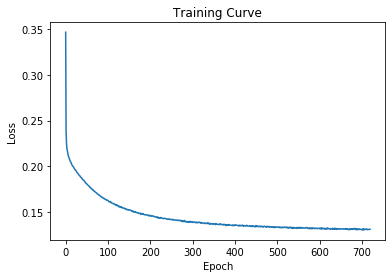

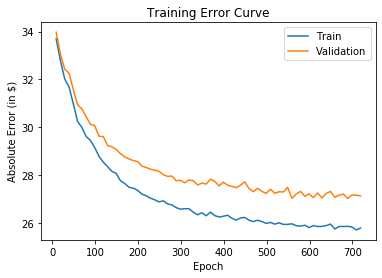

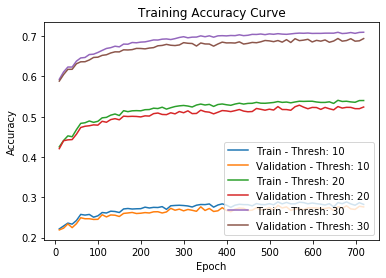

---[ITER 10] loss: 0.129773  time: 4.372
---[ITER 20] loss: 0.129500  time: 4.724
---[ITER 30] loss: 0.133893  time: 3.566
---[ITER 40] loss: 0.129124  time: 5.193
---[ITER 50] loss: 0.128613  time: 6.938
---[ITER 60] loss: 0.131448  time: 4.097
---[ITER 70] loss: 0.130008  time: 3.960
---[ITER 80] loss: 0.132129  time: 4.014
---[ITER 90] loss: 0.136646  time: 4.450
---[ITER 100] loss: 0.132314  time: 4.454
---[ITER 110] loss: 0.133374  time: 3.681
---[ITER 120] loss: 0.130557  time: 3.053
---[ITER 130] loss: 0.130886  time: 3.017
---[ITER 140] loss: 0.130458  time: 3.182
---[ITER 150] loss: 0.131176  time: 3.261
---[ITER 160] loss: 0.127488  time: 3.341
[EPOCH 721] loss: 0.131391  time: 67.886
---[ITER 10] loss: 0.130037  time: 3.349
---[ITER 20] loss: 0.125140  time: 3.403
---[ITER 30] loss: 0.133188  time: 3.612
---[ITER 40] loss: 0.126860  time: 4.127
---[ITER 50] loss: 0.133391  time: 3.552
---[ITER 60] loss: 0.133847  time: 3.379
---[ITER 70] loss: 0.129638  time: 3.305
---[ITER 

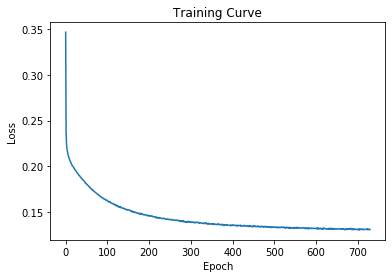

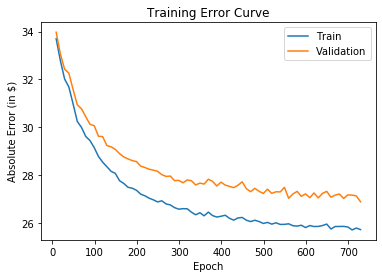

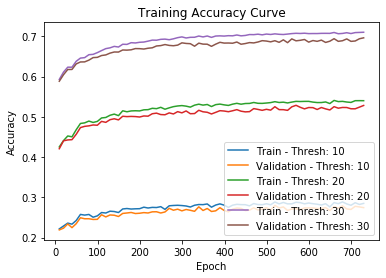

---[ITER 10] loss: 0.129860  time: 3.477
---[ITER 20] loss: 0.128512  time: 3.615
---[ITER 30] loss: 0.135017  time: 3.386
---[ITER 40] loss: 0.132216  time: 3.234
---[ITER 50] loss: 0.128856  time: 3.082
---[ITER 60] loss: 0.133789  time: 2.979
---[ITER 70] loss: 0.128505  time: 3.007
---[ITER 80] loss: 0.131920  time: 3.064
---[ITER 90] loss: 0.126934  time: 3.187
---[ITER 100] loss: 0.132147  time: 3.309
---[ITER 110] loss: 0.129224  time: 3.324
---[ITER 120] loss: 0.133879  time: 3.295
---[ITER 130] loss: 0.134290  time: 3.174
---[ITER 140] loss: 0.128532  time: 3.124
---[ITER 150] loss: 0.130536  time: 3.002
---[ITER 160] loss: 0.131625  time: 3.016
[EPOCH 731] loss: 0.131079  time: 53.651
---[ITER 10] loss: 0.132140  time: 3.058
---[ITER 20] loss: 0.134364  time: 3.179
---[ITER 30] loss: 0.124222  time: 3.110
---[ITER 40] loss: 0.135331  time: 3.255
---[ITER 50] loss: 0.128976  time: 3.450
---[ITER 60] loss: 0.131913  time: 3.267
---[ITER 70] loss: 0.129283  time: 3.372
---[ITER 

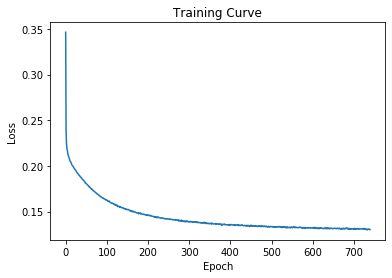

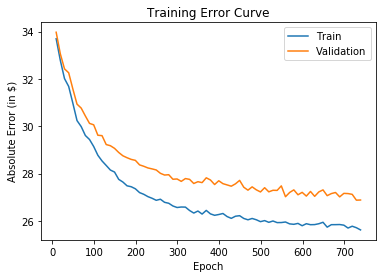

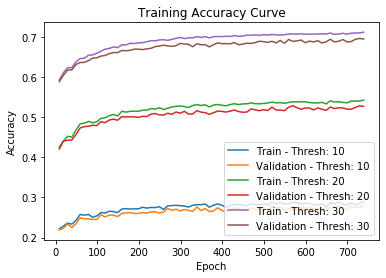

---[ITER 10] loss: 0.131596  time: 3.352
---[ITER 20] loss: 0.130301  time: 3.363
---[ITER 30] loss: 0.128340  time: 3.203
---[ITER 40] loss: 0.129399  time: 3.113
---[ITER 50] loss: 0.131639  time: 3.054
---[ITER 60] loss: 0.130151  time: 3.008
---[ITER 70] loss: 0.133120  time: 3.041
---[ITER 80] loss: 0.129946  time: 3.282
---[ITER 90] loss: 0.128741  time: 3.277
---[ITER 100] loss: 0.129787  time: 3.353
---[ITER 110] loss: 0.132364  time: 3.295
---[ITER 120] loss: 0.129908  time: 3.125
---[ITER 130] loss: 0.133863  time: 3.220
---[ITER 140] loss: 0.129158  time: 3.217
---[ITER 150] loss: 0.130134  time: 3.413
---[ITER 160] loss: 0.128046  time: 3.356
[EPOCH 741] loss: 0.130159  time: 54.183
---[ITER 10] loss: 0.128136  time: 4.201
---[ITER 20] loss: 0.127138  time: 4.050
---[ITER 30] loss: 0.127217  time: 3.241
---[ITER 40] loss: 0.127118  time: 3.276
---[ITER 50] loss: 0.128489  time: 3.156
---[ITER 60] loss: 0.128019  time: 3.195
---[ITER 70] loss: 0.132759  time: 3.354
---[ITER 

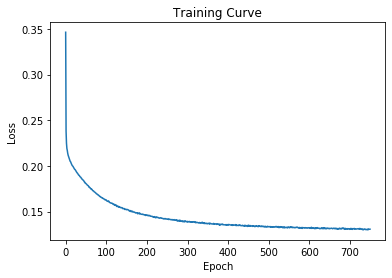

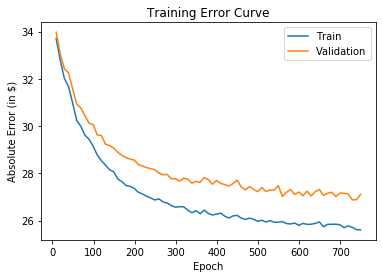

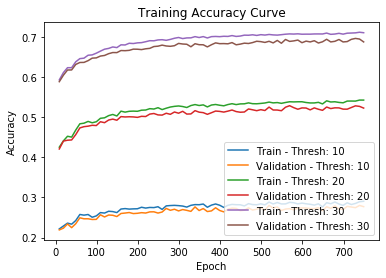

---[ITER 10] loss: 0.125480  time: 5.229
---[ITER 20] loss: 0.131936  time: 3.579
---[ITER 30] loss: 0.130441  time: 3.301
---[ITER 40] loss: 0.134009  time: 3.067
---[ITER 50] loss: 0.129713  time: 3.239
---[ITER 60] loss: 0.128110  time: 3.402
---[ITER 70] loss: 0.128469  time: 3.405
---[ITER 80] loss: 0.134846  time: 3.361
---[ITER 90] loss: 0.134127  time: 3.037
---[ITER 100] loss: 0.133514  time: 3.019
---[ITER 110] loss: 0.129516  time: 3.132
---[ITER 120] loss: 0.134940  time: 3.579
---[ITER 130] loss: 0.131622  time: 3.835
---[ITER 140] loss: 0.129918  time: 5.273
---[ITER 150] loss: 0.124009  time: 4.392
---[ITER 160] loss: 0.129703  time: 3.911
[EPOCH 751] loss: 0.130948  time: 61.699
---[ITER 10] loss: 0.129651  time: 3.617
---[ITER 20] loss: 0.135189  time: 3.140
---[ITER 30] loss: 0.127990  time: 2.971
---[ITER 40] loss: 0.129064  time: 3.093
---[ITER 50] loss: 0.127711  time: 3.266
---[ITER 60] loss: 0.134596  time: 3.234
---[ITER 70] loss: 0.127663  time: 3.164
---[ITER 

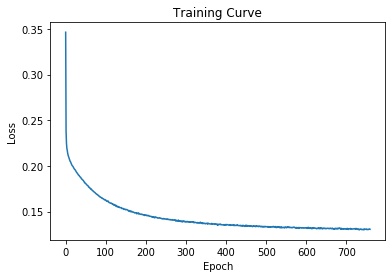

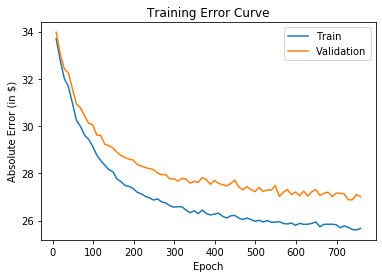

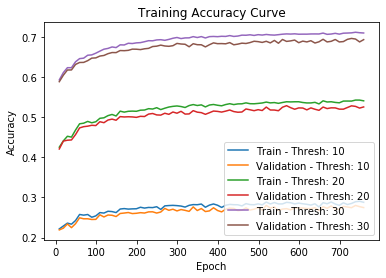

---[ITER 10] loss: 0.133987  time: 3.050
---[ITER 20] loss: 0.132258  time: 3.135
---[ITER 30] loss: 0.130983  time: 3.256
---[ITER 40] loss: 0.125273  time: 3.213
---[ITER 50] loss: 0.129850  time: 3.094
---[ITER 60] loss: 0.134314  time: 3.116
---[ITER 70] loss: 0.128566  time: 3.114
---[ITER 80] loss: 0.132892  time: 3.249
---[ITER 90] loss: 0.130275  time: 3.229
---[ITER 100] loss: 0.130898  time: 3.343
---[ITER 110] loss: 0.130157  time: 3.466
---[ITER 120] loss: 0.126021  time: 3.345
---[ITER 130] loss: 0.128449  time: 3.250
---[ITER 140] loss: 0.129661  time: 3.137
---[ITER 150] loss: 0.128379  time: 3.022
---[ITER 160] loss: 0.130679  time: 3.054
[EPOCH 761] loss: 0.130148  time: 53.433
---[ITER 10] loss: 0.129382  time: 3.056
---[ITER 20] loss: 0.128195  time: 3.142
---[ITER 30] loss: 0.133033  time: 3.350
---[ITER 40] loss: 0.131558  time: 3.327
---[ITER 50] loss: 0.130806  time: 3.358
---[ITER 60] loss: 0.125331  time: 3.290
---[ITER 70] loss: 0.130288  time: 3.406
---[ITER 

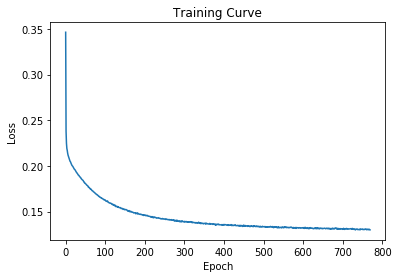

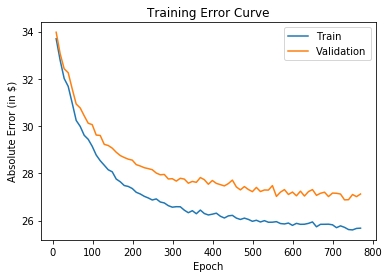

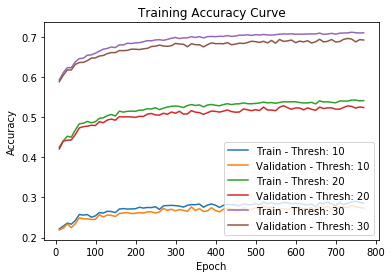

---[ITER 10] loss: 0.131378  time: 3.826
---[ITER 20] loss: 0.129202  time: 16.219
---[ITER 30] loss: 0.128375  time: 5.098
---[ITER 40] loss: 0.127260  time: 4.495
---[ITER 50] loss: 0.127362  time: 256.766
---[ITER 60] loss: 0.129283  time: 6.700
---[ITER 70] loss: 0.131953  time: 5.268
---[ITER 80] loss: 0.131327  time: 9.693
---[ITER 90] loss: 0.130548  time: 3.419
---[ITER 100] loss: 0.132857  time: 4.331
---[ITER 110] loss: 0.135776  time: 4.546
---[ITER 120] loss: 0.134178  time: 3.388
---[ITER 130] loss: 0.127290  time: 3.641
---[ITER 140] loss: 0.130658  time: 3.470
---[ITER 150] loss: 0.132784  time: 2.974
---[ITER 160] loss: 0.131183  time: 3.066
[EPOCH 771] loss: 0.130702  time: 339.503
---[ITER 10] loss: 0.129706  time: 3.028
---[ITER 20] loss: 0.126947  time: 3.304
---[ITER 30] loss: 0.126098  time: 3.049
---[ITER 40] loss: 0.130364  time: 2.976
---[ITER 50] loss: 0.131403  time: 2.998
---[ITER 60] loss: 0.128592  time: 2.933
---[ITER 70] loss: 0.134880  time: 3.083
---[I

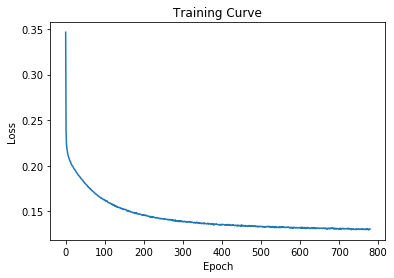

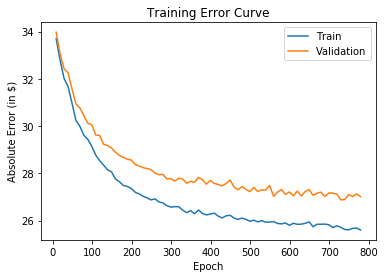

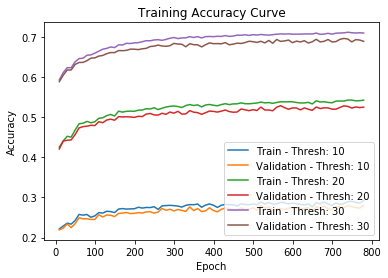

---[ITER 10] loss: 0.131440  time: 3.543
---[ITER 20] loss: 0.130755  time: 3.252
---[ITER 30] loss: 0.132859  time: 3.357
---[ITER 40] loss: 0.131801  time: 3.218
---[ITER 50] loss: 0.128582  time: 3.272
---[ITER 60] loss: 0.132545  time: 3.405
---[ITER 70] loss: 0.129657  time: 3.549
---[ITER 80] loss: 0.131191  time: 3.487
---[ITER 90] loss: 0.135331  time: 3.213
---[ITER 100] loss: 0.130746  time: 3.207
---[ITER 110] loss: 0.129912  time: 3.399
---[ITER 120] loss: 0.129390  time: 3.143
---[ITER 130] loss: 0.128278  time: 3.135
---[ITER 140] loss: 0.128453  time: 3.085
---[ITER 150] loss: 0.128480  time: 3.032
---[ITER 160] loss: 0.128017  time: 3.051
[EPOCH 781] loss: 0.130486  time: 54.753
---[ITER 10] loss: 0.129210  time: 3.202
---[ITER 20] loss: 0.129499  time: 3.092
---[ITER 30] loss: 0.128434  time: 3.064
---[ITER 40] loss: 0.130867  time: 3.033
---[ITER 50] loss: 0.131118  time: 2.935
---[ITER 60] loss: 0.133989  time: 3.039
---[ITER 70] loss: 0.122515  time: 3.035
---[ITER 

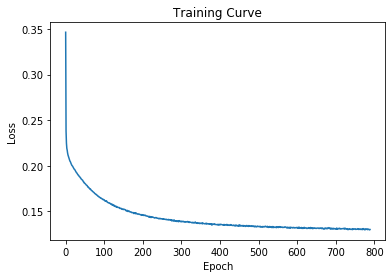

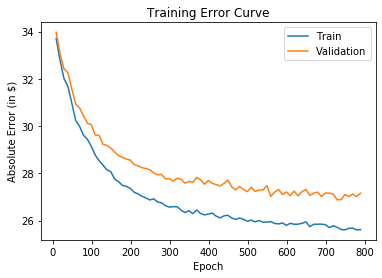

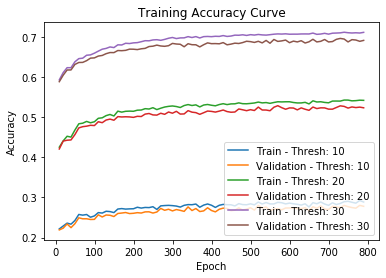

---[ITER 10] loss: 0.130941  time: 3.501
---[ITER 20] loss: 0.129973  time: 3.289
---[ITER 30] loss: 0.131144  time: 3.229
---[ITER 40] loss: 0.130654  time: 3.366
---[ITER 50] loss: 0.132953  time: 3.407
---[ITER 60] loss: 0.136485  time: 3.553
---[ITER 70] loss: 0.137043  time: 3.580
---[ITER 80] loss: 0.127268  time: 3.371
---[ITER 90] loss: 0.129475  time: 3.468
---[ITER 100] loss: 0.128679  time: 3.434
---[ITER 110] loss: 0.126865  time: 3.370
---[ITER 120] loss: 0.127038  time: 3.378
---[ITER 130] loss: 0.132253  time: 3.274
---[ITER 140] loss: 0.133935  time: 3.541
---[ITER 150] loss: 0.134757  time: 3.281
---[ITER 160] loss: 0.127336  time: 3.337
[EPOCH 791] loss: 0.130889  time: 57.086
---[ITER 10] loss: 0.132872  time: 3.316
---[ITER 20] loss: 0.129609  time: 3.464
---[ITER 30] loss: 0.132045  time: 3.507
---[ITER 40] loss: 0.129877  time: 3.234
---[ITER 50] loss: 0.131261  time: 3.196
---[ITER 60] loss: 0.128144  time: 3.238
---[ITER 70] loss: 0.129755  time: 3.299
---[ITER 

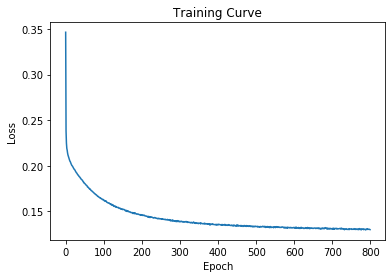

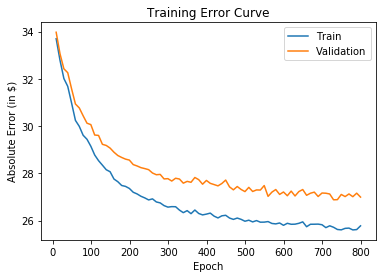

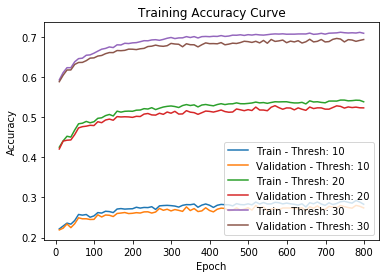

---[ITER 10] loss: 0.126515  time: 3.354
---[ITER 20] loss: 0.130189  time: 3.297
---[ITER 30] loss: 0.128516  time: 4.080
---[ITER 40] loss: 0.130117  time: 3.685
---[ITER 50] loss: 0.136662  time: 3.550
---[ITER 60] loss: 0.128314  time: 3.237
---[ITER 70] loss: 0.132469  time: 3.164
---[ITER 80] loss: 0.135431  time: 3.344
---[ITER 90] loss: 0.130043  time: 3.361
---[ITER 100] loss: 0.129687  time: 3.294
---[ITER 110] loss: 0.128321  time: 3.328
---[ITER 120] loss: 0.131217  time: 3.215
---[ITER 130] loss: 0.126660  time: 3.622
---[ITER 140] loss: 0.130369  time: 3.557
---[ITER 150] loss: 0.135160  time: 3.557
---[ITER 160] loss: 0.129034  time: 3.436
[EPOCH 801] loss: 0.130599  time: 57.607
---[ITER 10] loss: 0.134239  time: 3.639
---[ITER 20] loss: 0.126903  time: 3.351
---[ITER 30] loss: 0.133089  time: 3.211
---[ITER 40] loss: 0.130160  time: 3.270
---[ITER 50] loss: 0.131821  time: 3.232
---[ITER 60] loss: 0.131504  time: 3.292
---[ITER 70] loss: 0.127197  time: 3.436
---[ITER 

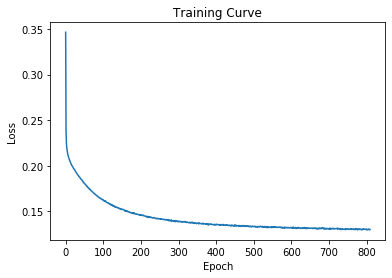

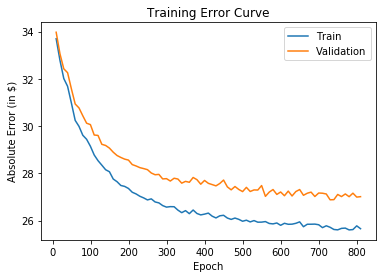

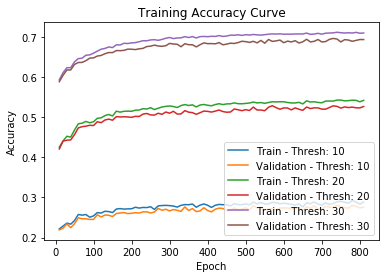

---[ITER 10] loss: 0.130372  time: 3.922
---[ITER 20] loss: 0.128721  time: 3.729
---[ITER 30] loss: 0.131046  time: 3.359
---[ITER 40] loss: 0.132278  time: 3.306
---[ITER 50] loss: 0.128644  time: 3.268
---[ITER 60] loss: 0.126107  time: 4.117
---[ITER 70] loss: 0.130134  time: 4.868
---[ITER 80] loss: 0.131613  time: 3.306
---[ITER 90] loss: 0.130884  time: 3.224
---[ITER 100] loss: 0.132853  time: 3.613
---[ITER 110] loss: 0.133916  time: 4.782
---[ITER 120] loss: 0.126583  time: 3.650
---[ITER 130] loss: 0.137683  time: 3.694
---[ITER 140] loss: 0.129316  time: 3.101
---[ITER 150] loss: 0.128129  time: 3.391
---[ITER 160] loss: 0.132907  time: 3.530
[EPOCH 811] loss: 0.130609  time: 61.487
---[ITER 10] loss: 0.129190  time: 3.834
---[ITER 20] loss: 0.129446  time: 4.370
---[ITER 30] loss: 0.131251  time: 3.086
---[ITER 40] loss: 0.130323  time: 3.907
---[ITER 50] loss: 0.132204  time: 3.511
---[ITER 60] loss: 0.131786  time: 3.528
---[ITER 70] loss: 0.126993  time: 3.007
---[ITER 

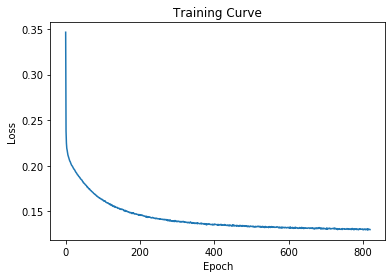

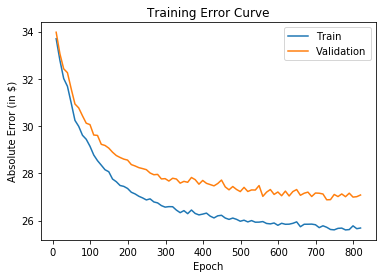

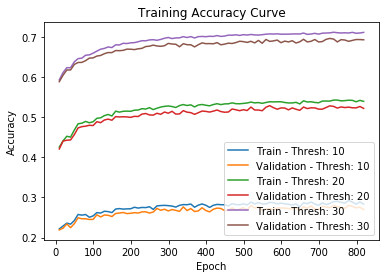

---[ITER 10] loss: 0.133842  time: 3.713
---[ITER 20] loss: 0.130520  time: 3.141
---[ITER 30] loss: 0.132290  time: 2.908
---[ITER 40] loss: 0.124619  time: 2.995
---[ITER 50] loss: 0.129388  time: 3.146
---[ITER 60] loss: 0.136369  time: 4.690
---[ITER 70] loss: 0.131157  time: 3.156
---[ITER 80] loss: 0.131468  time: 3.022
---[ITER 90] loss: 0.127261  time: 3.688
---[ITER 100] loss: 0.126721  time: 3.327
---[ITER 110] loss: 0.129794  time: 3.691
---[ITER 120] loss: 0.127154  time: 4.517
---[ITER 130] loss: 0.129183  time: 3.523
---[ITER 140] loss: 0.124921  time: 3.878
---[ITER 150] loss: 0.130035  time: 4.306
---[ITER 160] loss: 0.134511  time: 2.996
[EPOCH 821] loss: 0.130025  time: 59.707
---[ITER 10] loss: 0.125979  time: 4.054
---[ITER 20] loss: 0.135227  time: 3.381
---[ITER 30] loss: 0.129781  time: 3.021
---[ITER 40] loss: 0.127618  time: 2.986
---[ITER 50] loss: 0.128447  time: 2.917
---[ITER 60] loss: 0.124449  time: 2.901
---[ITER 70] loss: 0.130483  time: 2.910
---[ITER 

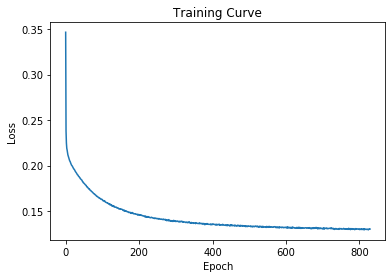

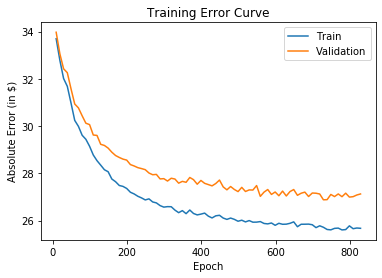

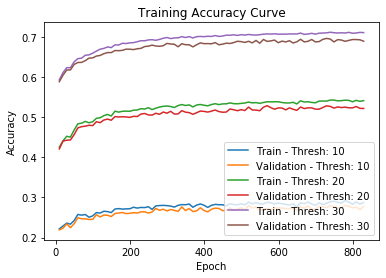

---[ITER 10] loss: 0.128917  time: 3.065
---[ITER 20] loss: 0.132745  time: 3.053
---[ITER 30] loss: 0.123123  time: 2.966
---[ITER 40] loss: 0.128373  time: 3.376
---[ITER 50] loss: 0.133231  time: 3.007
---[ITER 60] loss: 0.132697  time: 3.092
---[ITER 70] loss: 0.126465  time: 3.082
---[ITER 80] loss: 0.126048  time: 3.109
---[ITER 90] loss: 0.129561  time: 3.228
---[ITER 100] loss: 0.133355  time: 3.116
---[ITER 110] loss: 0.133338  time: 2.951
---[ITER 120] loss: 0.130401  time: 2.911
---[ITER 130] loss: 0.132564  time: 2.867
---[ITER 140] loss: 0.130411  time: 2.980
---[ITER 150] loss: 0.129309  time: 2.962
---[ITER 160] loss: 0.130068  time: 2.991
[EPOCH 831] loss: 0.130143  time: 51.079
---[ITER 10] loss: 0.130730  time: 2.982
---[ITER 20] loss: 0.129759  time: 3.041
---[ITER 30] loss: 0.126225  time: 2.971
---[ITER 40] loss: 0.133514  time: 2.963
---[ITER 50] loss: 0.130881  time: 2.958
---[ITER 60] loss: 0.129918  time: 2.920
---[ITER 70] loss: 0.129173  time: 2.975
---[ITER 

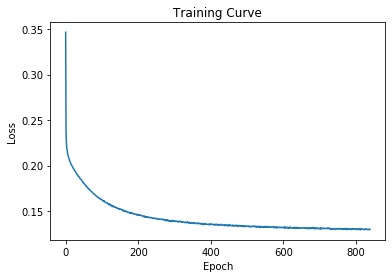

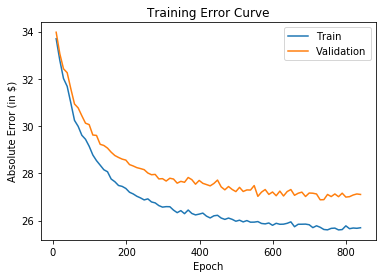

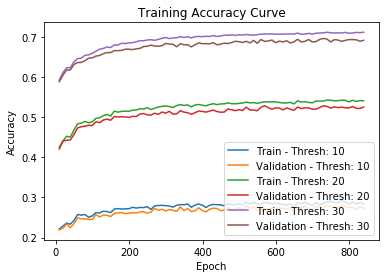

---[ITER 10] loss: 0.123689  time: 3.360
---[ITER 20] loss: 0.129066  time: 3.499
---[ITER 30] loss: 0.129310  time: 3.377
---[ITER 40] loss: 0.126514  time: 3.413
---[ITER 50] loss: 0.127919  time: 3.526
---[ITER 60] loss: 0.130423  time: 3.555
---[ITER 70] loss: 0.128678  time: 3.653
---[ITER 80] loss: 0.132261  time: 3.532
---[ITER 90] loss: 0.131306  time: 3.356
---[ITER 100] loss: 0.135982  time: 3.385
---[ITER 110] loss: 0.130020  time: 3.064
---[ITER 120] loss: 0.127137  time: 3.224
---[ITER 130] loss: 0.131637  time: 3.108
---[ITER 140] loss: 0.128771  time: 3.515
---[ITER 150] loss: 0.129713  time: 3.683
---[ITER 160] loss: 0.134402  time: 3.294
[EPOCH 841] loss: 0.129870  time: 57.080
---[ITER 10] loss: 0.128142  time: 3.403
---[ITER 20] loss: 0.126853  time: 3.441
---[ITER 30] loss: 0.131024  time: 3.518
---[ITER 40] loss: 0.131319  time: 3.903
---[ITER 50] loss: 0.132829  time: 3.321
---[ITER 60] loss: 0.131149  time: 3.264
---[ITER 70] loss: 0.134714  time: 3.130
---[ITER 

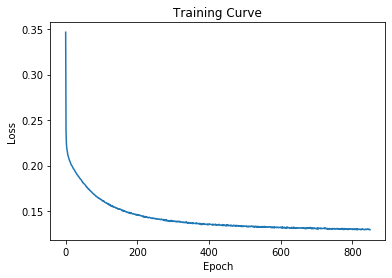

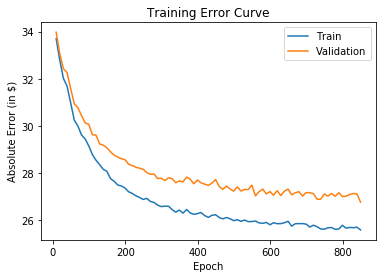

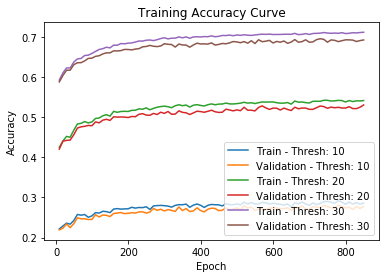

---[ITER 10] loss: 0.129862  time: 3.441
---[ITER 20] loss: 0.127933  time: 3.219
---[ITER 30] loss: 0.127035  time: 4.057
---[ITER 40] loss: 0.129937  time: 3.692
---[ITER 50] loss: 0.131446  time: 3.676
---[ITER 60] loss: 0.129353  time: 4.201
---[ITER 70] loss: 0.130763  time: 3.680
---[ITER 80] loss: 0.127388  time: 3.725
---[ITER 90] loss: 0.126088  time: 3.455
---[ITER 100] loss: 0.133819  time: 3.607
---[ITER 110] loss: 0.126984  time: 3.590
---[ITER 120] loss: 0.129317  time: 3.684
---[ITER 130] loss: 0.129225  time: 3.539
---[ITER 140] loss: 0.131496  time: 3.402
---[ITER 150] loss: 0.128920  time: 3.379
---[ITER 160] loss: 0.133018  time: 3.465
[EPOCH 851] loss: 0.129589  time: 60.692
---[ITER 10] loss: 0.128785  time: 3.414
---[ITER 20] loss: 0.127533  time: 3.689
---[ITER 30] loss: 0.130395  time: 3.919
---[ITER 40] loss: 0.127432  time: 3.698
---[ITER 50] loss: 0.129849  time: 3.250
---[ITER 60] loss: 0.129660  time: 3.784
---[ITER 70] loss: 0.130122  time: 3.249
---[ITER 

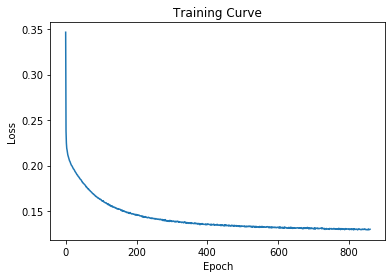

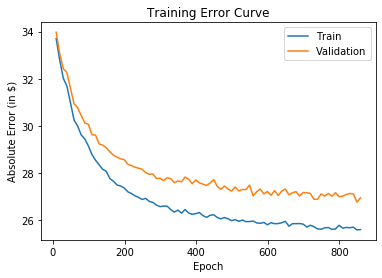

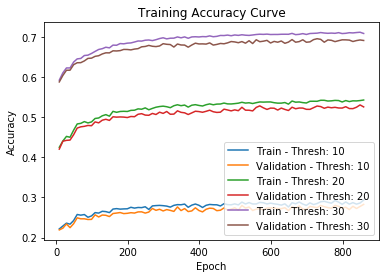

---[ITER 10] loss: 0.131839  time: 3.862
---[ITER 20] loss: 0.128534  time: 3.657
---[ITER 30] loss: 0.129949  time: 3.765
---[ITER 40] loss: 0.125019  time: 3.764
---[ITER 50] loss: 0.131764  time: 3.514
---[ITER 60] loss: 0.132091  time: 5.596
---[ITER 70] loss: 0.131817  time: 4.542
---[ITER 80] loss: 0.125272  time: 3.811
---[ITER 90] loss: 0.130260  time: 3.551
---[ITER 100] loss: 0.128958  time: 3.316
---[ITER 110] loss: 0.130371  time: 4.019
---[ITER 120] loss: 0.130697  time: 3.558
---[ITER 130] loss: 0.134940  time: 3.396
---[ITER 140] loss: 0.132391  time: 3.340
---[ITER 150] loss: 0.131474  time: 3.661
---[ITER 160] loss: 0.130525  time: 3.843
[EPOCH 861] loss: 0.130127  time: 64.005
---[ITER 10] loss: 0.129219  time: 4.065
---[ITER 20] loss: 0.122146  time: 4.869
---[ITER 30] loss: 0.127155  time: 4.335
---[ITER 40] loss: 0.134922  time: 4.226
---[ITER 50] loss: 0.128485  time: 3.446
---[ITER 60] loss: 0.131680  time: 3.500
---[ITER 70] loss: 0.128938  time: 4.988
---[ITER 

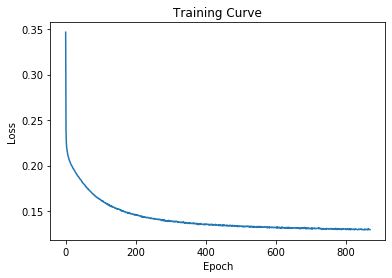

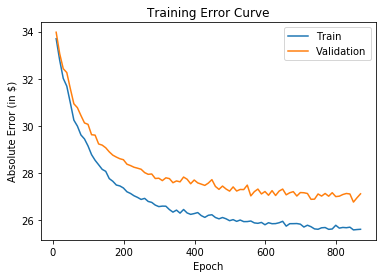

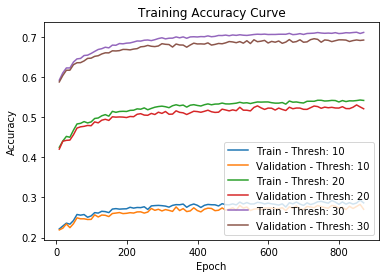

---[ITER 10] loss: 0.132220  time: 3.142
---[ITER 20] loss: 0.126157  time: 3.532
---[ITER 30] loss: 0.130640  time: 3.797
---[ITER 40] loss: 0.129188  time: 3.653
---[ITER 50] loss: 0.125902  time: 3.544
---[ITER 60] loss: 0.136111  time: 3.716
---[ITER 70] loss: 0.132245  time: 3.474
---[ITER 80] loss: 0.128966  time: 3.383
---[ITER 90] loss: 0.133257  time: 3.525
---[ITER 100] loss: 0.124576  time: 3.387
---[ITER 110] loss: 0.129745  time: 3.454
---[ITER 120] loss: 0.130471  time: 3.504
---[ITER 130] loss: 0.131400  time: 3.447
---[ITER 140] loss: 0.131963  time: 3.663
---[ITER 150] loss: 0.132242  time: 3.723
---[ITER 160] loss: 0.132018  time: 3.583
[EPOCH 871] loss: 0.130311  time: 59.197
---[ITER 10] loss: 0.128451  time: 3.436
---[ITER 20] loss: 0.127967  time: 3.428
---[ITER 30] loss: 0.132326  time: 3.329
---[ITER 40] loss: 0.124499  time: 3.429
---[ITER 50] loss: 0.125436  time: 3.354
---[ITER 60] loss: 0.129966  time: 3.422
---[ITER 70] loss: 0.126126  time: 3.346
---[ITER 

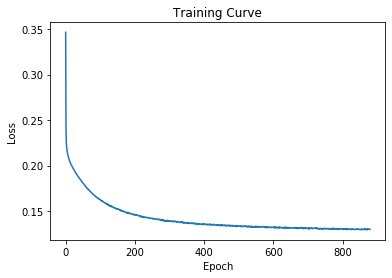

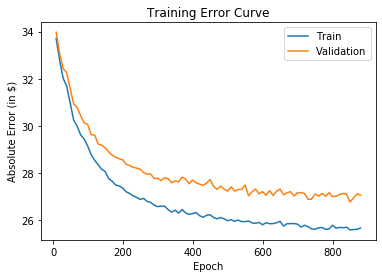

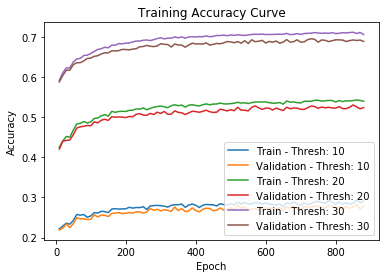

---[ITER 10] loss: 0.129220  time: 3.491
---[ITER 20] loss: 0.127255  time: 3.313
---[ITER 30] loss: 0.127298  time: 3.499
---[ITER 40] loss: 0.124567  time: 3.585
---[ITER 50] loss: 0.129648  time: 3.651
---[ITER 60] loss: 0.125110  time: 3.523
---[ITER 70] loss: 0.128785  time: 3.938
---[ITER 80] loss: 0.128213  time: 3.448
---[ITER 90] loss: 0.137035  time: 3.750
---[ITER 100] loss: 0.131655  time: 4.000
---[ITER 110] loss: 0.124907  time: 3.737
---[ITER 120] loss: 0.132986  time: 3.670
---[ITER 130] loss: 0.129744  time: 3.745
---[ITER 140] loss: 0.135469  time: 4.272
---[ITER 150] loss: 0.129700  time: 3.570
---[ITER 160] loss: 0.133835  time: 3.534
[EPOCH 881] loss: 0.129528  time: 62.078
---[ITER 10] loss: 0.129583  time: 3.689
---[ITER 20] loss: 0.131809  time: 3.250
---[ITER 30] loss: 0.132760  time: 3.661
---[ITER 40] loss: 0.125785  time: 3.529
---[ITER 50] loss: 0.127751  time: 3.179
---[ITER 60] loss: 0.130484  time: 3.320
---[ITER 70] loss: 0.138912  time: 3.588
---[ITER 

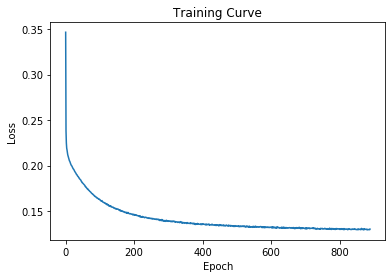

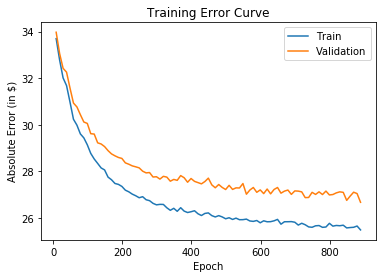

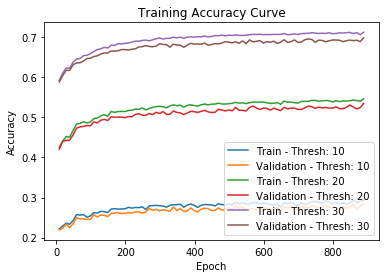

---[ITER 10] loss: 0.133402  time: 6.653
---[ITER 20] loss: 0.127613  time: 4.619
---[ITER 30] loss: 0.129211  time: 3.566
---[ITER 40] loss: 0.130162  time: 3.559
---[ITER 50] loss: 0.130698  time: 3.200
---[ITER 60] loss: 0.126430  time: 3.331
---[ITER 70] loss: 0.133720  time: 3.618
---[ITER 80] loss: 0.130804  time: 3.874
---[ITER 90] loss: 0.131099  time: 3.541
---[ITER 100] loss: 0.125818  time: 3.575
---[ITER 110] loss: 0.129561  time: 3.607
---[ITER 120] loss: 0.131957  time: 3.556
---[ITER 130] loss: 0.129278  time: 4.198
---[ITER 140] loss: 0.130947  time: 3.333
---[ITER 150] loss: 0.131315  time: 3.608
---[ITER 160] loss: 0.121360  time: 3.396
[EPOCH 891] loss: 0.129773  time: 63.832
---[ITER 10] loss: 0.134222  time: 3.253
---[ITER 20] loss: 0.128786  time: 3.619
---[ITER 30] loss: 0.130209  time: 3.626
---[ITER 40] loss: 0.126892  time: 3.662
---[ITER 50] loss: 0.128453  time: 3.574
---[ITER 60] loss: 0.132678  time: 3.749
---[ITER 70] loss: 0.128353  time: 3.350
---[ITER 

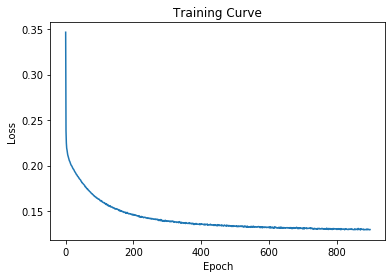

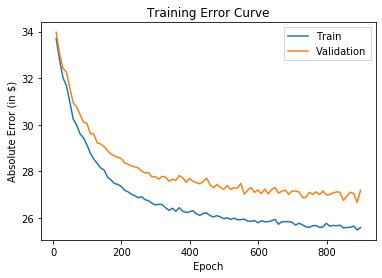

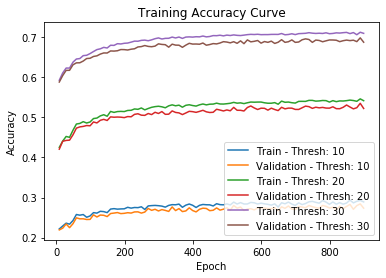

---[ITER 10] loss: 0.126240  time: 3.964
---[ITER 20] loss: 0.129356  time: 3.648
---[ITER 30] loss: 0.130711  time: 3.600
---[ITER 40] loss: 0.135389  time: 3.529
---[ITER 50] loss: 0.132319  time: 3.683
---[ITER 60] loss: 0.133903  time: 3.223
---[ITER 70] loss: 0.132268  time: 3.159
---[ITER 80] loss: 0.129185  time: 3.210
---[ITER 90] loss: 0.122029  time: 3.324
---[ITER 100] loss: 0.134406  time: 3.411
---[ITER 110] loss: 0.130793  time: 3.514
---[ITER 120] loss: 0.123356  time: 3.452
---[ITER 130] loss: 0.125734  time: 3.341
---[ITER 140] loss: 0.128478  time: 3.337
---[ITER 150] loss: 0.132459  time: 3.418
---[ITER 160] loss: 0.125370  time: 3.626
[EPOCH 901] loss: 0.129453  time: 58.163
---[ITER 10] loss: 0.128360  time: 3.532
---[ITER 20] loss: 0.133326  time: 3.835
---[ITER 30] loss: 0.127916  time: 3.545
---[ITER 40] loss: 0.131841  time: 3.670
---[ITER 50] loss: 0.126134  time: 3.708
---[ITER 60] loss: 0.130467  time: 3.317
---[ITER 70] loss: 0.126847  time: 3.390
---[ITER 

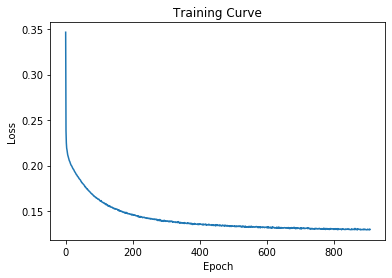

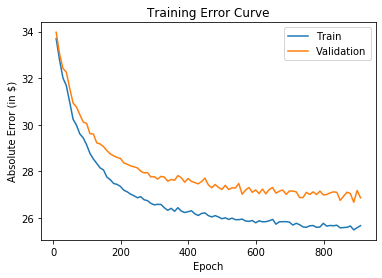

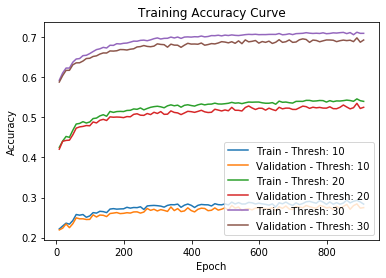

---[ITER 10] loss: 0.129840  time: 3.479
---[ITER 20] loss: 0.131968  time: 4.027
---[ITER 30] loss: 0.125977  time: 4.240
---[ITER 40] loss: 0.125133  time: 5.951
---[ITER 50] loss: 0.134253  time: 4.102
---[ITER 60] loss: 0.132749  time: 3.796
---[ITER 70] loss: 0.130952  time: 3.591
---[ITER 80] loss: 0.123725  time: 3.649
---[ITER 90] loss: 0.125965  time: 3.647
---[ITER 100] loss: 0.134086  time: 3.130
---[ITER 110] loss: 0.129824  time: 3.647
---[ITER 120] loss: 0.124629  time: 4.016
---[ITER 130] loss: 0.128375  time: 3.487
---[ITER 140] loss: 0.132173  time: 4.741
---[ITER 150] loss: 0.127855  time: 3.874
---[ITER 160] loss: 0.127777  time: 5.316
[EPOCH 911] loss: 0.129475  time: 68.542
---[ITER 10] loss: 0.128265  time: 5.711
---[ITER 20] loss: 0.129092  time: 3.861
---[ITER 30] loss: 0.130753  time: 3.373
---[ITER 40] loss: 0.129036  time: 3.444
---[ITER 50] loss: 0.125514  time: 3.485
---[ITER 60] loss: 0.126429  time: 3.570
---[ITER 70] loss: 0.129101  time: 3.363
---[ITER 

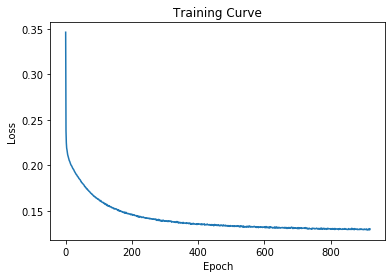

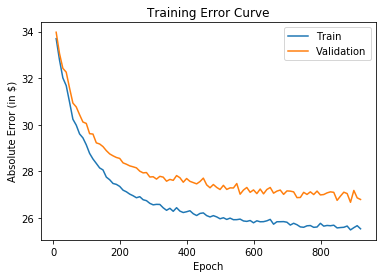

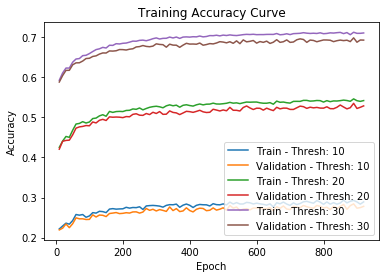

---[ITER 10] loss: 0.132784  time: 3.264
---[ITER 20] loss: 0.126899  time: 3.741
---[ITER 30] loss: 0.125341  time: 3.824
---[ITER 40] loss: 0.128202  time: 5.386
---[ITER 50] loss: 0.128450  time: 18.461
---[ITER 60] loss: 0.130435  time: 4.237
---[ITER 70] loss: 0.129848  time: 3.054
---[ITER 80] loss: 0.127579  time: 5.915
---[ITER 90] loss: 0.134713  time: 3.061
---[ITER 100] loss: 0.131171  time: 3.743
---[ITER 110] loss: 0.128352  time: 3.744
---[ITER 120] loss: 0.125138  time: 4.070
---[ITER 130] loss: 0.129586  time: 3.349
---[ITER 140] loss: 0.126399  time: 4.894
---[ITER 150] loss: 0.135290  time: 42.229
---[ITER 160] loss: 0.126876  time: 11.113
[EPOCH 921] loss: 0.129440  time: 127.017
---[ITER 10] loss: 0.132013  time: 3.842
---[ITER 20] loss: 0.124594  time: 5.506
---[ITER 30] loss: 0.129798  time: 5.858
---[ITER 40] loss: 0.127158  time: 3.993
---[ITER 50] loss: 0.128615  time: 61.145
---[ITER 60] loss: 0.132820  time: 6.720
---[ITER 70] loss: 0.124964  time: 4.361
---[

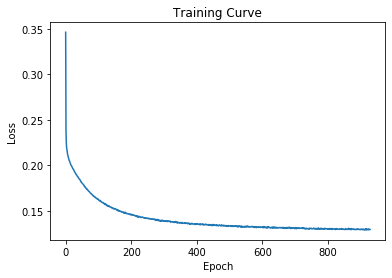

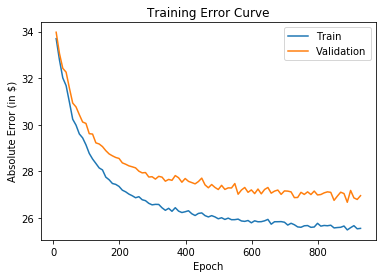

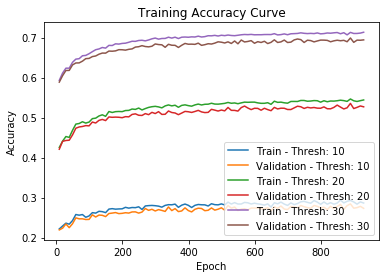

---[ITER 10] loss: 0.127858  time: 3.009
---[ITER 20] loss: 0.129189  time: 3.085
---[ITER 30] loss: 0.132198  time: 3.117
---[ITER 40] loss: 0.129898  time: 3.232
---[ITER 50] loss: 0.126942  time: 3.144
---[ITER 60] loss: 0.127384  time: 3.372
---[ITER 70] loss: 0.126840  time: 4.151
---[ITER 80] loss: 0.131707  time: 4.296
---[ITER 90] loss: 0.131120  time: 3.798
---[ITER 100] loss: 0.135972  time: 3.589
---[ITER 110] loss: 0.128606  time: 3.067
---[ITER 120] loss: 0.128442  time: 2.944
---[ITER 130] loss: 0.128499  time: 2.966
---[ITER 140] loss: 0.127333  time: 2.978
---[ITER 150] loss: 0.130310  time: 2.910
---[ITER 160] loss: 0.129470  time: 2.941
[EPOCH 931] loss: 0.129349  time: 54.985
---[ITER 10] loss: 0.128343  time: 3.135
---[ITER 20] loss: 0.127304  time: 3.205
---[ITER 30] loss: 0.129534  time: 3.203
---[ITER 40] loss: 0.130930  time: 3.017
---[ITER 50] loss: 0.129109  time: 2.960
---[ITER 60] loss: 0.132745  time: 2.977
---[ITER 70] loss: 0.129913  time: 3.198
---[ITER 

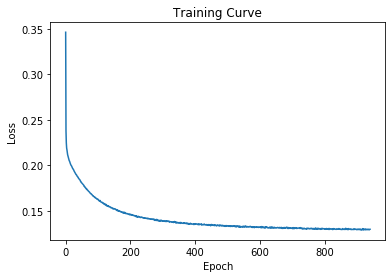

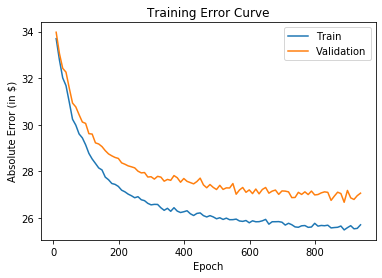

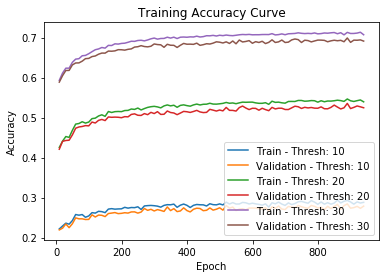

---[ITER 10] loss: 0.130380  time: 3.428
---[ITER 20] loss: 0.127694  time: 4.405
---[ITER 30] loss: 0.130793  time: 4.105
---[ITER 40] loss: 0.126721  time: 5.191
---[ITER 50] loss: 0.130504  time: 3.185
---[ITER 60] loss: 0.126583  time: 3.136
---[ITER 70] loss: 0.134832  time: 3.514
---[ITER 80] loss: 0.131613  time: 3.294
---[ITER 90] loss: 0.129879  time: 3.449
---[ITER 100] loss: 0.129765  time: 4.821
---[ITER 110] loss: 0.130113  time: 3.588
---[ITER 120] loss: 0.129986  time: 4.069
---[ITER 130] loss: 0.123985  time: 3.499
---[ITER 140] loss: 0.129677  time: 3.563
---[ITER 150] loss: 0.132293  time: 3.246
---[ITER 160] loss: 0.133021  time: 3.150
[EPOCH 941] loss: 0.129738  time: 62.329
---[ITER 10] loss: 0.134044  time: 3.527
---[ITER 20] loss: 0.130972  time: 3.542
---[ITER 30] loss: 0.130144  time: 3.799
---[ITER 40] loss: 0.127484  time: 4.843
---[ITER 50] loss: 0.124013  time: 3.429
---[ITER 60] loss: 0.132088  time: 3.183
---[ITER 70] loss: 0.126795  time: 3.053
---[ITER 

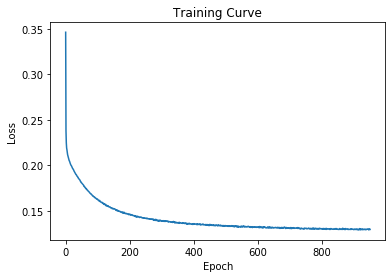

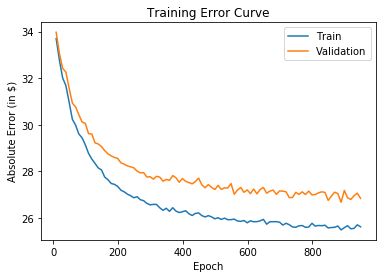

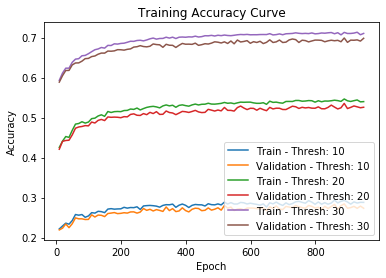

---[ITER 10] loss: 0.128553  time: 3.046
---[ITER 20] loss: 0.130114  time: 3.007
---[ITER 30] loss: 0.130337  time: 2.973
---[ITER 40] loss: 0.130065  time: 2.942
---[ITER 50] loss: 0.129239  time: 3.023
---[ITER 60] loss: 0.129219  time: 3.056
---[ITER 70] loss: 0.131899  time: 3.106
---[ITER 80] loss: 0.133498  time: 4.070
---[ITER 90] loss: 0.131258  time: 3.715
---[ITER 100] loss: 0.128897  time: 4.703
---[ITER 110] loss: 0.130098  time: 3.113
---[ITER 120] loss: 0.129879  time: 2.969
---[ITER 130] loss: 0.133437  time: 2.900
---[ITER 140] loss: 0.127157  time: 3.267
---[ITER 150] loss: 0.128690  time: 3.860
---[ITER 160] loss: 0.129574  time: 3.465
[EPOCH 951] loss: 0.130012  time: 55.852
---[ITER 10] loss: 0.131536  time: 3.491
---[ITER 20] loss: 0.127919  time: 4.845
---[ITER 30] loss: 0.126827  time: 3.626
---[ITER 40] loss: 0.130543  time: 4.615
---[ITER 50] loss: 0.127931  time: 3.530
---[ITER 60] loss: 0.127266  time: 3.266
---[ITER 70] loss: 0.130008  time: 3.011
---[ITER 

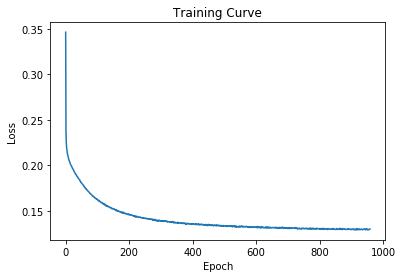

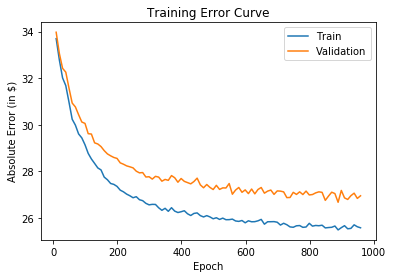

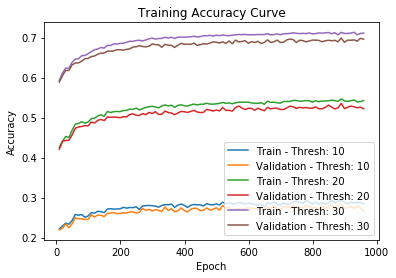

---[ITER 10] loss: 0.132466  time: 3.480
---[ITER 20] loss: 0.125474  time: 3.316
---[ITER 30] loss: 0.130141  time: 3.386
---[ITER 40] loss: 0.129853  time: 3.545
---[ITER 50] loss: 0.128464  time: 3.537
---[ITER 60] loss: 0.131065  time: 3.294
---[ITER 70] loss: 0.128921  time: 3.118
---[ITER 80] loss: 0.131199  time: 3.033
---[ITER 90] loss: 0.129099  time: 3.248
---[ITER 100] loss: 0.130842  time: 3.347
---[ITER 110] loss: 0.130374  time: 2.986
---[ITER 120] loss: 0.125569  time: 3.148
---[ITER 130] loss: 0.128026  time: 3.334
---[ITER 140] loss: 0.133652  time: 3.130
---[ITER 150] loss: 0.134443  time: 2.950
---[ITER 160] loss: 0.126814  time: 3.211
[EPOCH 961] loss: 0.129903  time: 54.542
---[ITER 10] loss: 0.128581  time: 3.290
---[ITER 20] loss: 0.127654  time: 3.256
---[ITER 30] loss: 0.131949  time: 3.277
---[ITER 40] loss: 0.133295  time: 3.322
---[ITER 50] loss: 0.126113  time: 3.233
---[ITER 60] loss: 0.131100  time: 3.178
---[ITER 70] loss: 0.126535  time: 3.293
---[ITER 

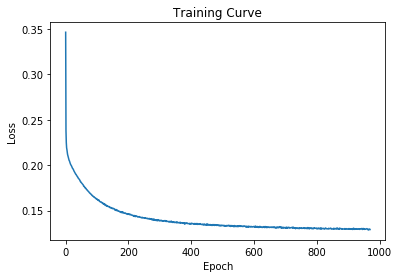

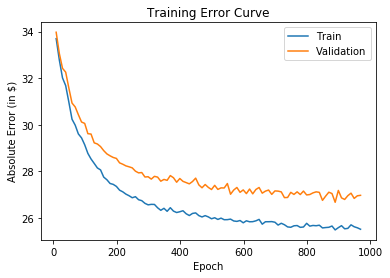

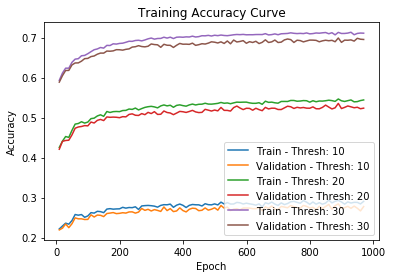

---[ITER 10] loss: 0.129276  time: 3.450
---[ITER 20] loss: 0.125177  time: 3.565
---[ITER 30] loss: 0.130305  time: 3.938
---[ITER 40] loss: 0.127099  time: 4.402
---[ITER 50] loss: 0.129511  time: 4.295
---[ITER 60] loss: 0.130541  time: 3.732
---[ITER 70] loss: 0.127238  time: 3.460
---[ITER 80] loss: 0.131242  time: 3.332
---[ITER 90] loss: 0.126239  time: 3.304
---[ITER 100] loss: 0.127790  time: 3.266
---[ITER 110] loss: 0.129748  time: 3.351
---[ITER 120] loss: 0.135298  time: 3.239
---[ITER 130] loss: 0.128007  time: 3.250
---[ITER 140] loss: 0.132205  time: 3.661
---[ITER 150] loss: 0.129966  time: 3.411
---[ITER 160] loss: 0.133596  time: 3.694
[EPOCH 971] loss: 0.129457  time: 60.884
---[ITER 10] loss: 0.128542  time: 5.685
---[ITER 20] loss: 0.130643  time: 12.049
---[ITER 30] loss: 0.131069  time: 6.697
---[ITER 40] loss: 0.127691  time: 4.721
---[ITER 50] loss: 0.128997  time: 3.488
---[ITER 60] loss: 0.127199  time: 3.386
---[ITER 70] loss: 0.131056  time: 3.417
---[ITER

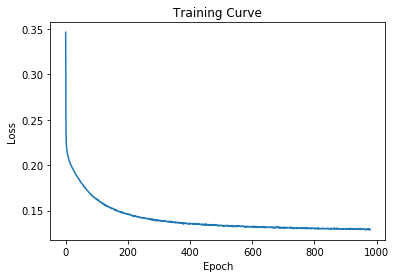

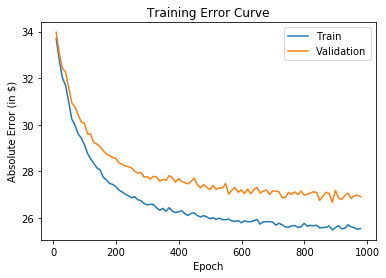

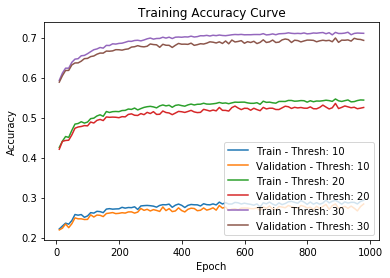

---[ITER 10] loss: 0.134894  time: 3.059
---[ITER 20] loss: 0.126882  time: 3.765
---[ITER 30] loss: 0.130006  time: 4.485
---[ITER 40] loss: 0.132369  time: 3.559
---[ITER 50] loss: 0.124152  time: 4.908
---[ITER 60] loss: 0.131691  time: 4.143
---[ITER 70] loss: 0.126244  time: 3.451
---[ITER 80] loss: 0.136211  time: 3.378
---[ITER 90] loss: 0.122908  time: 3.600
---[ITER 100] loss: 0.128847  time: 3.799
---[ITER 110] loss: 0.129255  time: 4.514
---[ITER 120] loss: 0.126983  time: 5.287
---[ITER 130] loss: 0.130855  time: 4.828
---[ITER 140] loss: 0.127790  time: 4.126
---[ITER 150] loss: 0.131339  time: 3.687
---[ITER 160] loss: 0.127352  time: 3.469
[EPOCH 981] loss: 0.129373  time: 68.137
---[ITER 10] loss: 0.125055  time: 3.919
---[ITER 20] loss: 0.132525  time: 3.383
---[ITER 30] loss: 0.128559  time: 3.734
---[ITER 40] loss: 0.127910  time: 3.968
---[ITER 50] loss: 0.131433  time: 4.719
---[ITER 60] loss: 0.130830  time: 5.915
---[ITER 70] loss: 0.127010  time: 5.524
---[ITER 

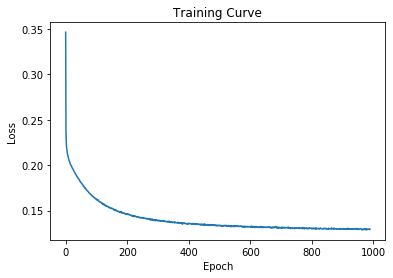

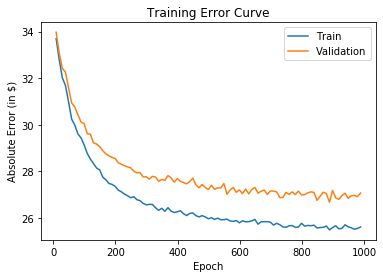

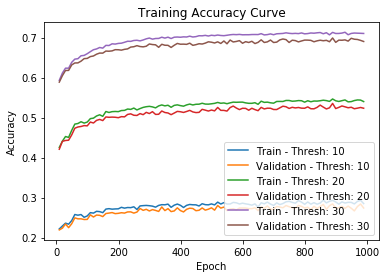

---[ITER 10] loss: 0.130382  time: 3.321
---[ITER 20] loss: 0.126150  time: 3.108
---[ITER 30] loss: 0.131779  time: 3.112
---[ITER 40] loss: 0.128577  time: 3.027
---[ITER 50] loss: 0.134358  time: 2.893
---[ITER 60] loss: 0.128377  time: 3.083
---[ITER 70] loss: 0.128257  time: 3.252
---[ITER 80] loss: 0.129324  time: 3.261
---[ITER 90] loss: 0.129426  time: 3.301
---[ITER 100] loss: 0.131462  time: 3.182
---[ITER 110] loss: 0.128328  time: 5.059
---[ITER 120] loss: 0.129564  time: 6.421
---[ITER 130] loss: 0.127028  time: 4.747
---[ITER 140] loss: 0.125439  time: 3.806
---[ITER 150] loss: 0.129695  time: 3.415
---[ITER 160] loss: 0.129357  time: 3.471
[EPOCH 991] loss: 0.129166  time: 61.287
---[ITER 10] loss: 0.130377  time: 3.731
---[ITER 20] loss: 0.127033  time: 3.471
---[ITER 30] loss: 0.130545  time: 4.289
---[ITER 40] loss: 0.124119  time: 3.689
---[ITER 50] loss: 0.131053  time: 4.401
---[ITER 60] loss: 0.131325  time: 4.186
---[ITER 70] loss: 0.132458  time: 3.897
---[ITER 

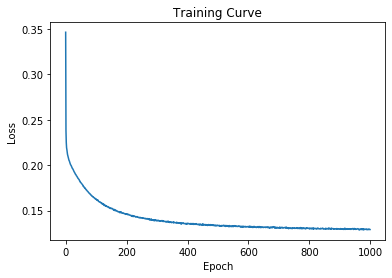

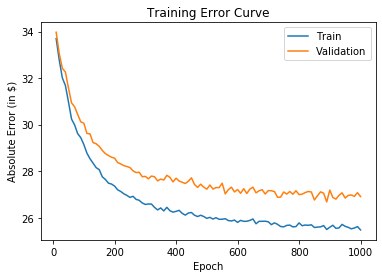

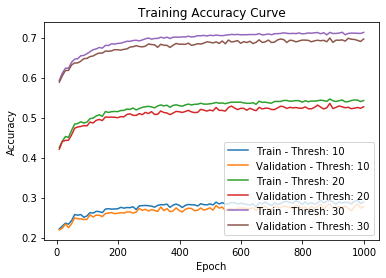

Training Completed...
[FINAL] loss: 0.129119  time: 66409.093


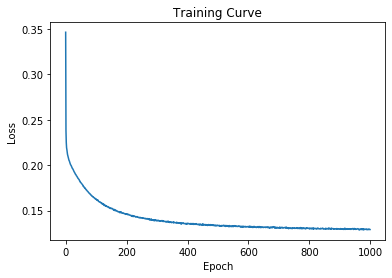

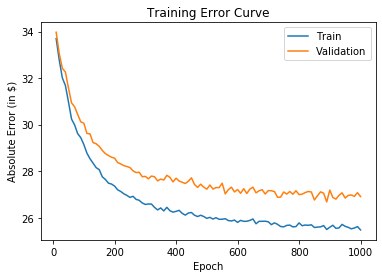

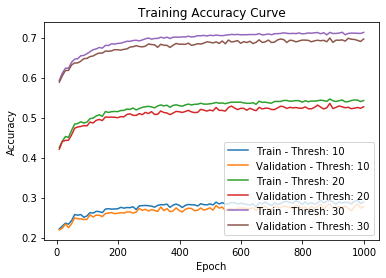

In [10]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1000)

In [11]:
checkpoint = torch.load("../test/Brian/nov19_test01/final/checkpoint_final.tar")

In [12]:
print("Minimum Train Error:\t\t", min(checkpoint["train_error"]))
print("Index of Min Train Error:\t", checkpoint["train_error"].index(min(checkpoint["train_error"])))
print("Minimum Val Error:\t\t", min(checkpoint["val_error"]))
print("Index of Min Val Error:\t\t", checkpoint["val_error"].index(min(checkpoint["val_error"])))

Minimum Train Error:		 25.473014794235862
Index of Min Train Error:	 99
Minimum Val Error:		 26.67754541700458
Index of Min Val Error:		 88


In [13]:
print("For Threshold=20")
print("Maximum Train Accuracy:\t", max(checkpoint["train_acc"][1]))
print("Index of Max Train Acc:\t", checkpoint["train_acc"][1].index(max(checkpoint["train_acc"][1])))
print("Maximum Val Accuracy:\t", max(checkpoint["val_acc"][1]))
print("Index of Max Val Acc:\t", checkpoint["val_acc"][1].index(max(checkpoint["val_acc"][1])))

For Threshold=20
Maximum Train Accuracy:	 0.5463766905994323
Index of Max Train Acc:	 88
Maximum Val Accuracy:	 0.5353019750023853
Index of Max Val Acc:	 88
